### purpose

build a script to calculate fitness from phenotypes and 

In [1]:
from pythonimports import *
from myfigs import histo_box

import MVP_01_train_gradient_forests as mvp01
import MVP_10_train_lfmm2_offset as mvp10
import MVP_06_validate_RONA as mvp06
import MVP_summary_functions as mvp

outlier_dir = '/home/b.lind/offsets/climate_outlier_runs'
# envdir = op.join(outlier_dir, 'garden_files')  # symlinked to climate_outlier_runs/run_20220919_225-450/GF/garden_files
tmp_dir = makedir(op.join(outlier_dir, 'fitness_tmp'))
fitness_dir = makedir(op.join(outlier_dir, 'fitness_mats'))

# erase tmp_dir as a sanity check
[os.remove(f) for f in fs(tmp_dir)]

lview, dview = get_client(cluster_id='1677681581-fd9r', profile='lotterhos')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	March 01, 2023 - 15:04:08
python version: 3.8.5

Current commit of pythonimports:
commit f7e63eead1814fe6ce13da1f593ebfb19efdc4c2  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Feb 15 14:14:00 2023 -0500

Current commit of MVP_offsets:
commit 76a2a11bc372c07154b69b38816339897cc6b361  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 17 14:50:32 2023 -0500
#########################################################



In [2]:
params = mvp10.read_params_file('/home/b.lind/offsets/run_20220919_0-225/slimdir')

params.head()

level  reps  \
1231094  highly-polygenic_1-trait__Est-Clines_N-cline-c...     1   
1231095  highly-polygenic_1-trait__Est-Clines_N-cline-N...     1   
1231096  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231097  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231098  highly-polygenic_1-trait__Est-Clines_N-variabl...     1   

                             arch  \
1231094  highly-polygenic_1-trait   
1231095  highly-polygenic_1-trait   
1231096  highly-polygenic_1-trait   
1231097  highly-polygenic_1-trait   
1231098  highly-polygenic_1-trait   

                                           demog_name  \
1231094  Est-Clines_N-cline-center-to-edge_m-constant   
1231095          Est-Clines_N-cline-N-to-S_m-constant   
1231096                   Est-Clines_N-equal_m_breaks   
1231097                 Est-Clines_N-equal_m-constant   
1231098              Est-Clines_N-variable_m-variable   

                           demog_level_sub demog_level  MIG_x  MIG_y  xcline  \
1231094  N-cline-center-to-edge_m-constant  Est-Clines   0.49   0.07  linear   
1231095          N-cline-N-to-S_m-constant  Est-Clines   0.49   0.07  linear   
1231096                   N-equal_m_breaks  Est-Clines   0.49   0.07  linear   
1231097                 N-equal_m-constant  Est-Clines   0.49   0.07  linear   
1231098              N-variable_m-variable  Est-Clines   0.49   0.07  linear   

         ycline    demog  METAPOP_SIDE_x  METAPOP_SIDE_y  Nequal  isVariableM  \
1231094  linear  Estuary              10              10       4            0   
1231095  linear  Estuary              10              10       2            0   
1231096  linear  Estuary              10              10       0            0   
1231097  linear  Estuary              10              10       0            0   
1231098  linear  Estuary              10              10       3            1   

         MIG_breaks arch_level_sub        arch_level       MU_base  \
1231094           0        1-trait  highly-polygenic  1.000000e-07   
1231095           0        1-trait  highly-polygenic  1.000000e-07   
1231096           1        1-trait  highly-polygenic  1.000000e-07   
1231097           0        1-trait  highly-polygenic  1.000000e-07   
1231098           0        1-trait  highly-polygenic  1.000000e-07   

         MU_QTL_proportion  SIGMA_QTN_1  SIGMA_QTN_2  SIGMA_K_1  SIGMA_K_2  \
1231094               0.25        0.002        0.002        0.5        0.5   
1231095               0.25        0.002        0.002        0.5        0.5   
1231096               0.25        0.002        0.002        0.5        0.5   
1231097               0.25        0.002        0.002        0.5        0.5   
1231098               0.25        0.002        0.002        0.5        0.5   

         N_traits  ispleiotropy     seed  
1231094         1             0  1231094  
1231095         1             0  1231095  
1231096         1             0  1231096  
1231097         1             0  1231097  
1231098         1             0  1231098

In [3]:
seed_2trait = params[params.N_traits==2].index.tolist()[0]

seed_2trait

'1231109'

In [4]:
seed_1trait = params[params.N_traits==1].index.tolist()[0]

seed_1trait

'1231094'

# create script to calc in R

In [5]:
rtext = '''\
#####################################################################################
# Calculate fitness for all populations to a garden environment with temp optimimum 
#        `opt1` and env2 optimum `opt0`.
#
# Notes
# -----
# only include environmental optima (opt0, opt1) if they are underlying selection
#
# Usage
# -----
# conda activate MVP_env_R4.0.3
# Rscript MVP_climate_outlier_fitness_calculator.R seed output_file opt1 [opt2]
# 
# Parameters
# ----------
# seed - simulation seed
# output_file - where to save fitness calculation
# opt1 - temperature optimum for the common garden
# opt2 - (optional) evn2 optimum for the common garden
# 
#####################################################################################
library('mvtnorm')
library(progress)
len = length

print(sessionInfo())

args = commandArgs(trailingOnly=TRUE)

seed = as.character(args[1])
output_file = args[2]
opt1 = as.numeric(args[3])  # temp

if (len(args) == 4){
    opt0 = as.numeric(args[4])  # sal
}

slimdir = '/work/lotterhos/MVP-NonClinalAF/sim_output_20220428/'  # universal directory

# find SIGMA
params_file = '/work/lotterhos/MVP-NonClinalAF/src/0b-final_params-20220428.txt'
params = read.table(params_file, sep=' ', header=T)
rownames(params) = params$seed
sigma_k0 = params[seed, 'SIGMA_K_1']
sigma_k1 = params[seed, 'SIGMA_K_2']

# get phenotype data
subset = read.table(paste0(slimdir, seed, '_Rout_ind_subset.txt'),
                    sep=' ',
                    header=T)

# create empty dataframe (1 row because input args #2 and #3 specify optima for a single garden ID)
fitness = data.frame(matrix(nrow=1, ncol=100))
colnames(fitness) = 1:ncol(fitness)

# fill in empty dataframe with fitness of each transplant into garden with optima opt0 and opt1
for (transplant_ID in 1:100){
    if (len(args) == 4){  # for two selective environments
        phenos = cbind(subset[subset$subpopID == transplant_ID, 'phen_sal'],
                       subset[subset$subpopID == transplant_ID, 'phen_temp'])
        opts = c(opt0, opt1)
        
        fitness_varcov = matrix(c(sigma_k0, 0, 0, sigma_k1), nrow=2)
        fitness_norm = dmvnorm(c(0.0, 0.0), c(0.0, 0.0), fitness_varcov)
        
        fits = dmvnorm(
            phenos,
            opts,
            sigma=fitness_varcov
        ) / fitness_norm
        
    } else {  # for one selective environment
        phen_temp = subset[subset$subpopID == transplant_ID, 'phen_temp']
        
        fitness_norm = dnorm(0, 0, sigma_k1)
        
        fits = dnorm(phen_temp, opt1, sigma_k1) / fitness_norm
    }
    
    fits = round(fits, 2)
    
    fitness[1, transplant_ID] = mean(fits)
    
}

write.table(fitness, output_file, sep='\t', row.names=T, col.names=T)


'''

script_file = '/home/b.lind/code/MVP-offsets/01_src/MVP_climate_outlier_fitness_calculator.R'
with open(script_file, 'w') as o:
    o.write(rtext)

# calc fitness

In [6]:
# def calc_R_fitness(*args):
#     import subprocess
    
#     args = [str(arg) for arg in args]
    
#     Rscript = '/home/b.lind/anaconda3/envs/MVP_env_R4.0.3/bin/Rscript'
#     script_file = '/home/b.lind/delete/fits_calc_ind.R'
    
#     output = subprocess.check_output(
#         [
#             Rscript,
#             script_file,
#             *args
#         ]
#     ).decode("utf-8").split('\n')[0].split()[-1].split('''"''')[1]  # when I print(mean_fits)
    
#     return float(output)


def calc_R_fitness(*args):
    import subprocess
    
    args = [str(arg) for arg in args]
    
    Rscript = '/home/b.lind/anaconda3/envs/MVP_env_R4.0.3/bin/Rscript'
#     script_file = '/home/b.lind/delete/fits_calc_ind.R'
#     script_file = '/home/b.lind/delete/fits_calc_ind_all.R'
    script_file = '/home/b.lind/code/MVP-offsets/01_src/MVP_climate_outlier_fitness_calculator.R'
    
    output = subprocess.check_output(
        [
            Rscript,
            script_file,
            *args
        ]
    )

    pass


# 2-trait simulation

In [7]:
slimdir = '/work/lotterhos/MVP-NonClinalAF/sim_output_20220428/'

subset = mvp01.read_ind_data(slimdir, seed_2trait)
envdata = subset.groupby('subpopID')[['opt0', 'opt1']].apply(np.mean)


jobs = []
args = []
for pop, (opt0, opt1) in envdata.iterrows():
    output_file = op.join(tmp_dir, f'{seed_2trait}_{str(pop).zfill(3)}_fitness.txt')
    
    arg = (seed_2trait, output_file, opt1, opt0)
    args.append(arg)
    
    jobs.append(
        lview.apply_async(
            calc_R_fitness, *(arg)
        )
    )
    
watch_async(jobs)


Reading in info for subsampled individuals ...

Watching 100 jobs ...


100%|███████████████| 100/100 [00:03<00:00, 30.50it/s]


In [8]:
dfs = []
for f in pbar(sorted(fs(tmp_dir, startswith=seed_2trait))):
    seed, pop, *_ = op.basename(f).split("_")
    
    df = pd.read_table(f)
    df.index = [int(pop)]
    
    dfs.append(df)
    
del seed

calcd_fit = pd.concat(dfs)

calcd_fit

100%|███████████████| 100/100 [00:00<00:00, 268.35it/s]


1      2      3      4      5      6      7      8      9     10  \
1    0.724  0.872  0.645  0.578  0.313  0.477  0.215  0.147  0.031  0.042   
2    0.848  0.947  0.800  0.706  0.422  0.623  0.332  0.244  0.064  0.085   
3    0.909  0.940  0.905  0.802  0.535  0.752  0.470  0.368  0.120  0.156   
4    0.894  0.850  0.934  0.849  0.641  0.843  0.616  0.511  0.211  0.261   
5    0.807  0.700  0.883  0.831  0.731  0.870  0.740  0.659  0.336  0.402   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.008  0.012  0.013  0.023  0.021  0.027  0.019  0.022  0.008  0.017   
97   0.008  0.009  0.008  0.019  0.019  0.022  0.023  0.025  0.012  0.021   
98   0.005  0.006  0.006  0.015  0.018  0.019  0.024  0.025  0.013  0.026   
99   0.002  0.002  0.003  0.011  0.017  0.014  0.022  0.024  0.016  0.026   
100  0.001  0.000  0.001  0.008  0.014  0.008  0.020  0.021  0.017  0.025   

        11     12     13     14     15     16     17     18     19     20  \
1    0.739  0.720  0.792  0.537  0.458  0.296  0.210  0.119  0.060  0.037   
2    0.810  0.807  0.888  0.693  0.596  0.435  0.326  0.206  0.117  0.074   
3    0.812  0.827  0.908  0.824  0.715  0.584  0.467  0.329  0.204  0.137   
4    0.742  0.777  0.841  0.894  0.792  0.719  0.611  0.480  0.331  0.231   
5    0.620  0.667  0.708  0.892  0.814  0.815  0.733  0.637  0.483  0.358   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.039  0.044  0.031  0.033  0.049  0.044  0.043  0.050  0.039  0.033   
97   0.026  0.033  0.021  0.027  0.042  0.043  0.045  0.053  0.046  0.038   
98   0.015  0.020  0.013  0.020  0.035  0.037  0.041  0.053  0.051  0.042   
99   0.009  0.013  0.008  0.014  0.025  0.029  0.037  0.047  0.049  0.045   
100  0.004  0.007  0.003  0.010  0.015  0.022  0.031  0.039  0.046  0.043   

        21     22     23     24     25     26     27     28     29     30  \
1    0.659  0.636  0.651  0.523  0.495  0.375  0.149  0.126  0.035  0.065   
2    0.749  0.739  0.746  0.639  0.620  0.509  0.237  0.206  0.069  0.120   
3    0.781  0.784  0.787  0.722  0.711  0.636  0.348  0.311  0.125  0.204   
4    0.745  0.762  0.763  0.750  0.755  0.726  0.470  0.431  0.209  0.317   
5    0.653  0.679  0.677  0.723  0.743  0.764  0.586  0.550  0.319  0.455   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.064  0.061  0.052  0.065  0.056  0.073  0.098  0.077  0.084  0.059   
97   0.048  0.042  0.038  0.051  0.045  0.064  0.102  0.085  0.104  0.072   
98   0.034  0.029  0.027  0.037  0.035  0.053  0.096  0.087  0.121  0.074   
99   0.021  0.019  0.015  0.026  0.023  0.039  0.083  0.082  0.127  0.075   
100  0.014  0.009  0.008  0.016  0.015  0.029  0.067  0.070  0.121  0.069   

        31     32     33     34     35     36     37     38     39     40  \
1    0.552  0.550  0.544  0.406  0.240  0.186  0.169  0.093  0.050  0.058   
2    0.604  0.581  0.610  0.486  0.340  0.284  0.252  0.149  0.093  0.101   
3    0.603  0.564  0.627  0.542  0.444  0.394  0.344  0.219  0.157  0.170   
4    0.552  0.500  0.591  0.560  0.531  0.498  0.432  0.302  0.243  0.258   
5    0.462  0.405  0.510  0.541  0.582  0.575  0.498  0.387  0.344  0.360   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.099  0.091  0.096  0.134  0.166  0.171  0.176  0.146  0.142  0.115   
97   0.069  0.061  0.071  0.110  0.151  0.163  0.172  0.158  0.163  0.138   
98   0.047  0.036  0.045  0.084  0.128  0.145  0.154  0.162  0.169  0.154   
99   0.027  0.021  0.028  0.058  0.097  0.113  0.129  0.153  0.166  0.157   
100  0.013  0.010  0.015  0.040  0.069  0.085  0.100  0.135  0.146  0.148   

        41     42     43     44     45     46     47     48     49     50  \
1    0.437  0.313  0.430  0.377  0.236  0.135  0.088  0.068  0.052  0.014   
2    0.462  0.364  0.470  0.461  0.317  0.201  0.139  0.121  0.077  0.030   
3    0.450  0.387  0.475  0.513  0.390  0.274  0.203  0.186  0.110  0.058   
4

Text(0, 0.5, 'recalculated fitness of\nsubpopID=1 in garden_x')

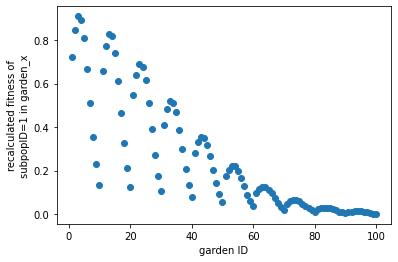

In [9]:
plt.scatter(calcd_fit.index, calcd_fit['1'])
plt.xlabel('garden ID')
plt.ylabel('recalculated fitness of\nsubpopID=1 in garden_x')

In [10]:
# load MVP fitness mat
fitness_mat = mvp06.load_pooled_fitness_matrix(slimdir, seed_2trait)

fitness_mat

1         2         3         4         5         6         7  \
1    0.724338  0.814271  0.599708  0.652848  0.415779  0.388263  0.192586   
2    0.847370  0.911773  0.728748  0.769642  0.559284  0.534555  0.295880   
3    0.908830  0.934517  0.819238  0.840883  0.694341  0.679151  0.421847   
4    0.894057  0.876911  0.852598  0.852238  0.796604  0.796380  0.558982   
5    0.807067  0.753428  0.822171  0.801657  0.845706  0.862098  0.689042   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.009833  0.012745  0.012409  0.017639  0.021801  0.024047  0.020432   
97   0.007591  0.009162  0.010429  0.014131  0.019617  0.022312  0.021606   
98   0.005378  0.006021  0.008167  0.010438  0.016340  0.019108  0.021266   
99   0.003496  0.003618  0.005961  0.007104  0.012615  0.015109  0.019443   
100  0.002086  0.001988  0.004055  0.004450  0.009036  0.011037  0.016470   

            8         9        10        11        12        13        14  \
1    0.149735  0.048638  0.042084  0.778316  0.744791  0.660145  0.530260   
2    0.249040  0.094435  0.084825  0.838894  0.840109  0.775079  0.662381   
3    0.379679  0.167921  0.156020  0.827516  0.866424  0.835209  0.766058   
4    0.531163  0.273775  0.261998  0.747160  0.816992  0.826146  0.820087   
5    0.682552  0.409728  0.401870  0.617509  0.704320  0.750138  0.812562   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.028075  0.010626  0.017449  0.032635  0.034262  0.041895  0.037659   
97   0.030072  0.013280  0.022014  0.022197  0.024491  0.032261  0.032240   
98   0.029590  0.015306  0.025345  0.013801  0.015993  0.022829  0.025556   
99   0.026757  0.016287  0.026635  0.007844  0.009538  0.014844  0.018753   
100  0.022238  0.016017  0.025553  0.004076  0.005193  0.008865  0.012736   

           15        16        17        18        19        20        21  \
1    0.456086  0.287835  0.210967  0.110793  0.069994  0.047449  0.675561   
2    0.589805  0.401006  0.320780  0.186880  0.127100  0.093031  0.764973   
3    0.706764  0.522442  0.451644  0.292193  0.212787  0.166759  0.790870   
4    0.784730  0.635769  0.588946  0.422813  0.328609  0.273378  0.746807   
5    0.807046  0.721605  0.711237  0.565358  0.468196  0.410010  0.644347   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.045873  0.051755  0.044676  0.045598  0.030645  0.037798  0.056627   
97   0.039555  0.050449  0.046001  0.051060  0.037961  0.046349  0.041855   
98   0.031601  0.045770  0.043805  0.052630  0.043336  0.051936  0.028430   
99   0.023372  0.038612  0.038568  0.049921  0.045563  0.053198  0.017737   
100  0.015985  0.030273  0.031390  0.043565  0.044087  0.049824  0.010157   

           22        23        24        25        26        27        28  \
1    0.603120  0.566815  0.494398  0.358788  0.282236  0.162800  0.097797   
2    0.690270  0.662967  0.597899  0.478073  0.392649  0.249170  0.167814   
3    0.725814  0.716777  0.669332  0.589304  0.507585  0.354683  0.264527   
4    0.701586  0.716025  0.694581  0.672158  0.609855  0.469381  0.383391   
5    0.623808  0.660667  0.668963  0.709528  0.680992  0.577192  0.511369   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.069738  0.069292  0.076384  0.084806  0.082156  0.086261  0.068913   
97   0.052525  0.055711  0.063433  0.076989  0.080663  0.091240  0.078287   
98   0.036338  0.041470  0.049053  0.064838  0.073620  0.089199  0.081879   
99   0.023092  0.028609  0.035328  0.050666  0.062405  0.080527  0.078873   
100  0.013478  0.018314  0.023687  0.036739  0.049077  0.067065  0.070003   

           29        30        31        32        33        34        35  \
1    0.049221  0.052099  0.535667  0.562619  0.482570  0.397922  0.314982   
2    0.093662  0.099494  0.588403  0.596629  0.556118  0.486375  0.416207   
3    0.163006  0.173871  0.593125  0.581769  0.590925  0.549539  0.506906   
4   

Text(0, 0.5, 'fitness of subpopID=1 in garden_x')

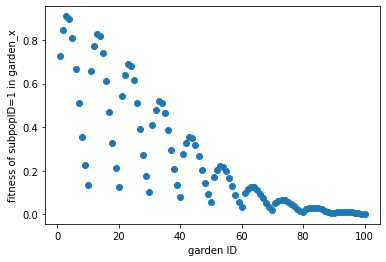

In [11]:
plt.scatter(fitness_mat.index, fitness_mat['1'])
plt.xlabel('garden ID')
plt.ylabel('fitness of subpopID=1 in garden_x')

### histograms of correlations for fitness to a specific garden

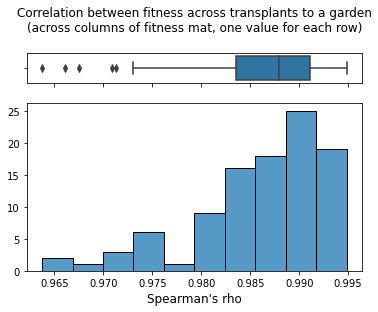

In [12]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=1, method='spearman'),
    title='Correlation between fitness across transplants to a garden\n(across columns of fitness mat, one value for each row)\n',
    xlab="Spearman's rho"
)


plt.show()

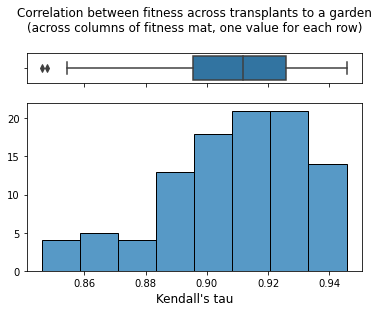

In [13]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=1, method='kendall'),
    title='Correlation between fitness across transplants to a garden\n(across columns of fitness mat, one value for each row)\n',
    xlab="Kendall's tau"
)


plt.show()

### histograms of correlations for fitness from a specific source population

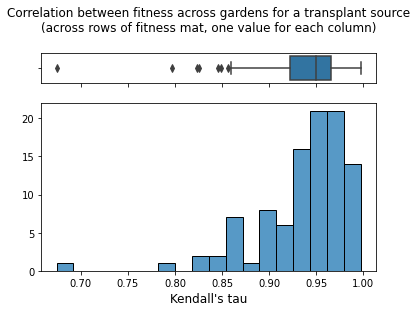

In [14]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=0, method='kendall'),
    title='Correlation between fitness across gardens for a transplant source\n(across rows of fitness mat, one value for each column)\n',
    xlab="Kendall's tau"
)

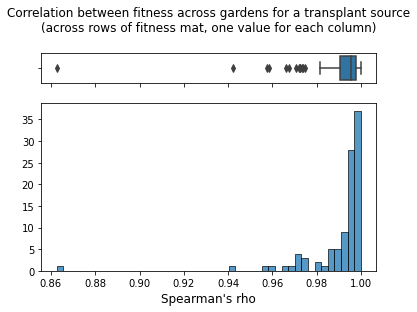

In [15]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=0, method='spearman'),
    title='Correlation between fitness across gardens for a transplant source\n(across rows of fitness mat, one value for each column)\n',
    xlab="Spearman's rho"
)

### Scatter plots of known vs re-calculated fitness


 row = 1


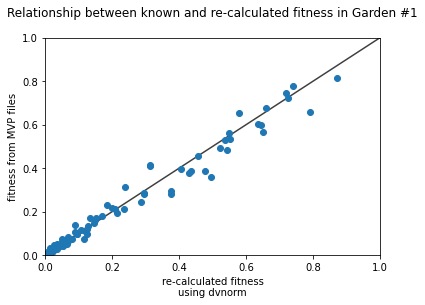


 row = 2


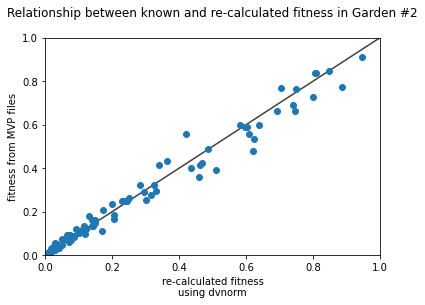


 row = 3


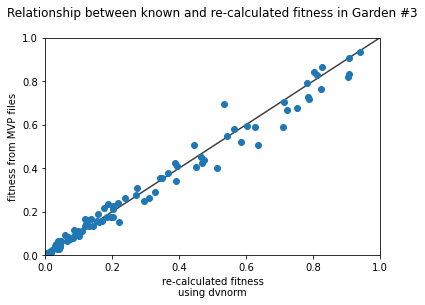


 row = 4


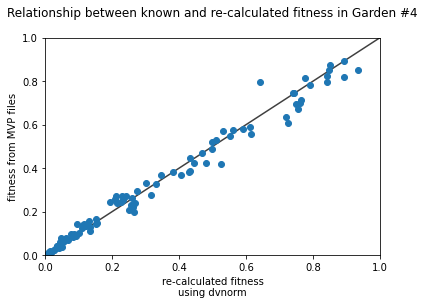


 row = 5


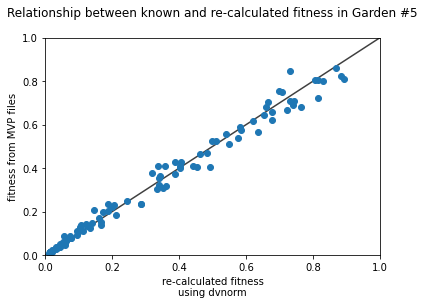


 row = 6


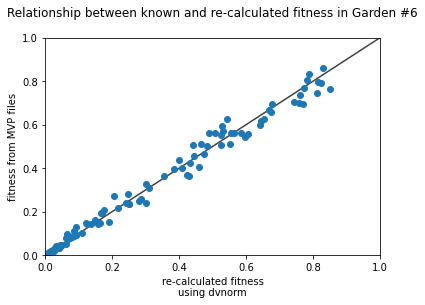


 row = 7


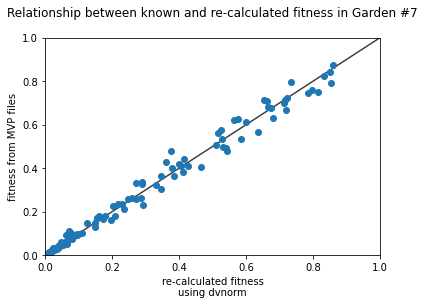


 row = 8


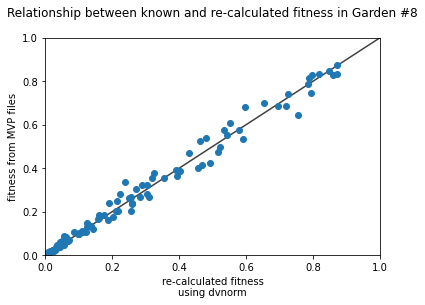


 row = 9


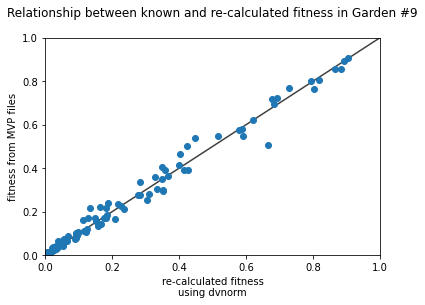


 row = 10


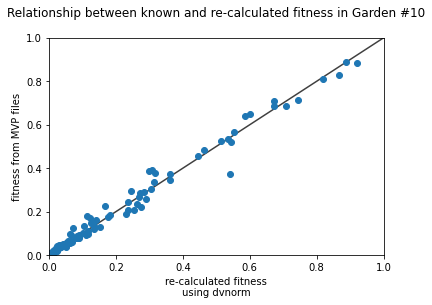


 row = 11


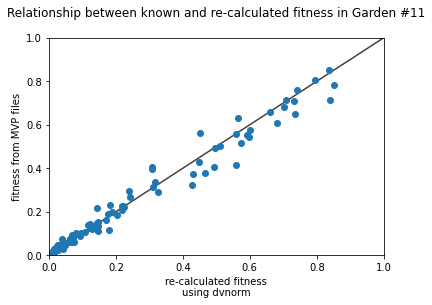


 row = 12


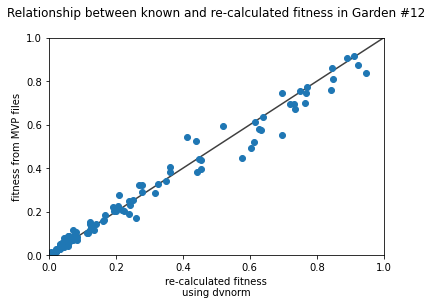


 row = 13


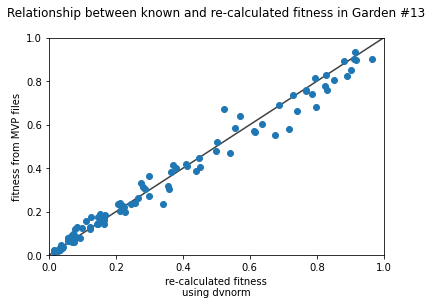


 row = 14


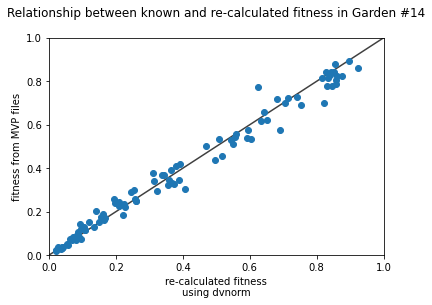


 row = 15


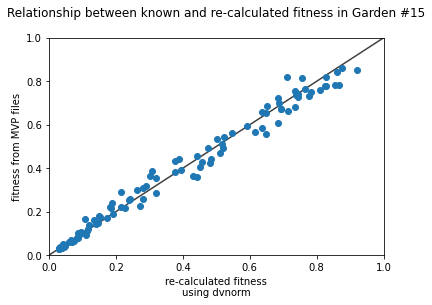


 row = 16


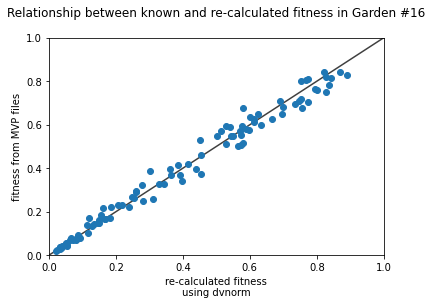


 row = 17


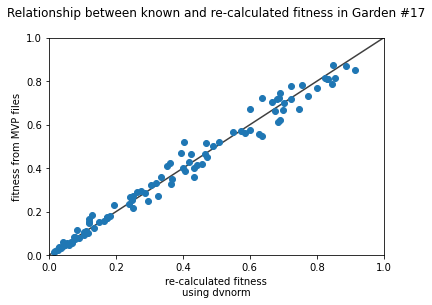


 row = 18


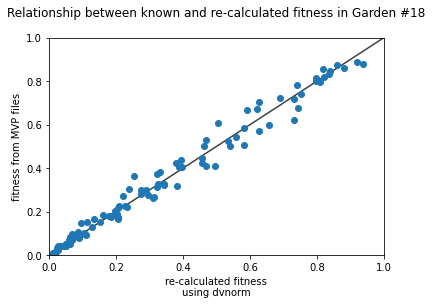


 row = 19


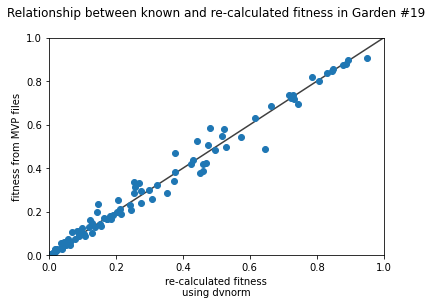


 row = 20


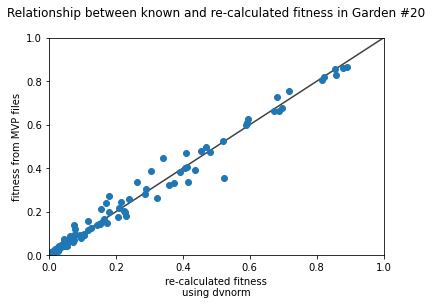


 row = 21


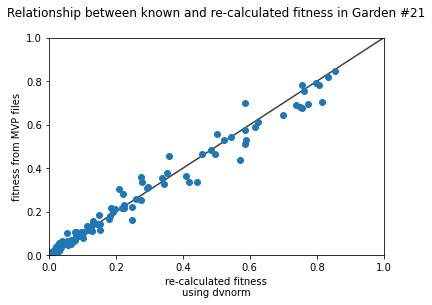


 row = 22


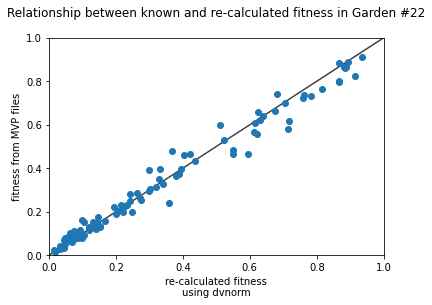


 row = 23


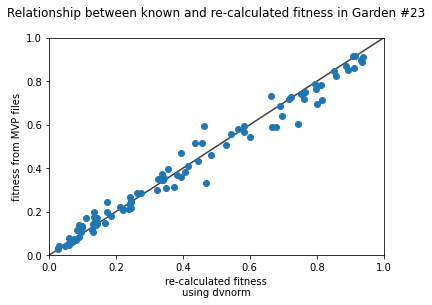


 row = 24


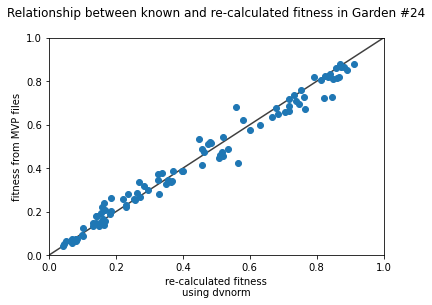


 row = 25


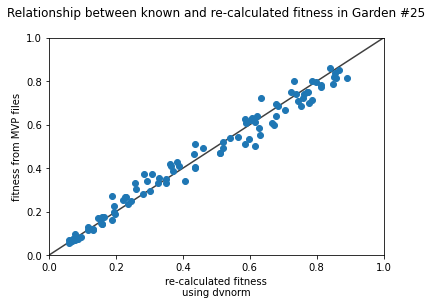


 row = 26


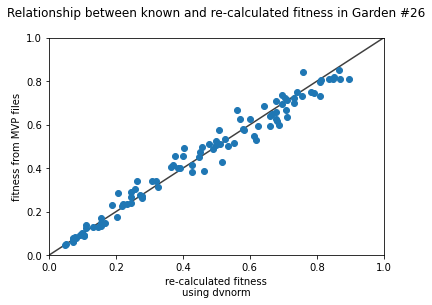


 row = 27


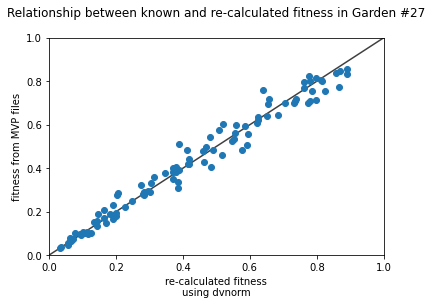


 row = 28


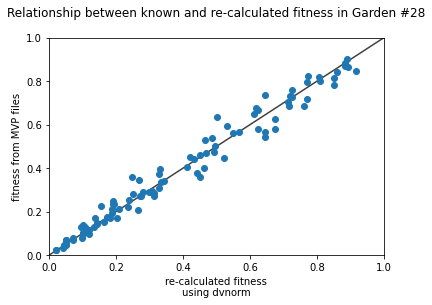


 row = 29


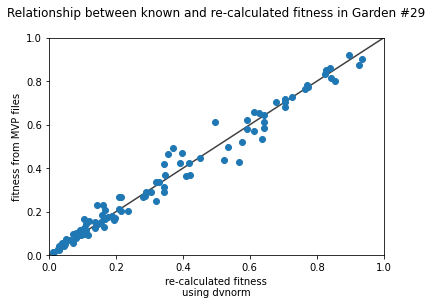


 row = 30


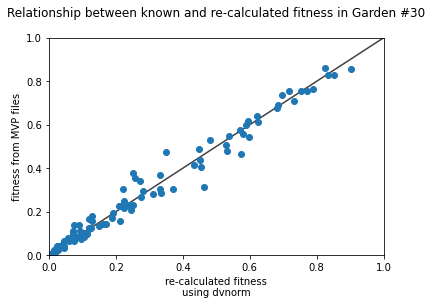


 row = 31


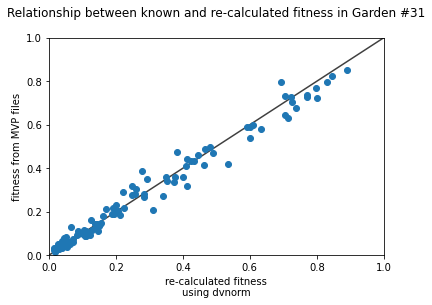


 row = 32


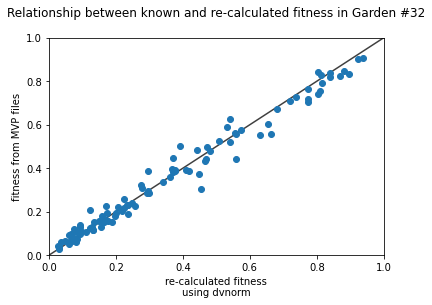


 row = 33


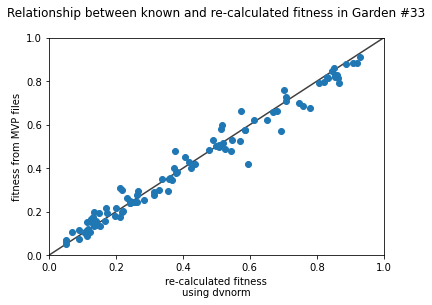


 row = 34


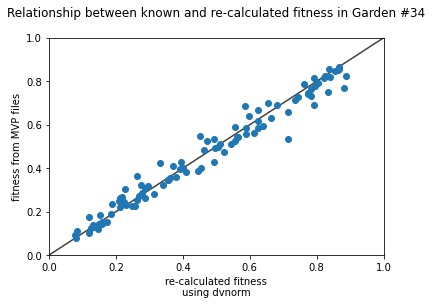


 row = 35


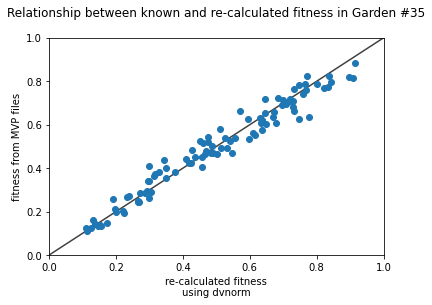


 row = 36


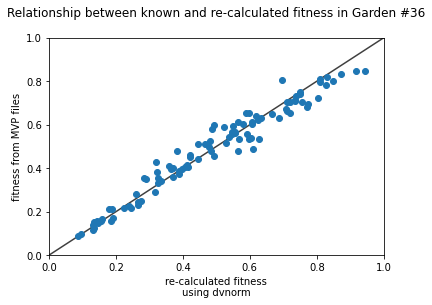


 row = 37


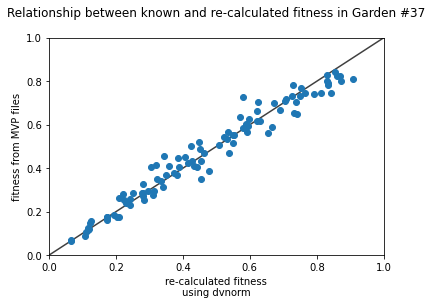


 row = 38


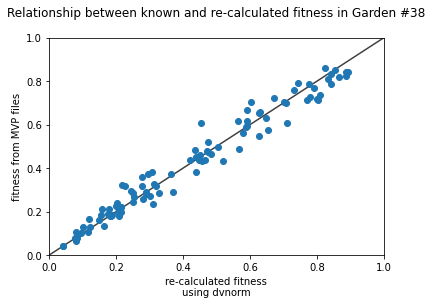


 row = 39


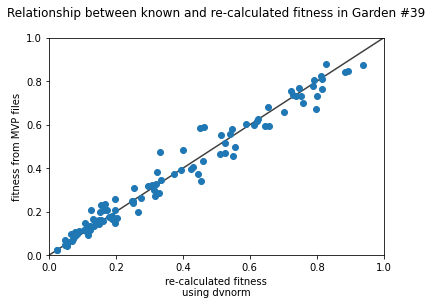


 row = 40


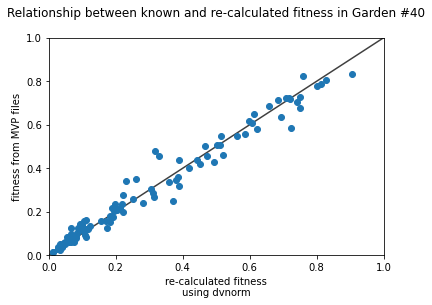


 row = 41


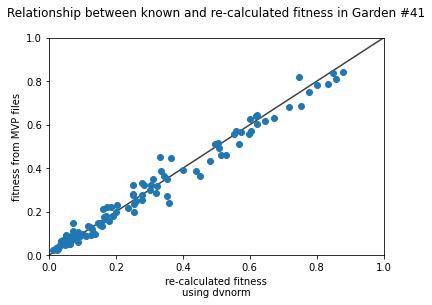


 row = 42


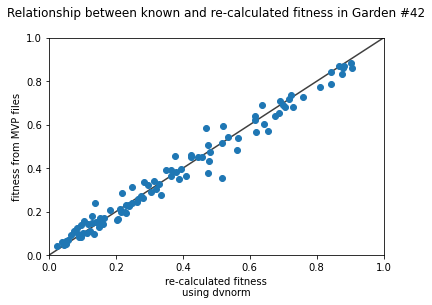


 row = 43


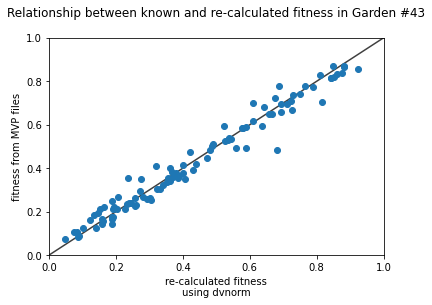


 row = 44


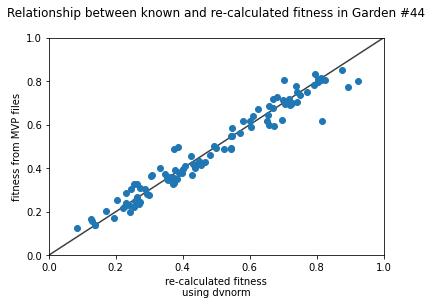


 row = 45


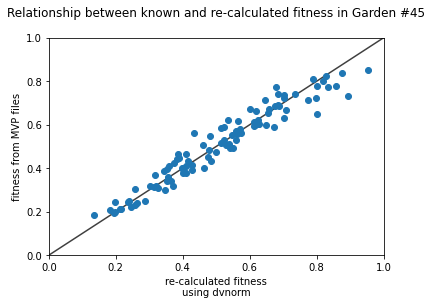


 row = 46


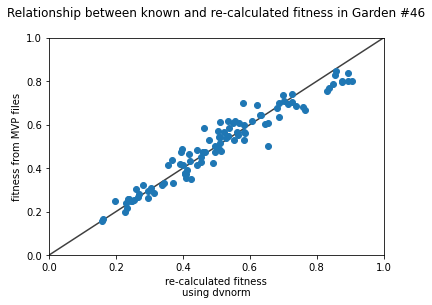


 row = 47


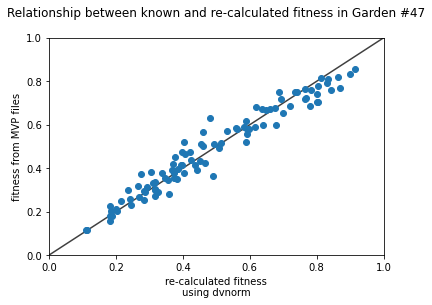


 row = 48


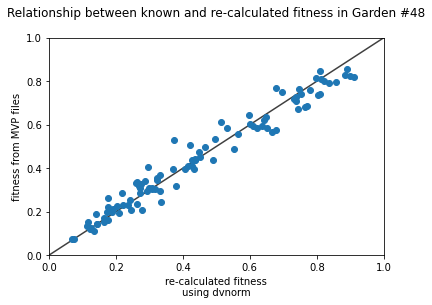


 row = 49


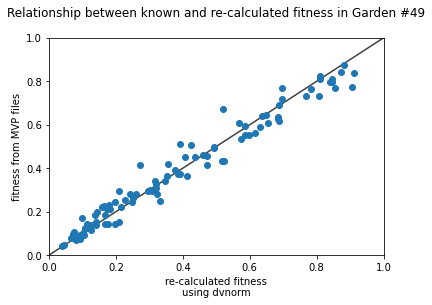


 row = 50


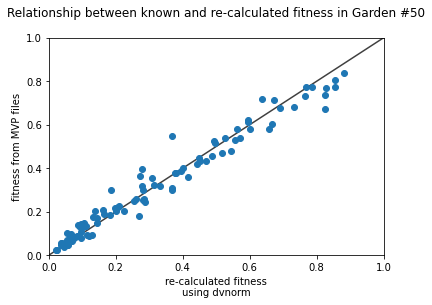


 row = 51


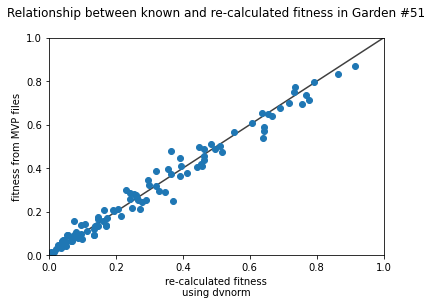


 row = 52


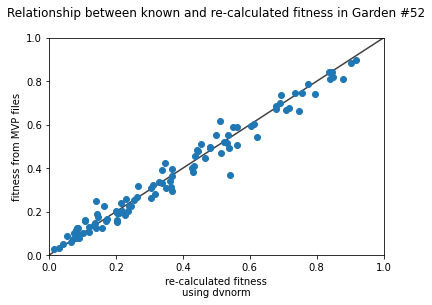


 row = 53


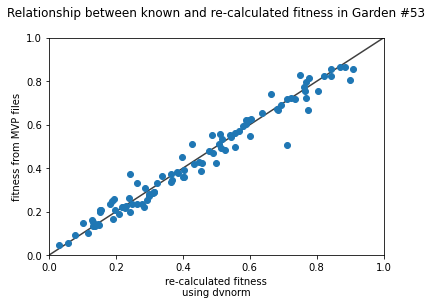


 row = 54


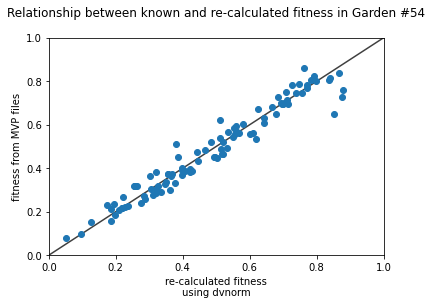


 row = 55


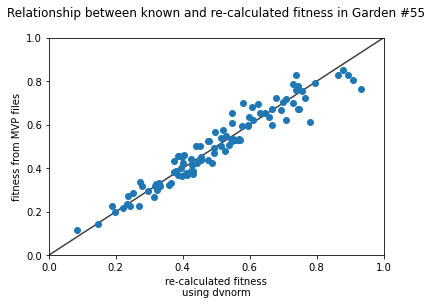


 row = 56


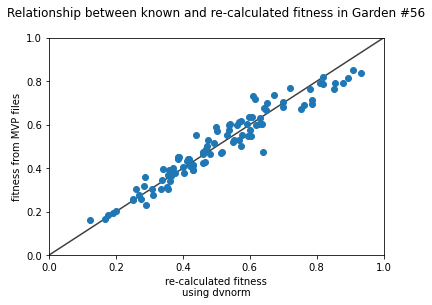


 row = 57


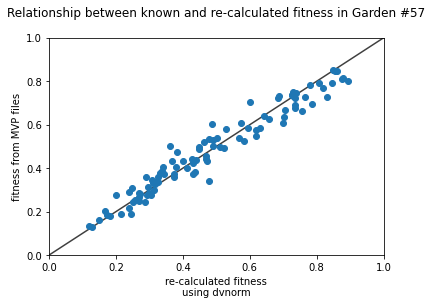


 row = 58


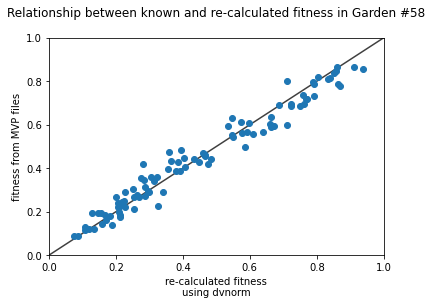


 row = 59


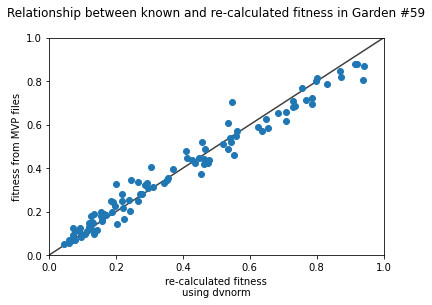


 row = 60


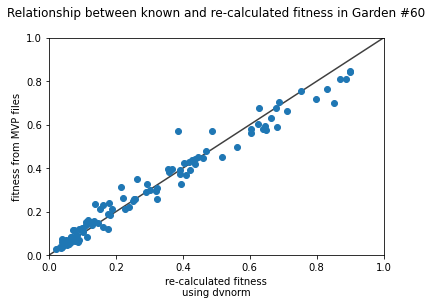


 row = 61


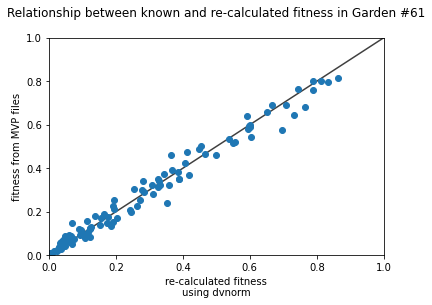


 row = 62


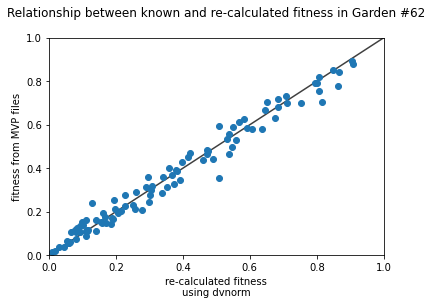


 row = 63


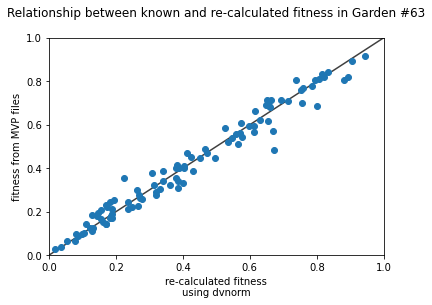


 row = 64


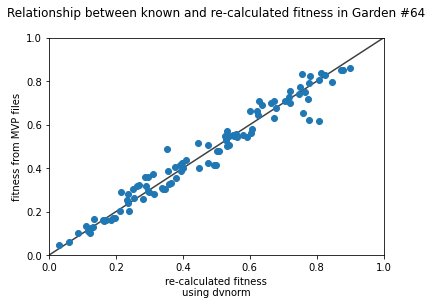


 row = 65


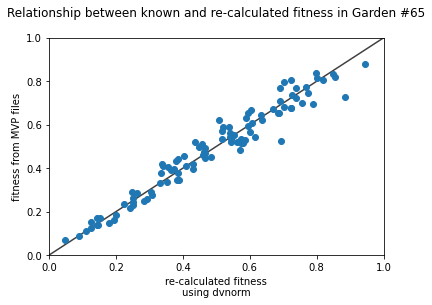


 row = 66


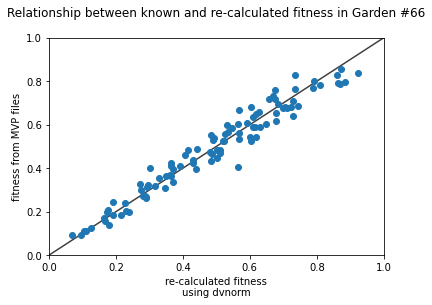


 row = 67


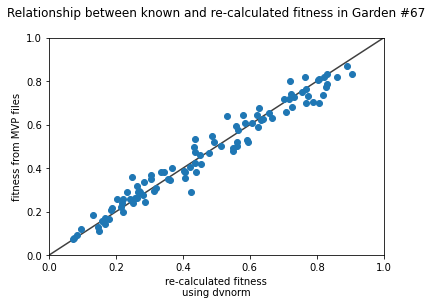


 row = 68


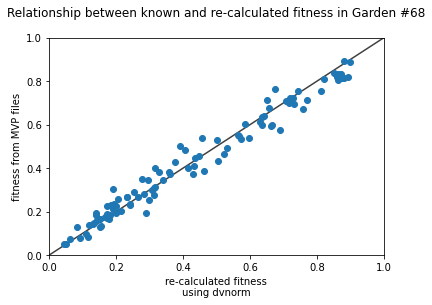


 row = 69


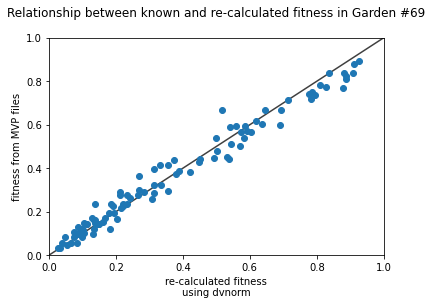


 row = 70


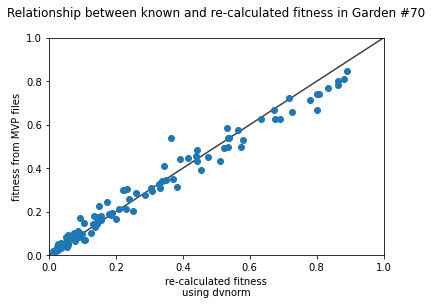


 row = 71


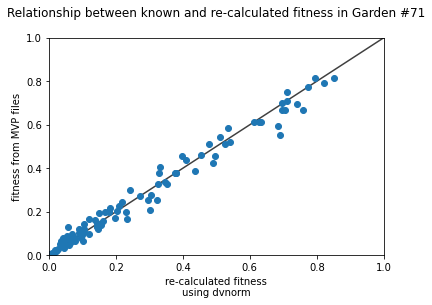


 row = 72


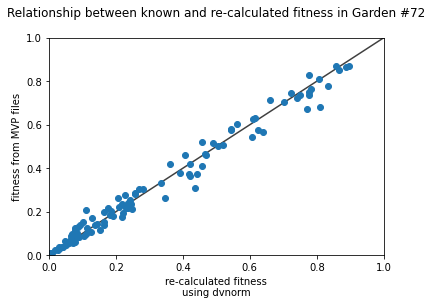


 row = 73


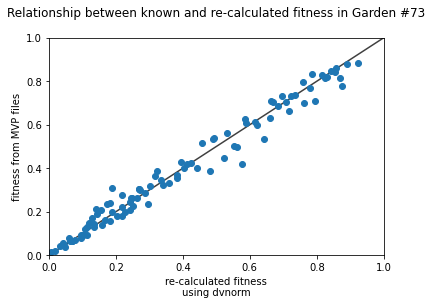


 row = 74


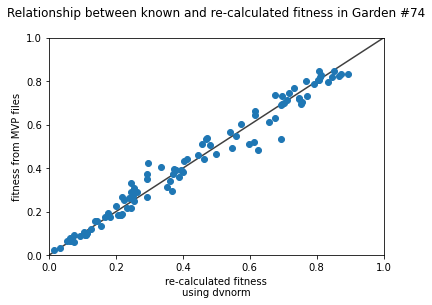


 row = 75


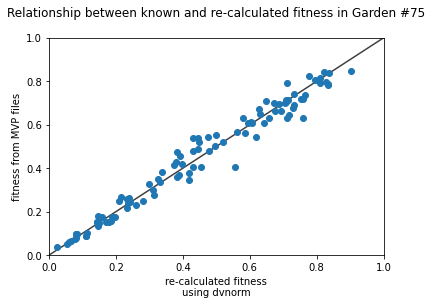


 row = 76


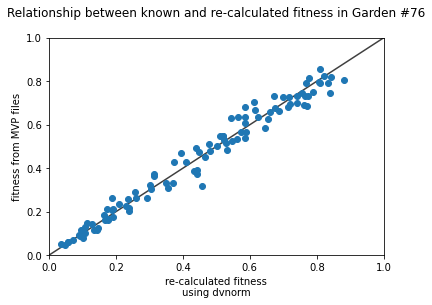


 row = 77


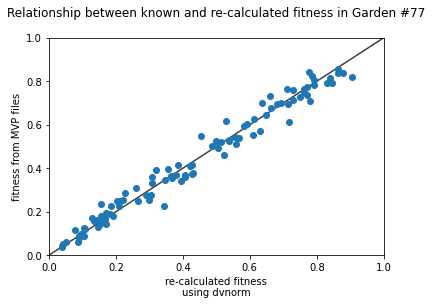


 row = 78


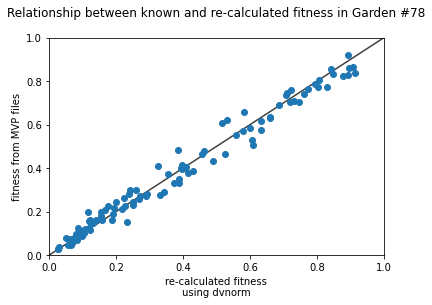


 row = 79


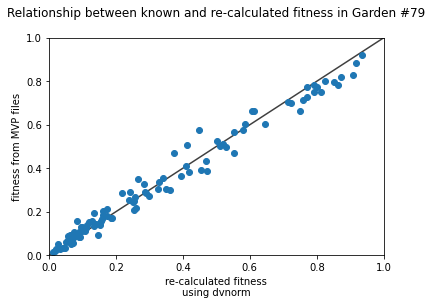


 row = 80


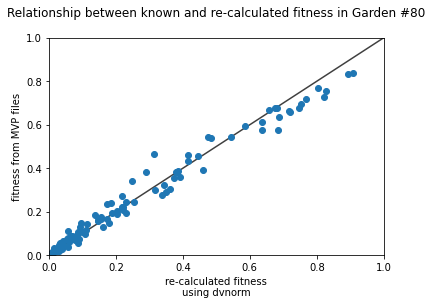


 row = 81


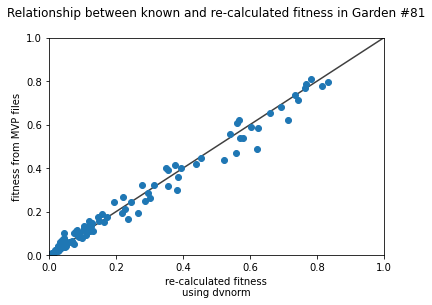


 row = 82


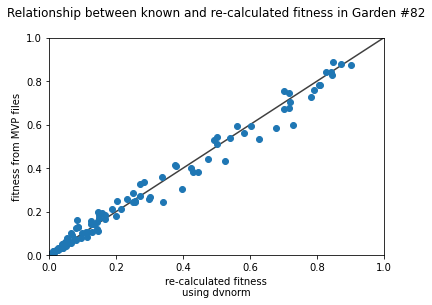


 row = 83


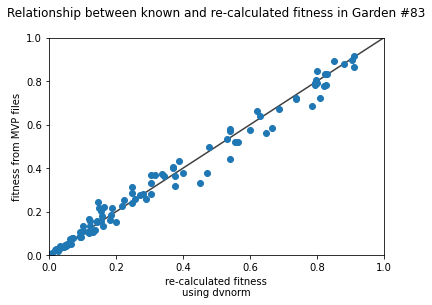


 row = 84


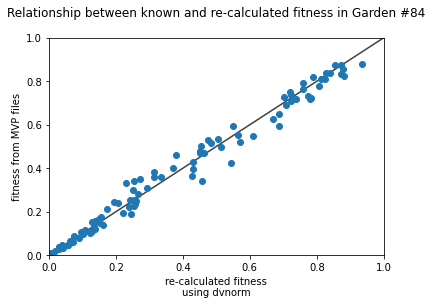


 row = 85


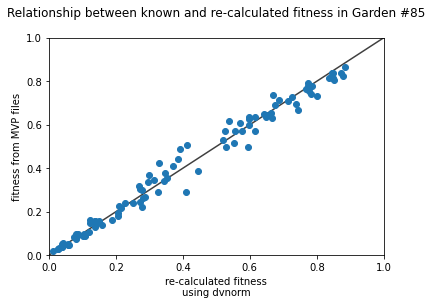


 row = 86


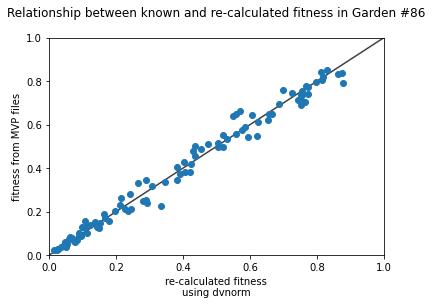


 row = 87


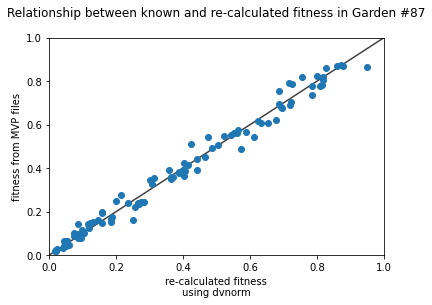


 row = 88


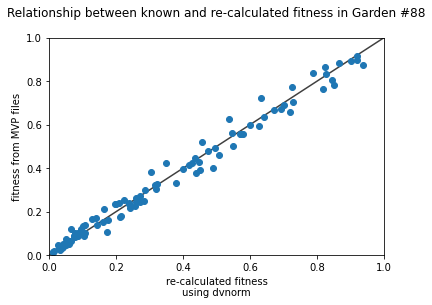


 row = 89


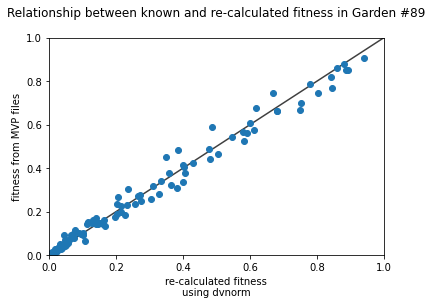


 row = 90


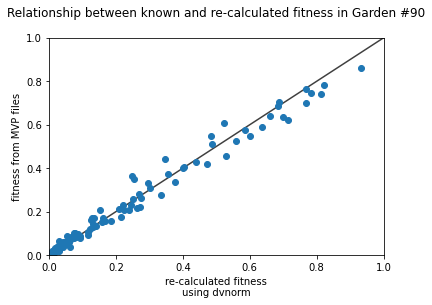


 row = 91


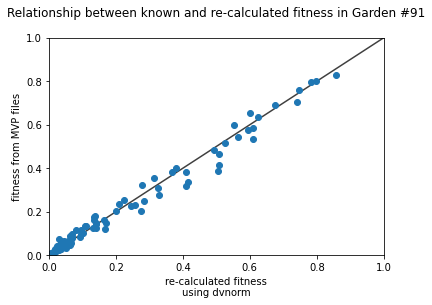


 row = 92


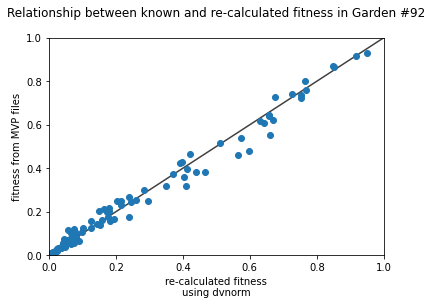


 row = 93


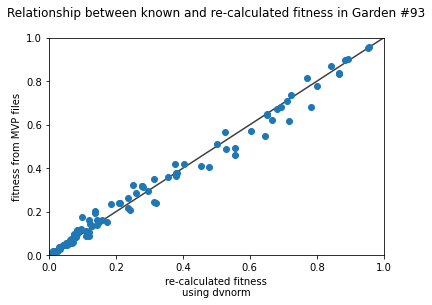


 row = 94


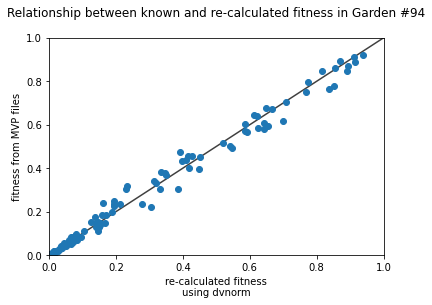


 row = 95


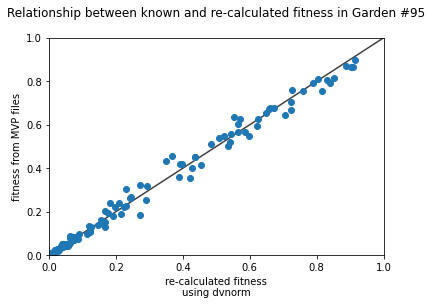


 row = 96


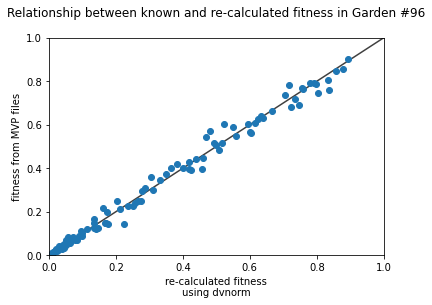


 row = 97


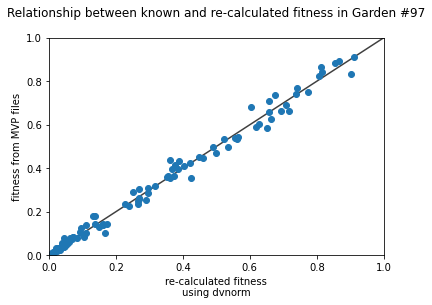


 row = 98


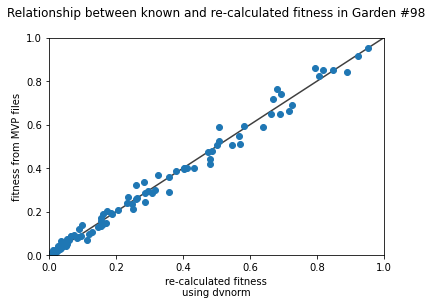


 row = 99


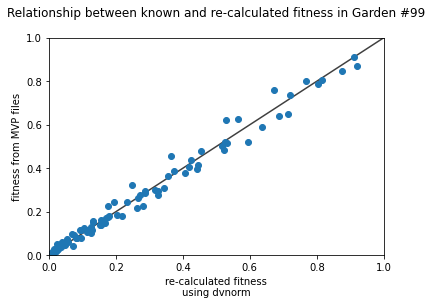


 row = 100


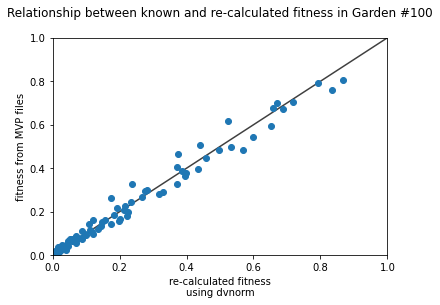

In [16]:
# plot known vs calculated fitness for each garden environment
for row in calcd_fit.index:
    print('\n', f'{row = }')
    plt.scatter(calcd_fit.loc[row], fitness_mat.loc[row])
    plt.xlabel('re-calculated fitness\nusing dvnorm')
    plt.ylabel('fitness from MVP files')
    plt.title(f'Relationship between known and re-calculated fitness in Garden #{row}\n')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot((0, 1), (0, 1), 'k-', alpha=0.75, zorder=0)
    plt.show()



 col = '1'


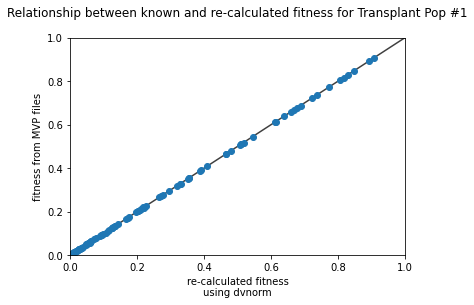


 col = '2'


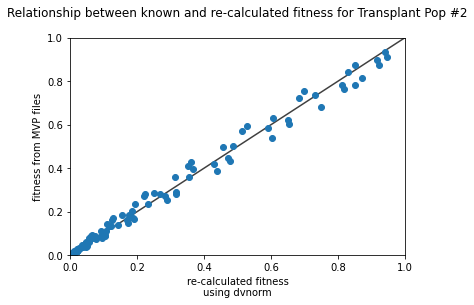


 col = '3'


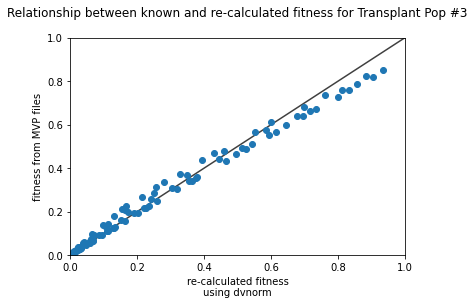


 col = '4'


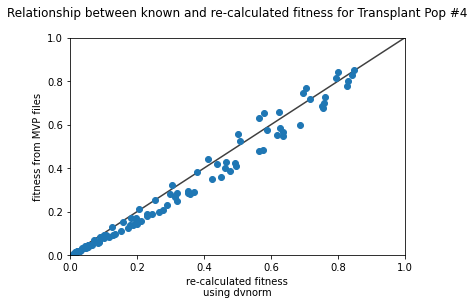


 col = '5'


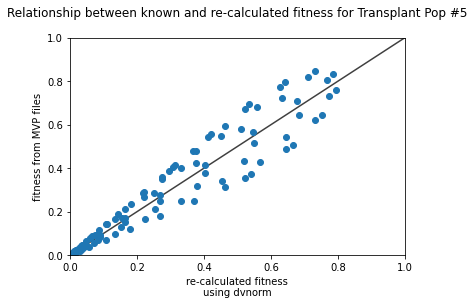


 col = '6'


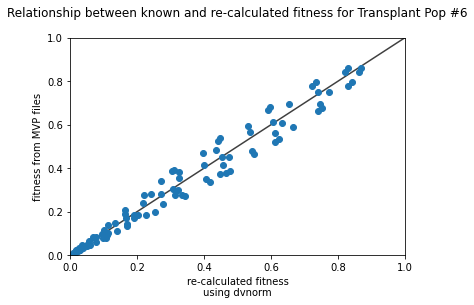


 col = '7'


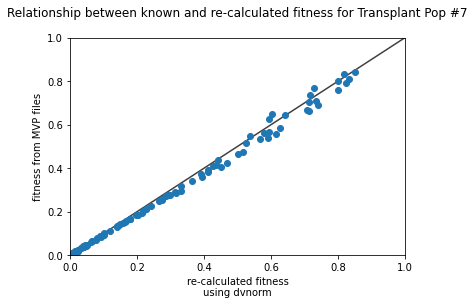


 col = '8'


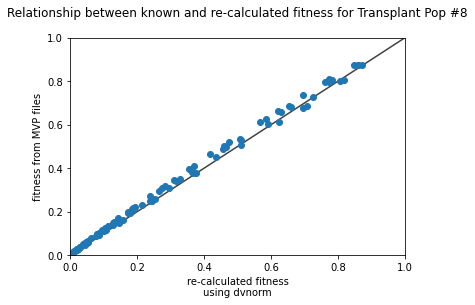


 col = '9'


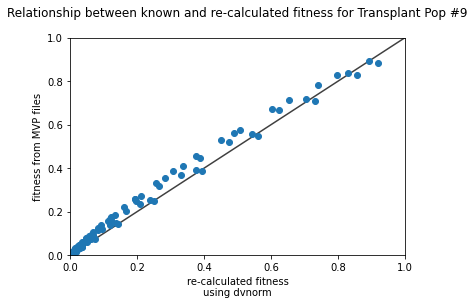


 col = '10'


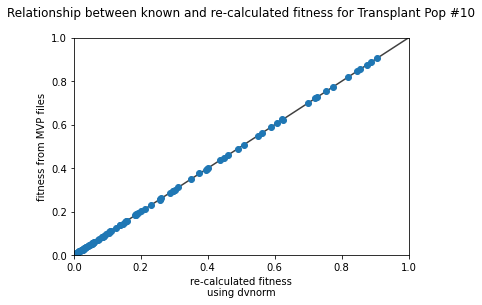


 col = '11'


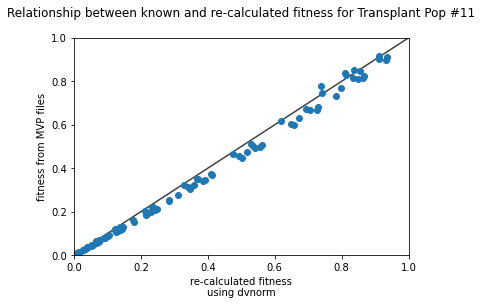


 col = '12'


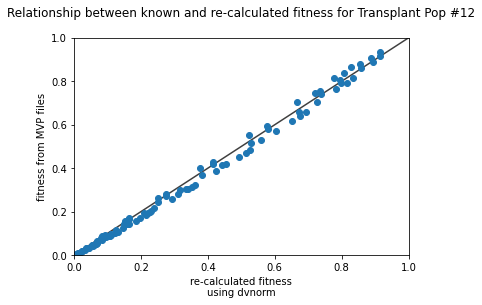


 col = '13'


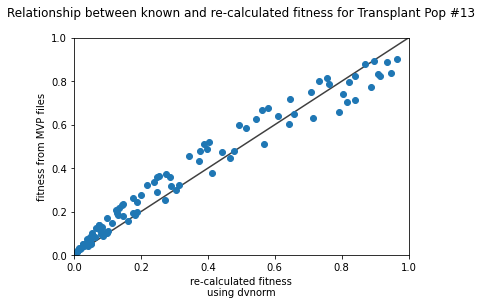


 col = '14'


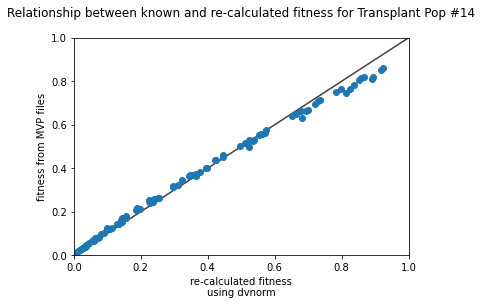


 col = '15'


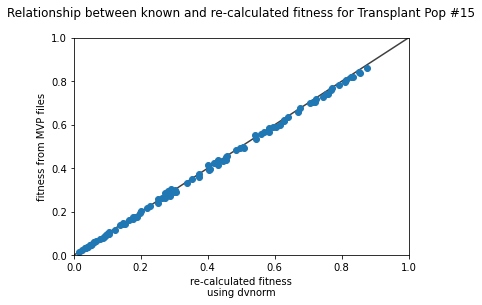


 col = '16'


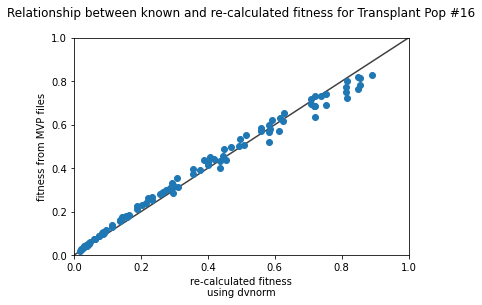


 col = '17'


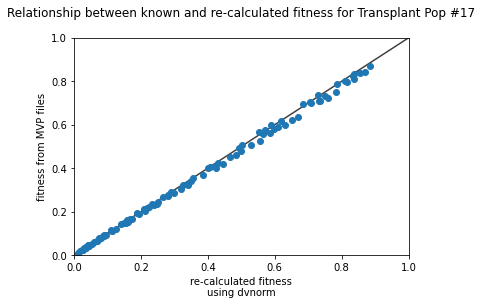


 col = '18'


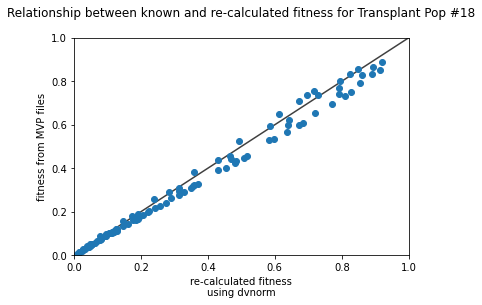


 col = '19'


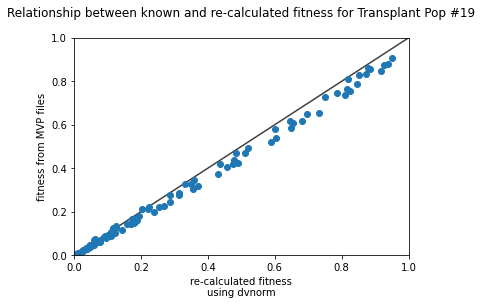


 col = '20'


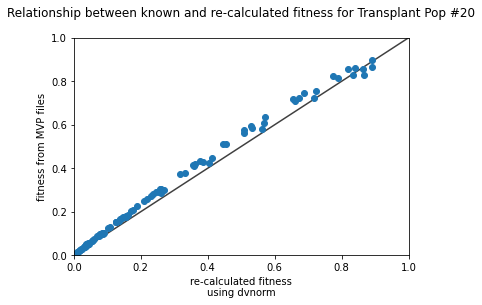


 col = '21'


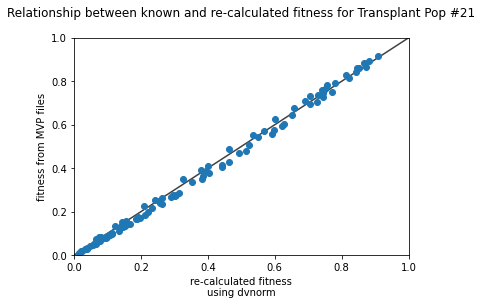


 col = '22'


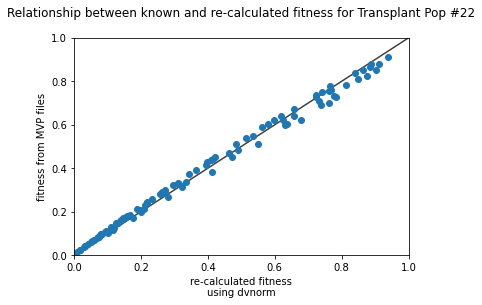


 col = '23'


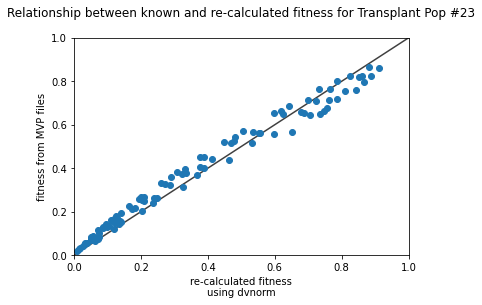


 col = '24'


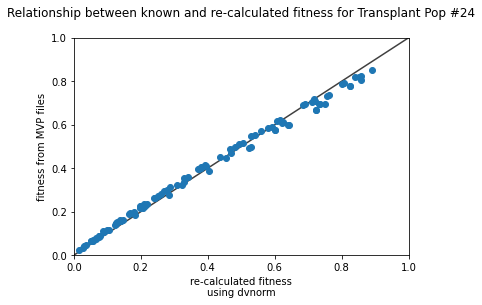


 col = '25'


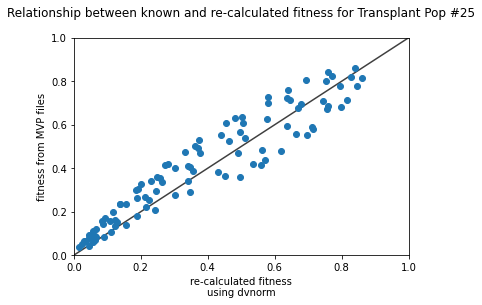


 col = '26'


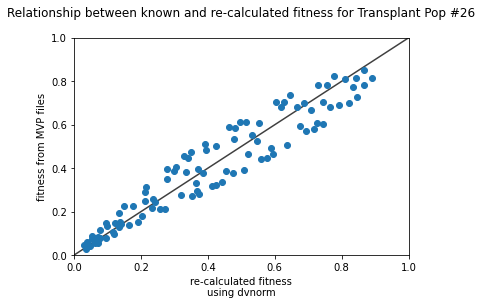


 col = '27'


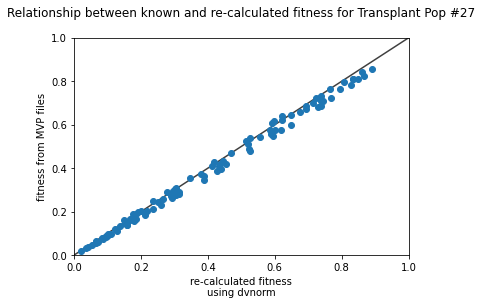


 col = '28'


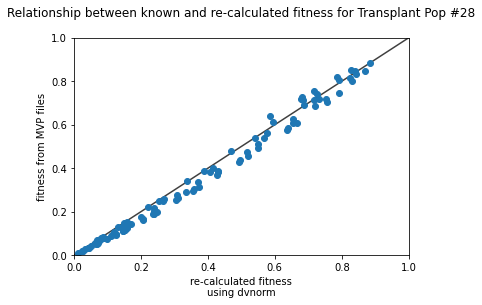


 col = '29'


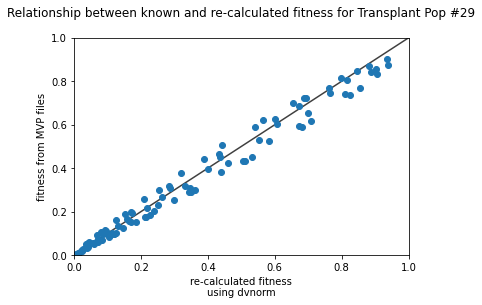


 col = '30'


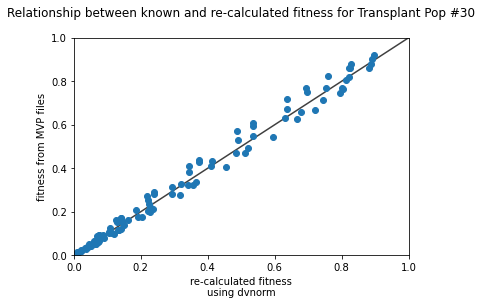


 col = '31'


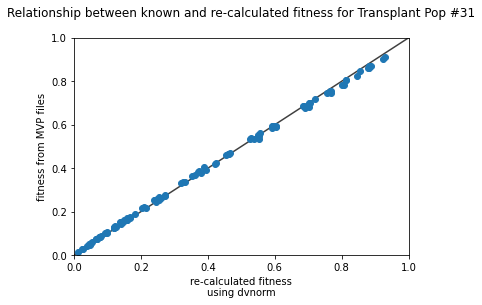


 col = '32'


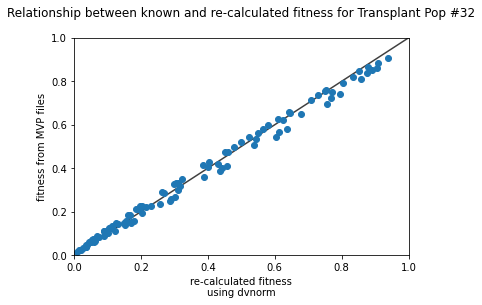


 col = '33'


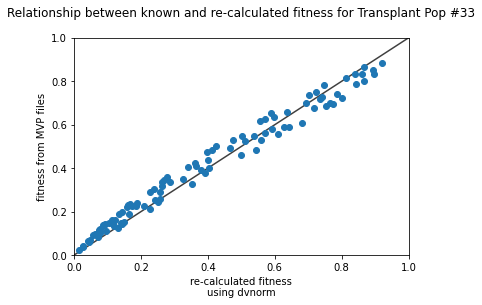


 col = '34'


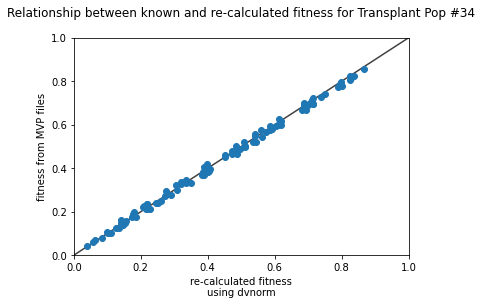


 col = '35'


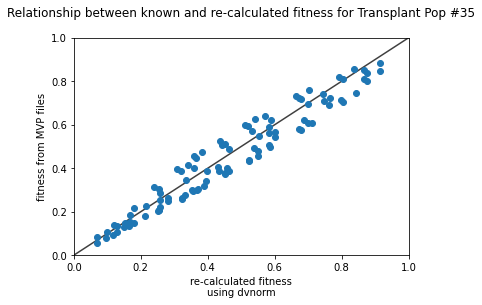


 col = '36'


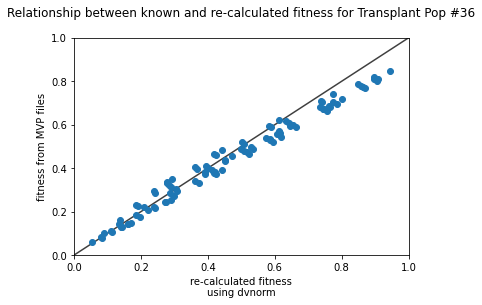


 col = '37'


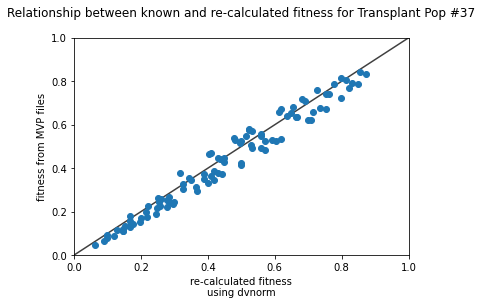


 col = '38'


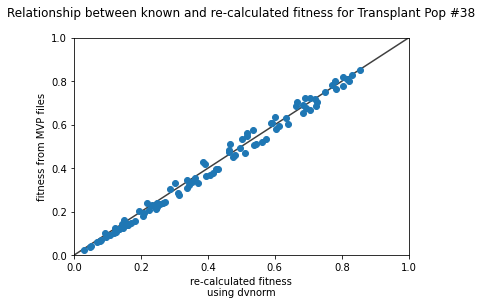


 col = '39'


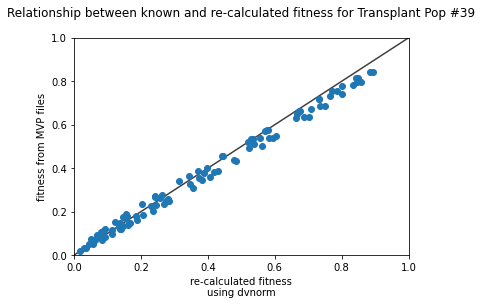


 col = '40'


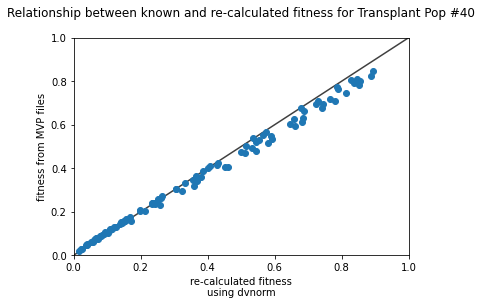


 col = '41'


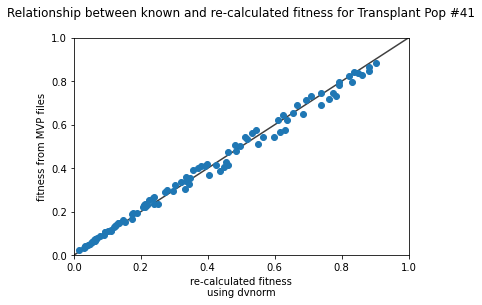


 col = '42'


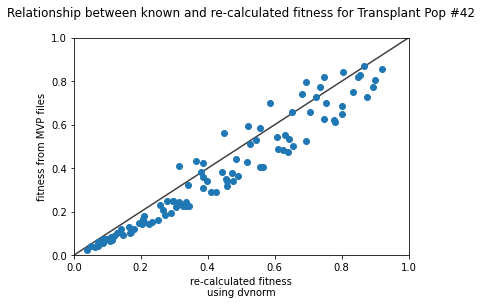


 col = '43'


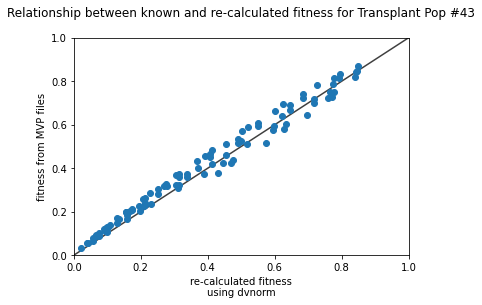


 col = '44'


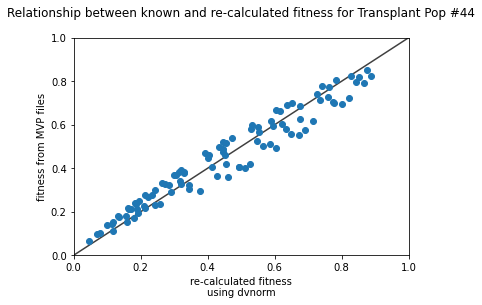


 col = '45'


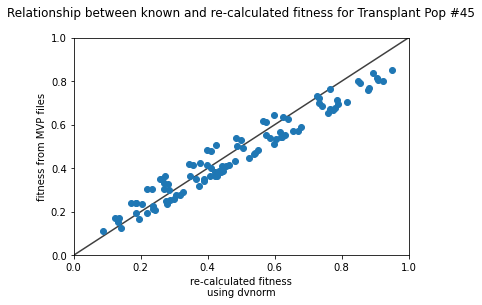


 col = '46'


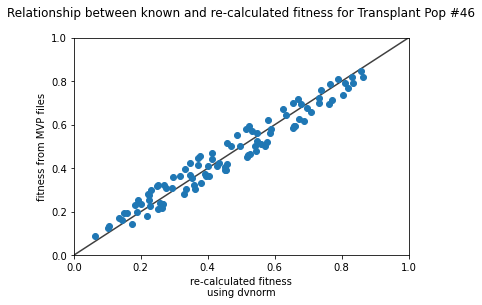


 col = '47'


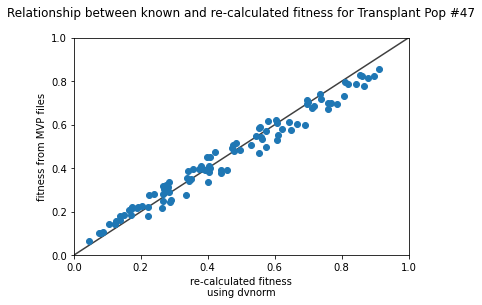


 col = '48'


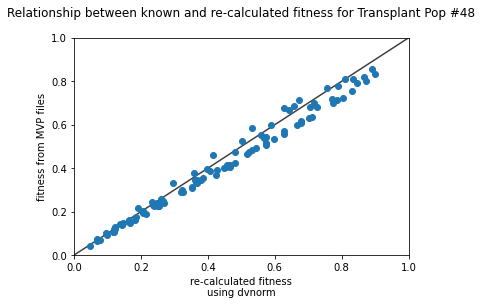


 col = '49'


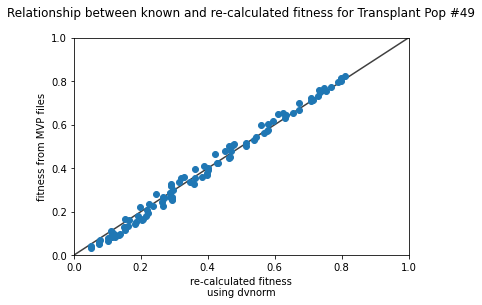


 col = '50'


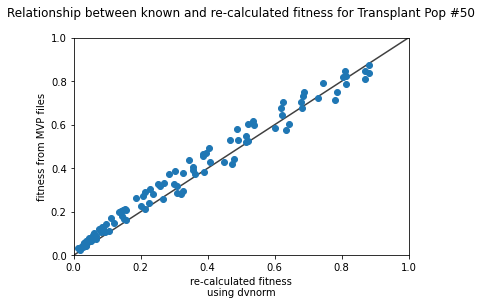


 col = '51'


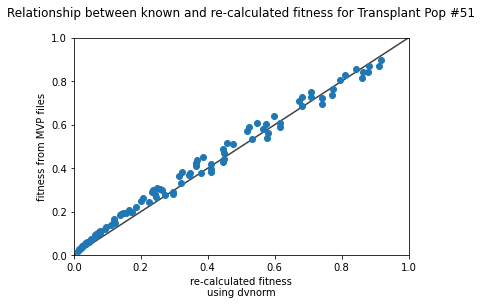


 col = '52'


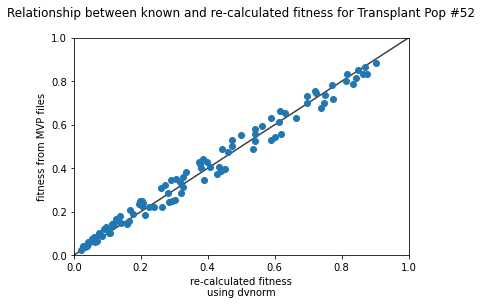


 col = '53'


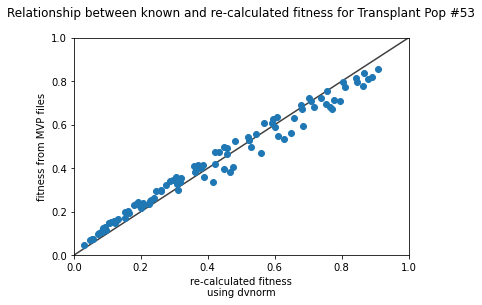


 col = '54'


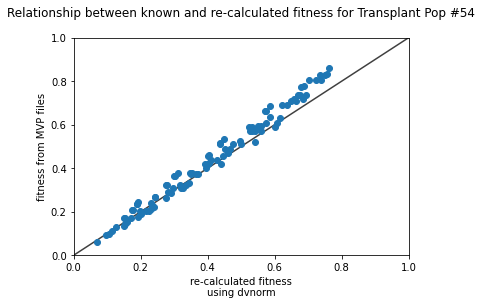


 col = '55'


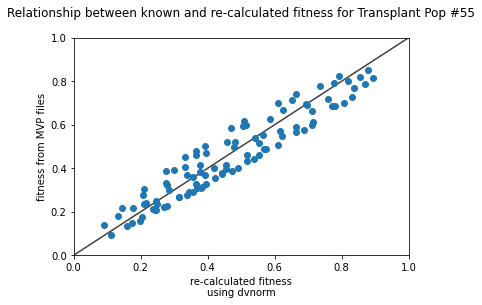


 col = '56'


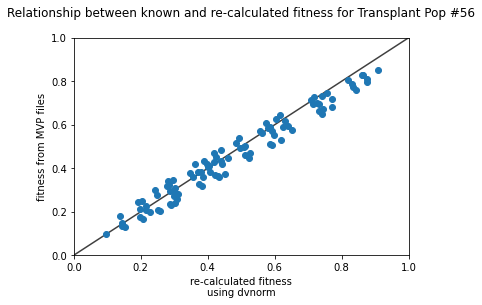


 col = '57'


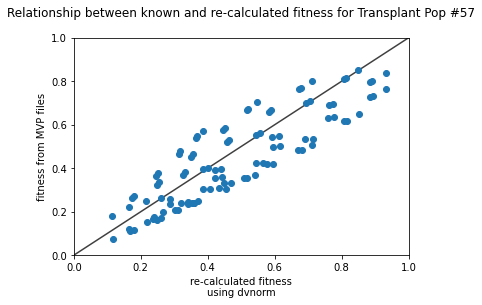


 col = '58'


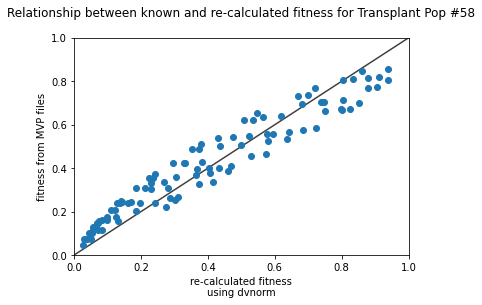


 col = '59'


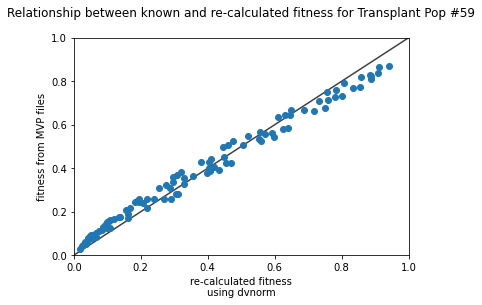


 col = '60'


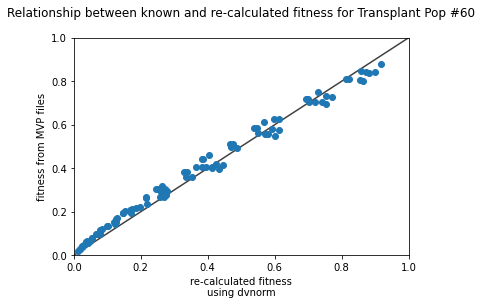


 col = '61'


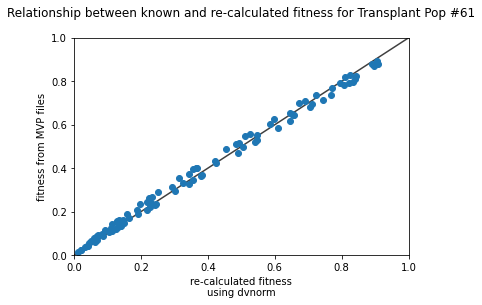


 col = '62'


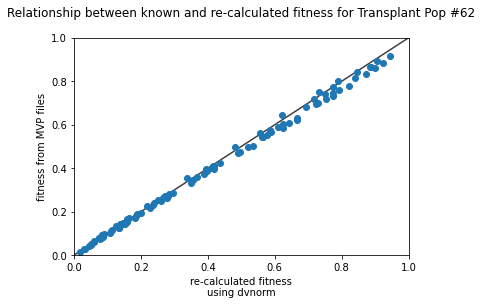


 col = '63'


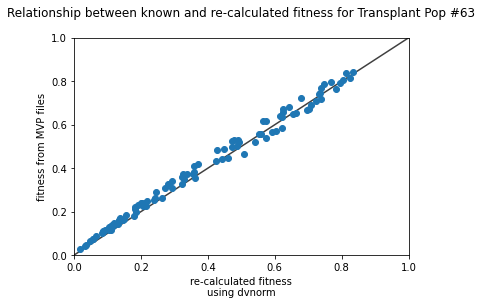


 col = '64'


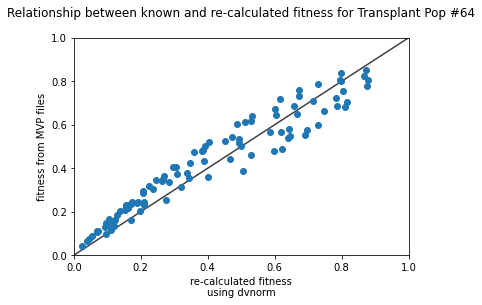


 col = '65'


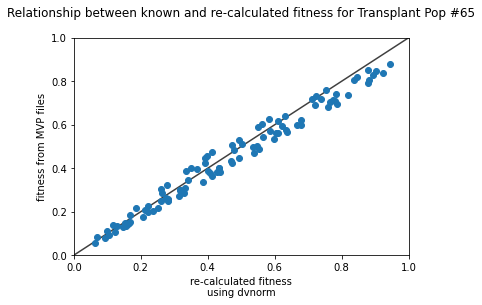


 col = '66'


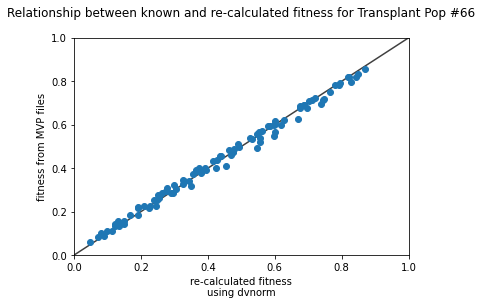


 col = '67'


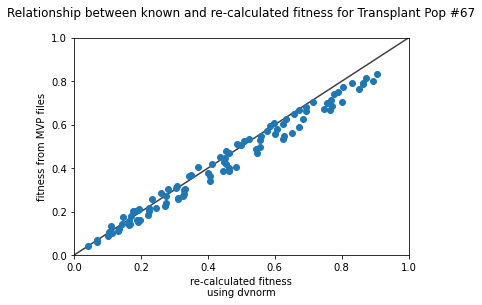


 col = '68'


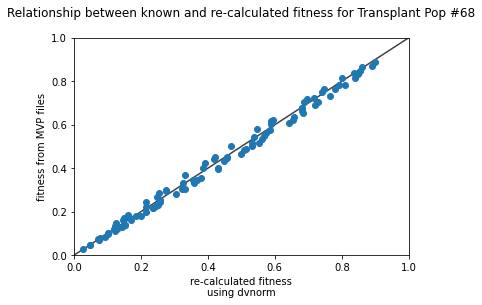


 col = '69'


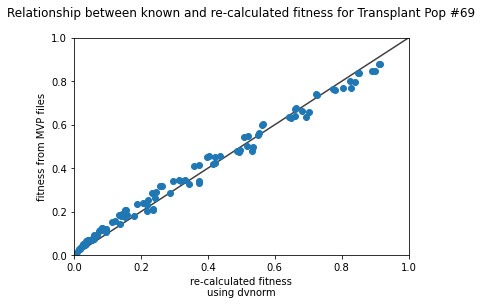


 col = '70'


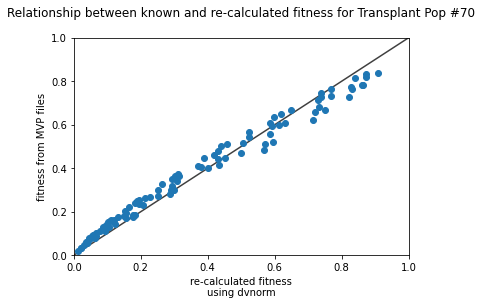


 col = '71'


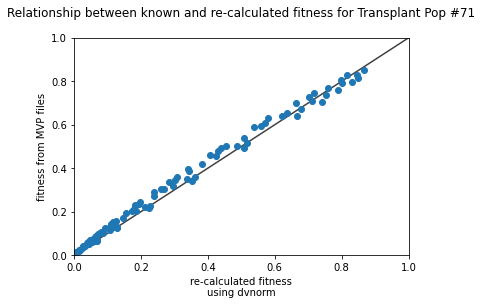


 col = '72'


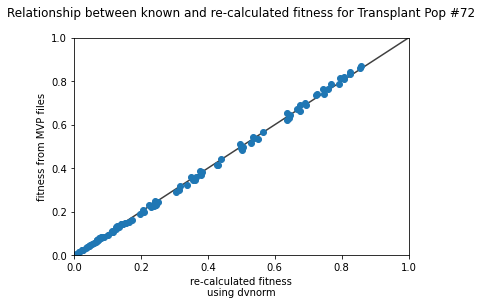


 col = '73'


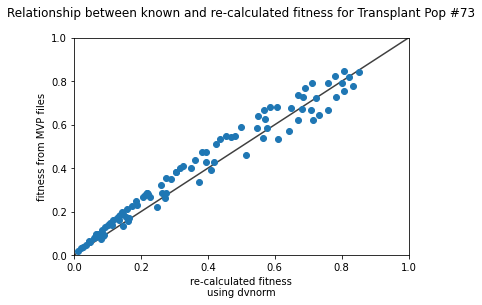


 col = '74'


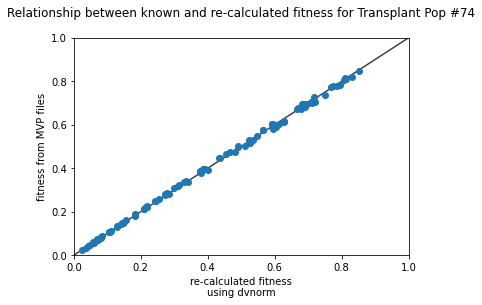


 col = '75'


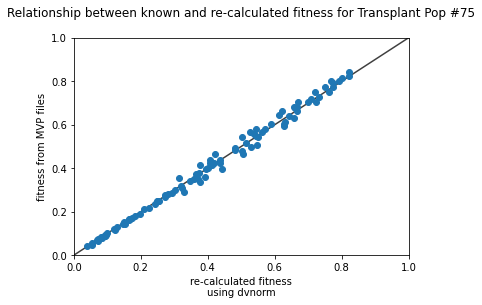


 col = '76'


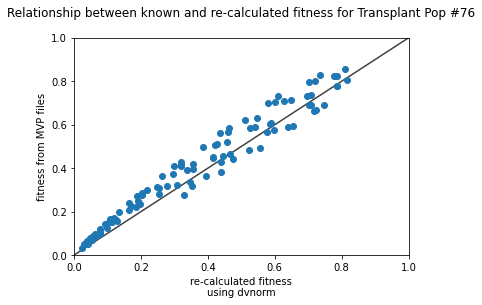


 col = '77'


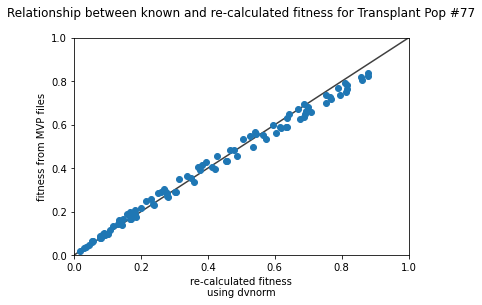


 col = '78'


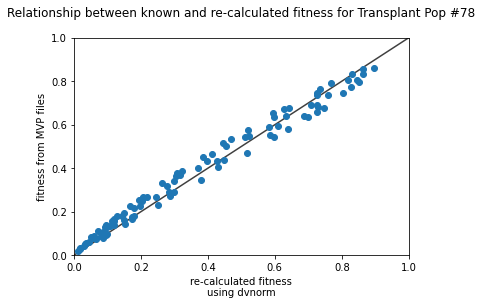


 col = '79'


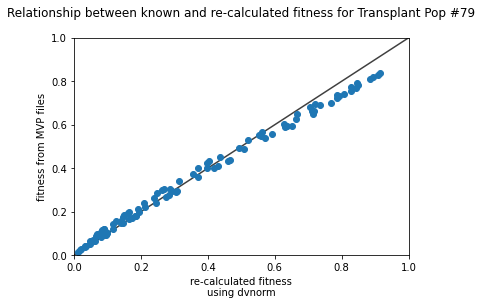


 col = '80'


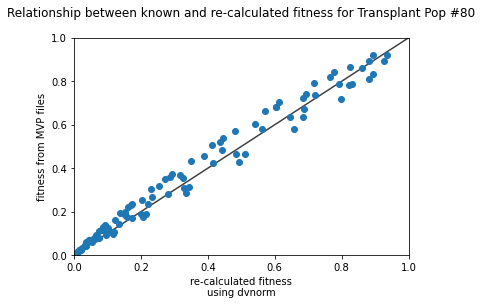


 col = '81'


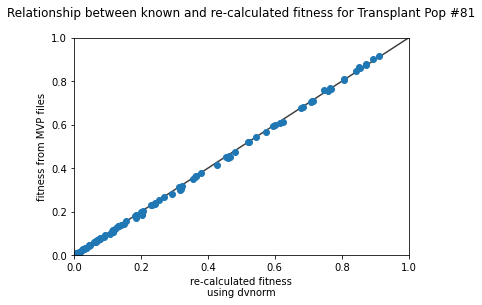


 col = '82'


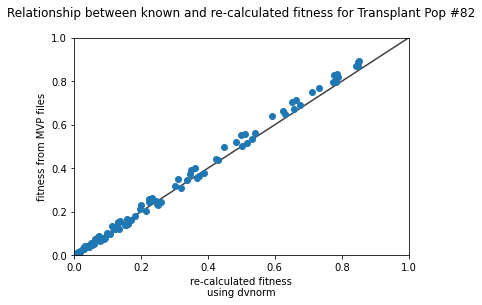


 col = '83'


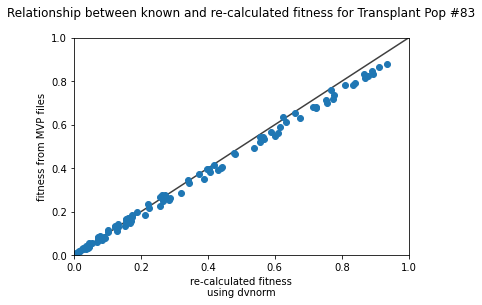


 col = '84'


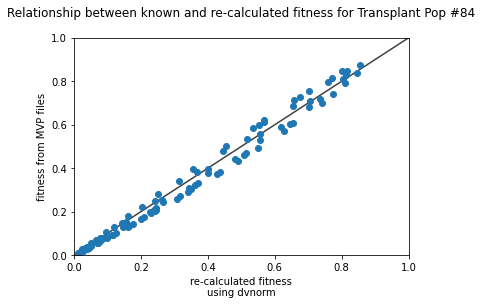


 col = '85'


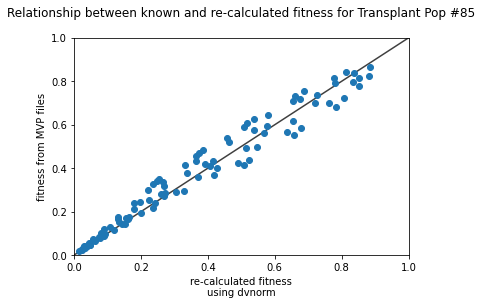


 col = '86'


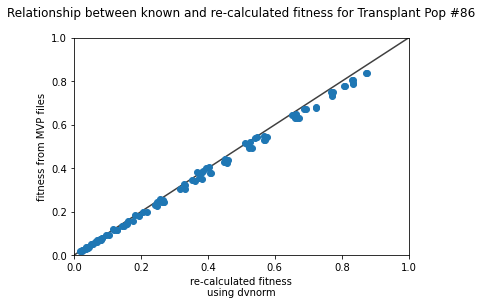


 col = '87'


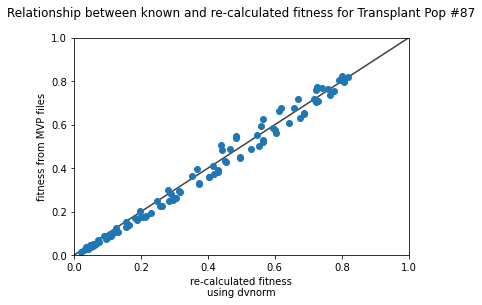


 col = '88'


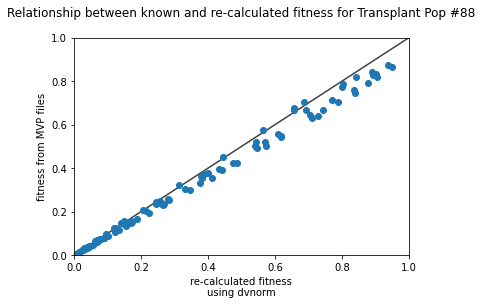


 col = '89'


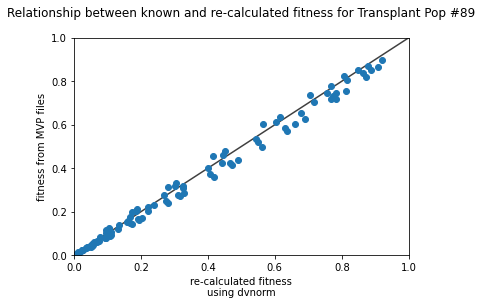


 col = '90'


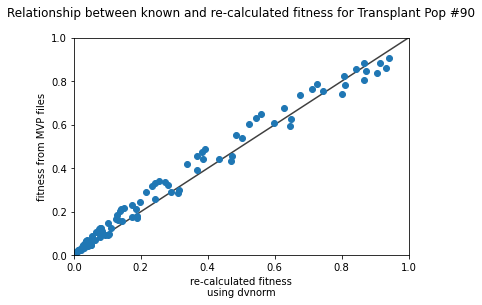


 col = '91'


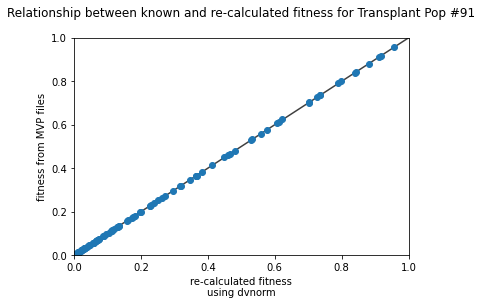


 col = '92'


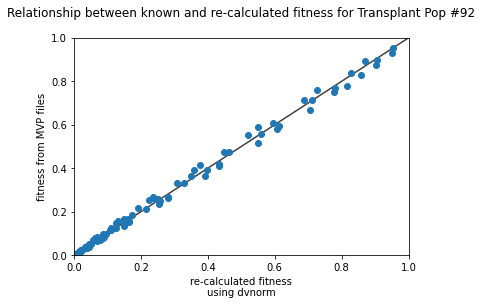


 col = '93'


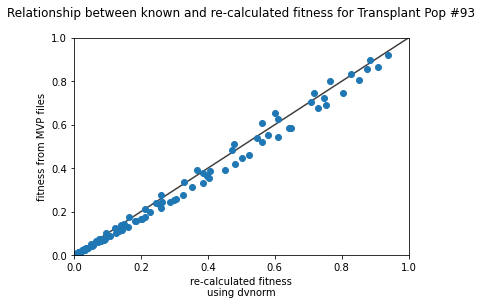


 col = '94'


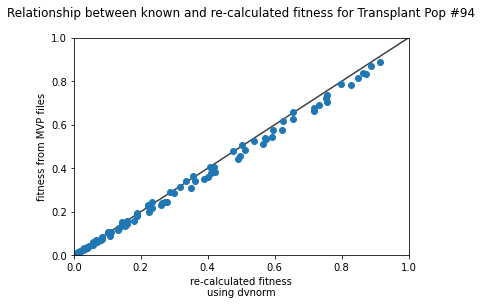


 col = '95'


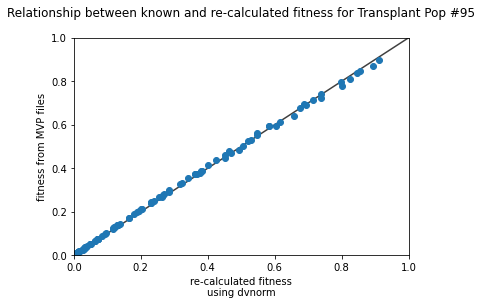


 col = '96'


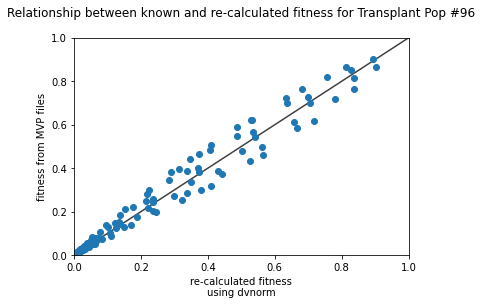


 col = '97'


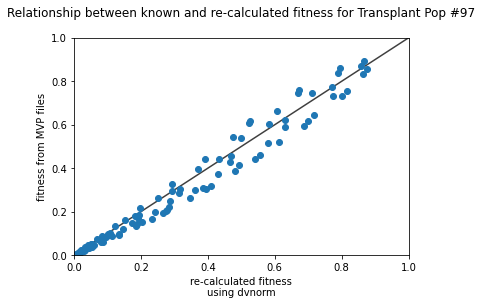


 col = '98'


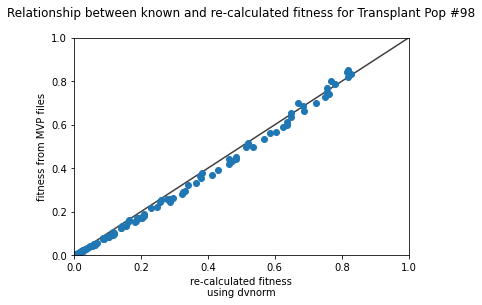


 col = '99'


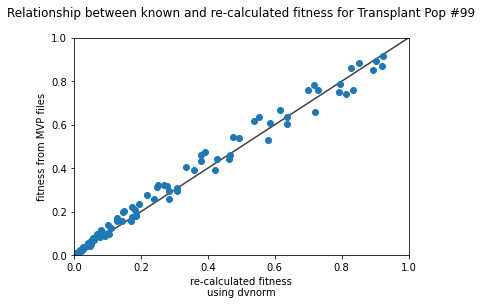


 col = '100'


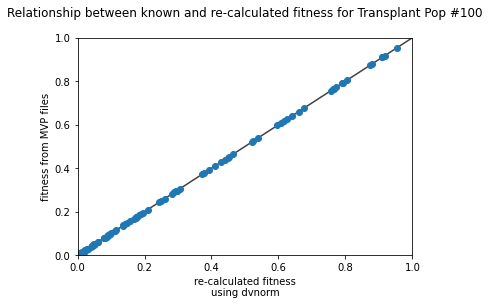

In [17]:
# show known vs calculated fitness across gardens for a specific transplant pop
for col in calcd_fit.columns:
    print('\n', f'{col = }')
    plt.scatter(calcd_fit[col], fitness_mat[col])
    plt.xlabel('re-calculated fitness\nusing dvnorm')
    plt.ylabel('fitness from MVP files')
    plt.title(f'Relationship between known and re-calculated fitness for Transplant Pop #{col}\n')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot((0, 1), (0, 1), 'k-', alpha=0.75, zorder=0)
    plt.show()

In [18]:
# show population locations

import MVP_03_validate_gradient_forests as mvp03

subset, locations, envdata = mvp06.get_pop_data(slimdir, seed_2trait)

df = mvp03.blank_dataframe()

for pop, (long, lat) in locations.iterrows():
    df.loc[lat, long] = pop
    
df.astype(int)


Reading in info for subsampled individuals ...


1   2   3   4   5   6   7   8   9    10
10  91  92  93  94  95  96  97  98  99  100
9   81  82  83  84  85  86  87  88  89   90
8   71  72  73  74  75  76  77  78  79   80
7   61  62  63  64  65  66  67  68  69   70
6   51  52  53  54  55  56  57  58  59   60
5   41  42  43  44  45  46  47  48  49   50
4   31  32  33  34  35  36  37  38  39   40
3   21  22  23  24  25  26  27  28  29   30
2   11  12  13  14  15  16  17  18  19   20
1    1   2   3   4   5   6   7   8   9   10

# 1-trait seed

In [19]:
del seed_2trait

In [20]:
slimdir = '/work/lotterhos/MVP-NonClinalAF/sim_output_20220428/'

subset = mvp01.read_ind_data(slimdir, seed_1trait)
envdata = subset.groupby('subpopID')[['opt0', 'opt1']].apply(np.mean)


jobs = []
args = []
for pop, (opt0, opt1) in envdata.iterrows():
    output_file = op.join(tmp_dir, f'{seed_1trait}_{str(pop).zfill(3)}_fitness.txt')
    
    arg = (seed_1trait, output_file, opt1)  # this time leave out opt0
    args.append(arg)
    
    jobs.append(
        lview.apply_async(
            calc_R_fitness, *(arg)
        )
    )
    
watch_async(jobs)


Reading in info for subsampled individuals ...

Watching 100 jobs ...


100%|███████████████| 100/100 [00:02<00:00, 34.39it/s]


In [21]:
jobs[0].r

In [22]:
dfs = []
for f in pbar(sorted(fs(tmp_dir, startswith=seed_1trait))):
    seed, pop, *_ = op.basename(f).split("_")
    
    df = pd.read_table(f)
    df.index = [int(pop)]
    
    dfs.append(df)
    
del seed

calcd_fit = pd.concat(dfs)

calcd_fit

100%|███████████████| 100/100 [00:00<00:00, 224.90it/s]


1      2     3      4      5      6     7      8      9     10  \
1    0.983  0.976  0.96  0.986  0.984  0.988  0.96  0.904  0.982  0.923   
2    0.983  0.976  0.96  0.986  0.984  0.988  0.96  0.904  0.982  0.923   
3    0.983  0.976  0.96  0.986  0.984  0.988  0.96  0.904  0.982  0.923   
4    0.983  0.976  0.96  0.986  0.984  0.988  0.96  0.904  0.982  0.923   
5    0.983  0.976  0.96  0.986  0.984  0.988  0.96  0.904  0.982  0.923   
..     ...    ...   ...    ...    ...    ...   ...    ...    ...    ...   
96   0.000  0.000  0.00  0.000  0.000  0.000  0.00  0.002  0.000  0.001   
97   0.000  0.000  0.00  0.000  0.000  0.000  0.00  0.002  0.000  0.001   
98   0.000  0.000  0.00  0.000  0.000  0.000  0.00  0.002  0.000  0.001   
99   0.000  0.000  0.00  0.000  0.000  0.000  0.00  0.002  0.000  0.001   
100  0.000  0.000  0.00  0.000  0.000  0.000  0.00  0.002  0.000  0.001   

        11     12     13     14     15     16     17     18     19     20  \
1    0.803  0.837  0.793  0.916  0.883  0.916  0.858  0.925  0.775  0.764   
2    0.803  0.837  0.793  0.916  0.883  0.916  0.858  0.925  0.775  0.764   
3    0.803  0.837  0.793  0.916  0.883  0.916  0.858  0.925  0.775  0.764   
4    0.803  0.837  0.793  0.916  0.883  0.916  0.858  0.925  0.775  0.764   
5    0.803  0.837  0.793  0.916  0.883  0.916  0.858  0.925  0.775  0.764   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.004  0.003  0.003  0.000  0.001  0.000  0.001  0.000  0.004  0.005   
97   0.004  0.003  0.003  0.000  0.001  0.000  0.001  0.000  0.004  0.005   
98   0.004  0.003  0.003  0.000  0.001  0.000  0.001  0.000  0.004  0.005   
99   0.004  0.003  0.003  0.000  0.001  0.000  0.001  0.000  0.004  0.005   
100  0.004  0.003  0.003  0.000  0.001  0.000  0.001  0.000  0.004  0.005   

        21     22     23     24     25     26     27     28     29     30  \
1    0.661  0.615  0.663  0.663  0.604  0.608  0.712  0.616  0.721  0.737   
2    0.661  0.615  0.663  0.663  0.604  0.608  0.712  0.616  0.721  0.737   
3    0.661  0.615  0.663  0.663  0.604  0.608  0.712  0.616  0.721  0.737   
4    0.661  0.615  0.663  0.663  0.604  0.608  0.712  0.616  0.721  0.737   
5    0.661  0.615  0.663  0.663  0.604  0.608  0.712  0.616  0.721  0.737   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.011  0.012  0.012  0.010  0.014  0.012  0.007  0.011  0.007  0.009   
97   0.011  0.012  0.012  0.010  0.014  0.012  0.007  0.011  0.007  0.009   
98   0.011  0.012  0.012  0.010  0.014  0.012  0.007  0.011  0.007  0.009   
99   0.011  0.012  0.012  0.010  0.014  0.012  0.007  0.011  0.007  0.009   
100  0.011  0.012  0.012  0.010  0.014  0.012  0.007  0.011  0.007  0.009   

        31     32     33     34     35     36     37     38     39     40  \
1    0.428  0.495  0.441  0.419  0.414  0.387  0.426  0.497  0.335  0.515   
2    0.428  0.495  0.441  0.419  0.414  0.387  0.426  0.497  0.335  0.515   
3    0.428  0.495  0.441  0.419  0.414  0.387  0.426  0.497  0.335  0.515   
4    0.428  0.495  0.441  0.419  0.414  0.387  0.426  0.497  0.335  0.515   
5    0.428  0.495  0.441  0.419  0.414  0.387  0.426  0.497  0.335  0.515   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
96   0.031  0.023  0.038  0.035  0.033  0.052  0.035  0.025  0.047  0.029   
97   0.031  0.023  0.038  0.035  0.033  0.052  0.035  0.025  0.047  0.029   
98   0.031  0.023  0.038  0.035  0.033  0.052  0.035  0.025  0.047  0.029   
99   0.031  0.023  0.038  0.035  0.033  0.052  0.035  0.025  0.047  0.029   
100  0.031  0.023  0.038  0.035  0.033  0.052  0.035  0.025  0.047  0.029   

        41     42     43     44     45     46     47     48     49     50  \
1    0.183  0.193  0.172  0.208  0.263  0.211  0.238  0.181  0.239  0.198   
2    0.183  0.193  0.172  0.208  0.263  0.211  0.238  0.181  0.239  0.198   
3    0.183  0.193  0.172  0.208  0.263  0.211  0.238  0.181  0.239  0.198   
4    0.183  0.193  0.172 

Text(0, 0.5, 'recalculated fitness of\nsubpopID=1 in garden_x')

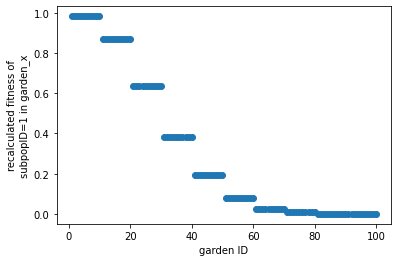

In [23]:
plt.scatter(calcd_fit.index, calcd_fit['1'])
plt.xlabel('garden ID')
plt.ylabel('recalculated fitness of\nsubpopID=1 in garden_x')

In [24]:
# load MVP fitness mat
fitness_mat = mvp06.load_pooled_fitness_matrix(slimdir, seed_1trait)

fitness_mat

1         2         3         4         5         6         7  \
1    0.981829  0.972983  0.971592  0.971978  0.963576  0.983601  0.961269   
2    0.981829  0.972983  0.971592  0.971978  0.963576  0.983601  0.961269   
3    0.981829  0.972983  0.971592  0.971978  0.963576  0.983601  0.961269   
4    0.981829  0.972983  0.971592  0.971978  0.963576  0.983601  0.961269   
5    0.981829  0.972983  0.971592  0.971978  0.963576  0.983601  0.961269   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.000326  0.000527  0.000322  0.000517  0.000531  0.000464  0.000631   
97   0.000326  0.000527  0.000322  0.000517  0.000531  0.000464  0.000631   
98   0.000326  0.000527  0.000322  0.000517  0.000531  0.000464  0.000631   
99   0.000326  0.000527  0.000322  0.000517  0.000531  0.000464  0.000631   
100  0.000326  0.000527  0.000322  0.000517  0.000531  0.000464  0.000631   

            8         9        10        11        12        13        14  \
1    0.944760  0.971262  0.922845  0.815326  0.880144  0.830514  0.902101   
2    0.944760  0.971262  0.922845  0.815326  0.880144  0.830514  0.902101   
3    0.944760  0.971262  0.922845  0.815326  0.880144  0.830514  0.902101   
4    0.944760  0.971262  0.922845  0.815326  0.880144  0.830514  0.902101   
5    0.944760  0.971262  0.922845  0.815326  0.880144  0.830514  0.902101   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.001179  0.000775  0.001854  0.004918  0.002614  0.003831  0.002098   
97   0.001179  0.000775  0.001854  0.004918  0.002614  0.003831  0.002098   
98   0.001179  0.000775  0.001854  0.004918  0.002614  0.003831  0.002098   
99   0.001179  0.000775  0.001854  0.004918  0.002614  0.003831  0.002098   
100  0.001179  0.000775  0.001854  0.004918  0.002614  0.003831  0.002098   

           15        16        17        18        19        20        21  \
1    0.849657  0.897899  0.852221  0.867815  0.811225  0.797112  0.674265   
2    0.849657  0.897899  0.852221  0.867815  0.811225  0.797112  0.674265   
3    0.849657  0.897899  0.852221  0.867815  0.811225  0.797112  0.674265   
4    0.849657  0.897899  0.852221  0.867815  0.811225  0.797112  0.674265   
5    0.849657  0.897899  0.852221  0.867815  0.811225  0.797112  0.674265   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.003366  0.002126  0.003314  0.003054  0.004516  0.004623  0.009196   
97   0.003366  0.002126  0.003314  0.003054  0.004516  0.004623  0.009196   
98   0.003366  0.002126  0.003314  0.003054  0.004516  0.004623  0.009196   
99   0.003366  0.002126  0.003314  0.003054  0.004516  0.004623  0.009196   
100  0.003366  0.002126  0.003314  0.003054  0.004516  0.004623  0.009196   

           22        23        24        25        26        27        28  \
1    0.652039  0.696471  0.671620  0.656199  0.648764  0.681563  0.662927   
2    0.652039  0.696471  0.671620  0.656199  0.648764  0.681563  0.662927   
3    0.652039  0.696471  0.671620  0.656199  0.648764  0.681563  0.662927   
4    0.652039  0.696471  0.671620  0.656199  0.648764  0.681563  0.662927   
5    0.652039  0.696471  0.671620  0.656199  0.648764  0.681563  0.662927   
..        ...       ...       ...       ...       ...       ...       ...   
96   0.010492  0.009204  0.011224  0.011831  0.011289  0.010169  0.010657   
97   0.010492  0.009204  0.011224  0.011831  0.011289  0.010169  0.010657   
98   0.010492  0.009204  0.011224  0.011831  0.011289  0.010169  0.010657   
99   0.010492  0.009204  0.011224  0.011831  0.011289  0.010169  0.010657   
100  0.010492  0.009204  0.011224  0.011831  0.011289  0.010169  0.010657   

           29        30        31        32        33        34        35  \
1    0.706118  0.670051  0.482991  0.443052  0.453153  0.414064  0.408325   
2    0.706118  0.670051  0.482991  0.443052  0.453153  0.414064  0.408325   
3    0.706118  0.670051  0.482991  0.443052  0.453153  0.414064  0.408325   
4   

Text(0, 0.5, 'fitness of subpopID=1 in garden_x')

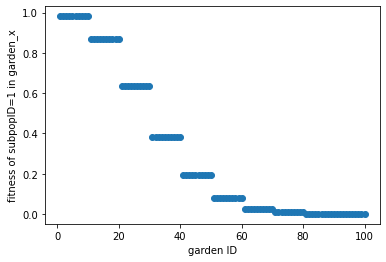

In [25]:
plt.scatter(fitness_mat.index, fitness_mat['1'])
plt.xlabel('garden ID')
plt.ylabel('fitness of subpopID=1 in garden_x')

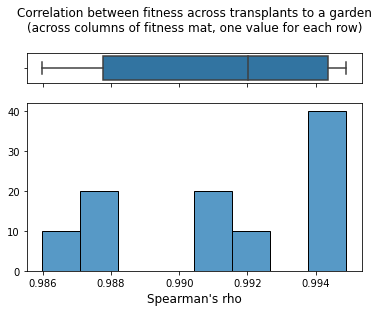

In [26]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=1, method='spearman'),
    title='Correlation between fitness across transplants to a garden\n(across columns of fitness mat, one value for each row)\n',
    xlab="Spearman's rho"
)


plt.show()

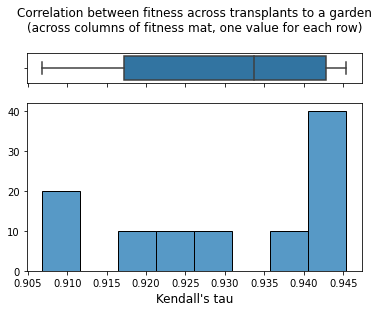

In [27]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=1, method='kendall'),
    title='Correlation between fitness across transplants to a garden\n(across columns of fitness mat, one value for each row)\n',
    xlab="Kendall's tau"
)


plt.show()

### histograms of correlations for fitness from a specific source population

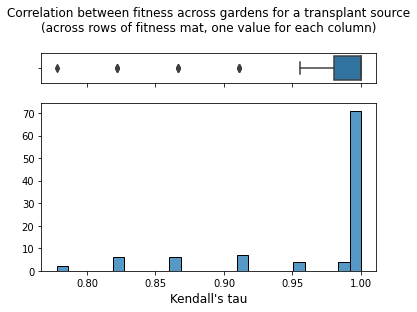

In [28]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=0, method='kendall'),
    title='Correlation between fitness across gardens for a transplant source\n(across rows of fitness mat, one value for each column)\n',
    xlab="Kendall's tau"
)

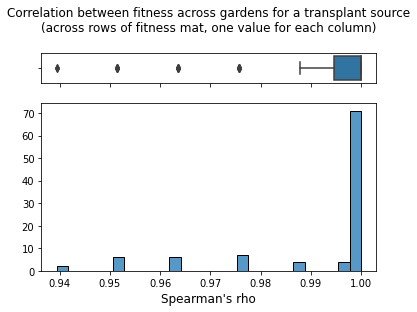

In [29]:
ax_box, ax_hist = histo_box(
    calcd_fit.corrwith(fitness_mat, axis=0, method='spearman'),
    title='Correlation between fitness across gardens for a transplant source\n(across rows of fitness mat, one value for each column)\n',
    xlab="Spearman's rho"
)

### Scatter plots of known vs re-calculated fitness


 row = 1


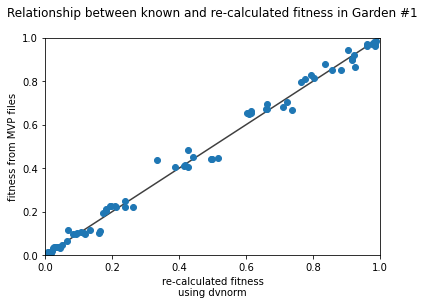


 row = 2


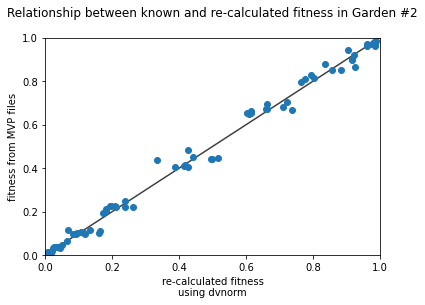


 row = 3


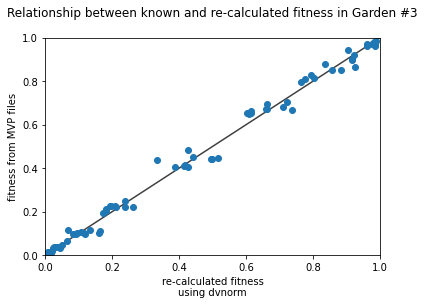


 row = 4


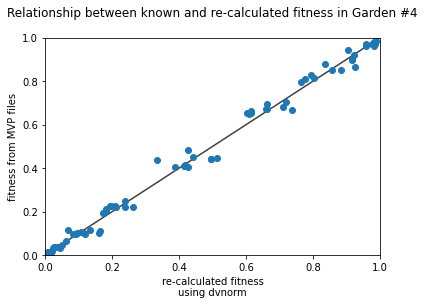


 row = 5


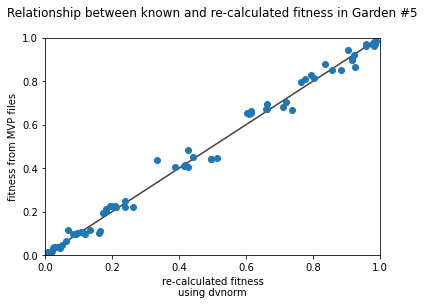


 row = 6


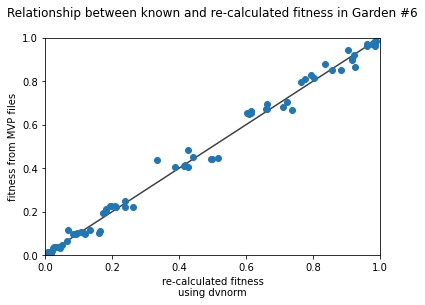


 row = 7


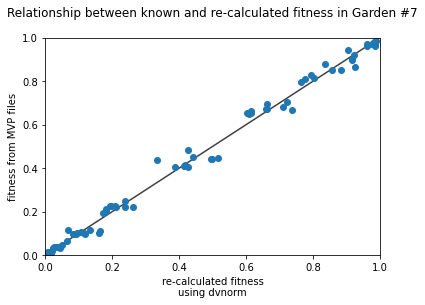


 row = 8


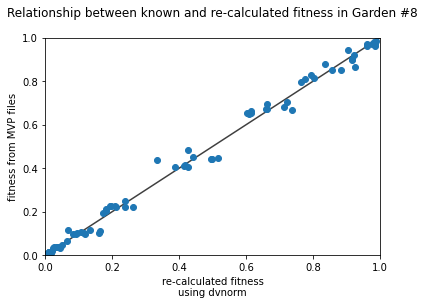


 row = 9


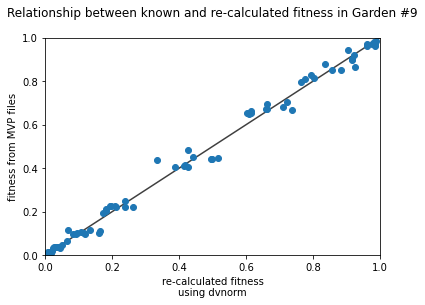


 row = 10


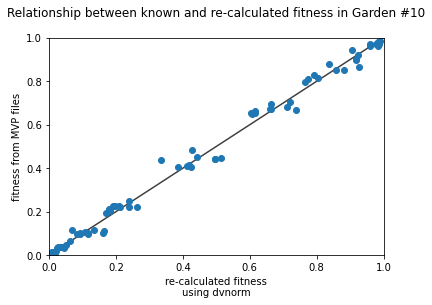


 row = 11


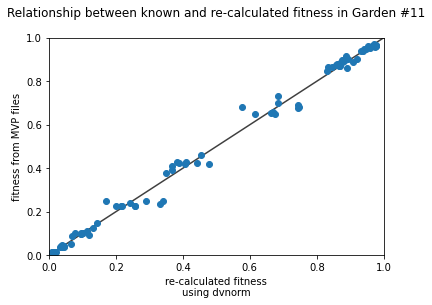


 row = 12


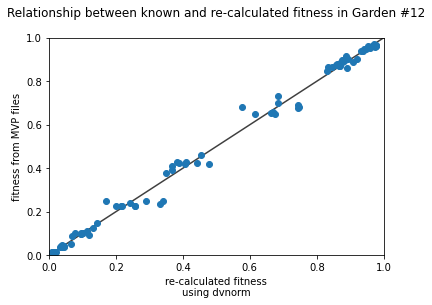


 row = 13


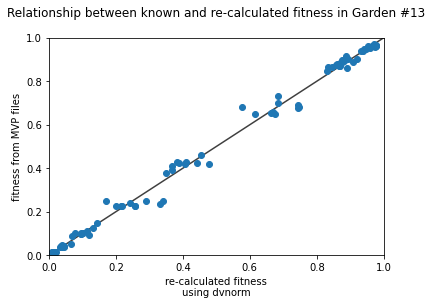


 row = 14


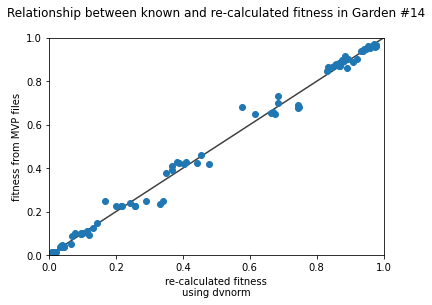


 row = 15


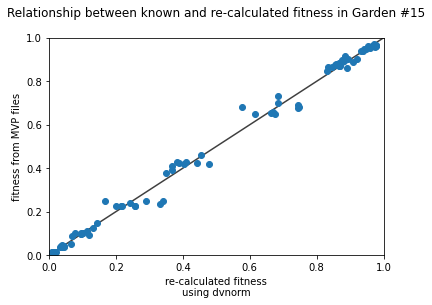


 row = 16


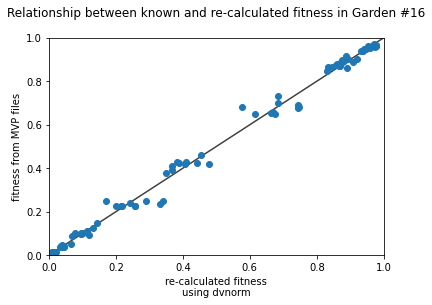


 row = 17


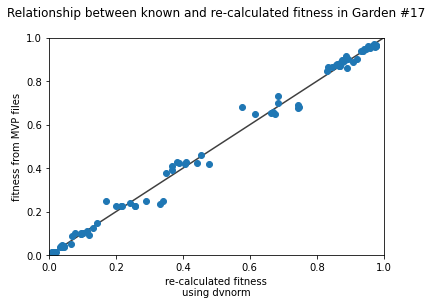


 row = 18


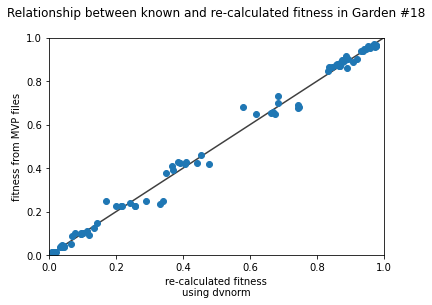


 row = 19


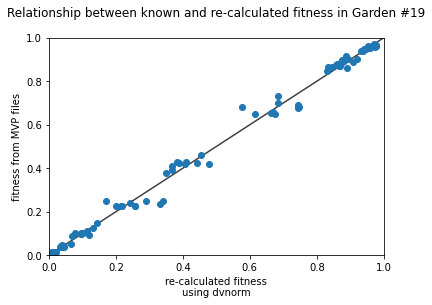


 row = 20


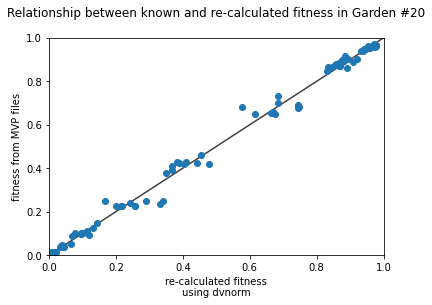


 row = 21


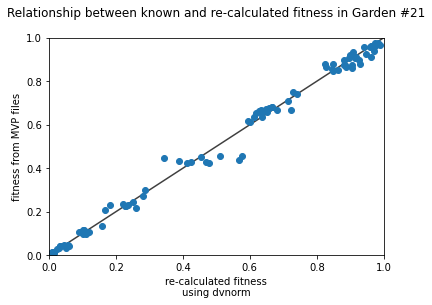


 row = 22


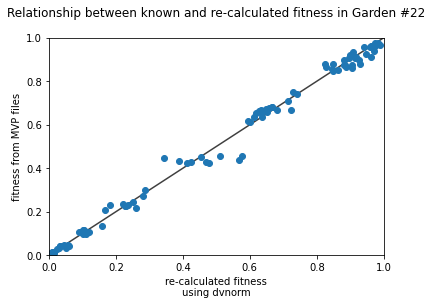


 row = 23


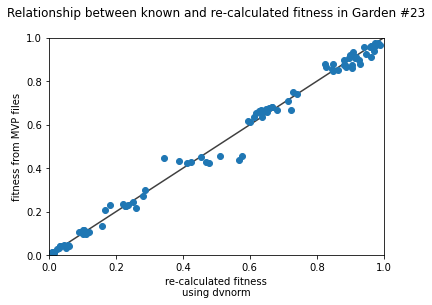


 row = 24


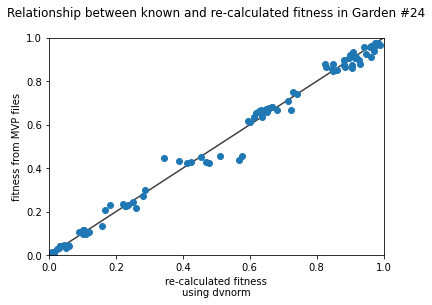


 row = 25


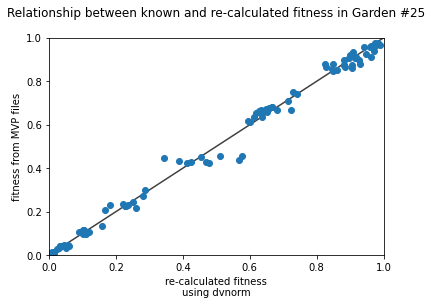


 row = 26


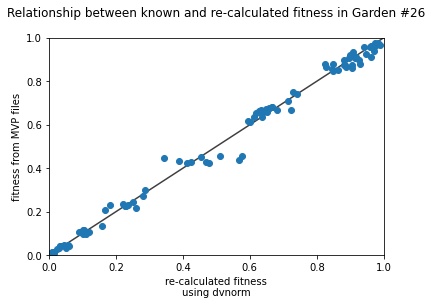


 row = 27


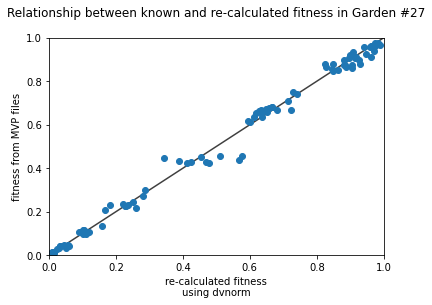


 row = 28


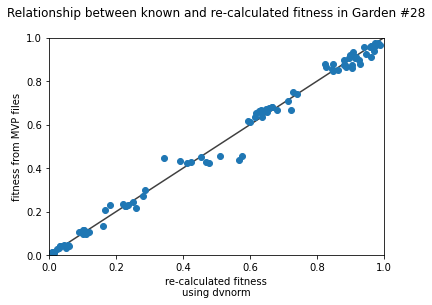


 row = 29


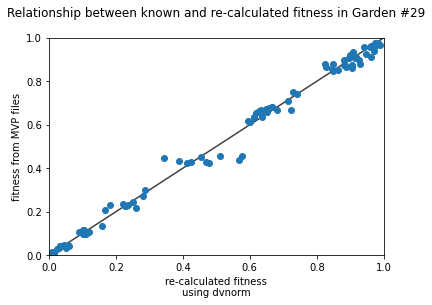


 row = 30


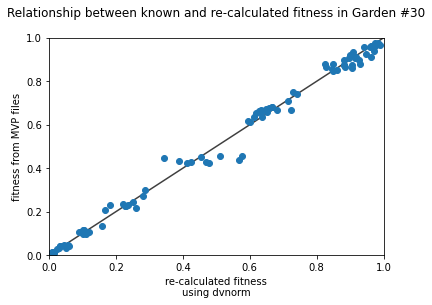


 row = 31


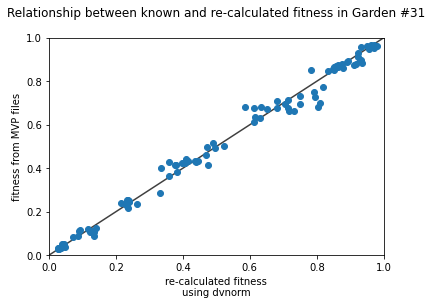


 row = 32


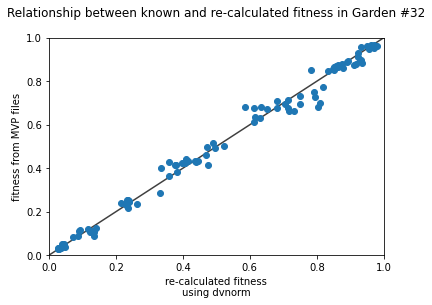


 row = 33


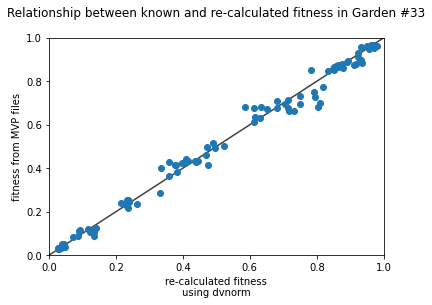


 row = 34


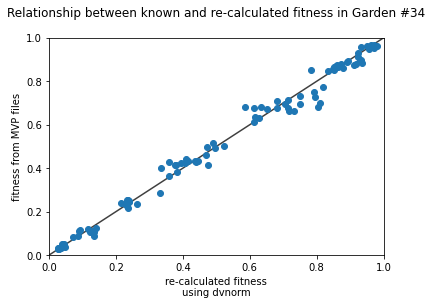


 row = 35


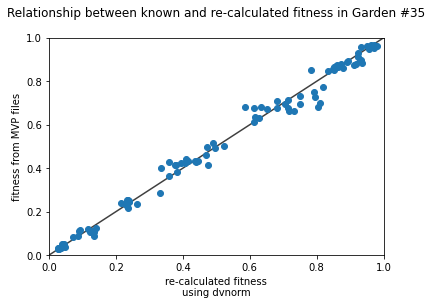


 row = 36


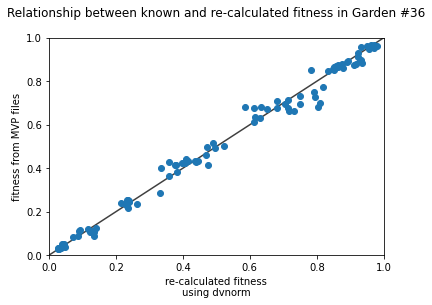


 row = 37


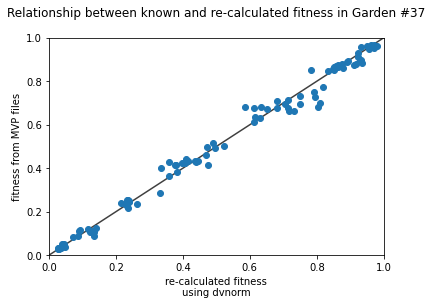


 row = 38


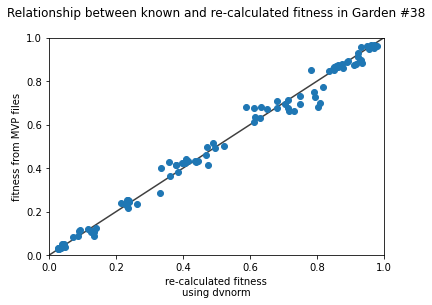


 row = 39


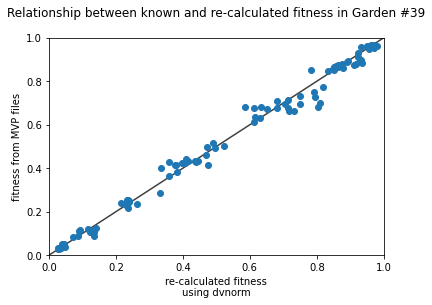


 row = 40


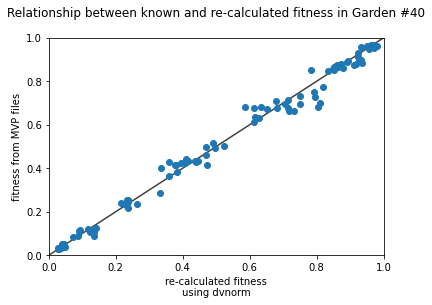


 row = 41


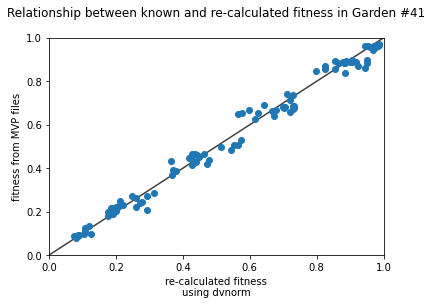


 row = 42


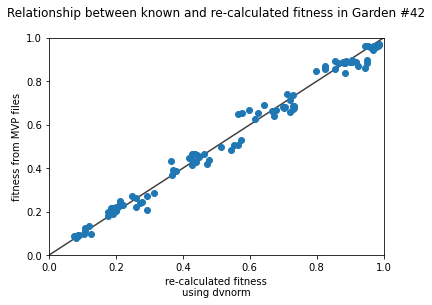


 row = 43


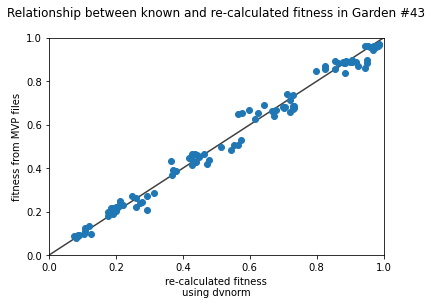


 row = 44


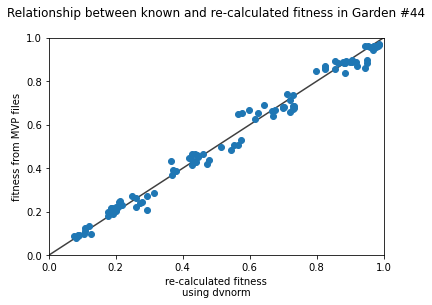


 row = 45


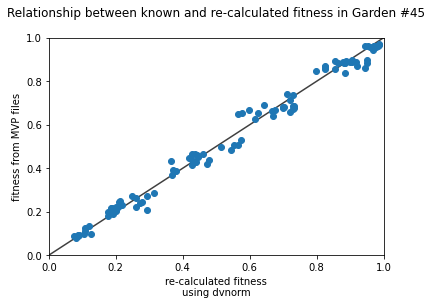


 row = 46


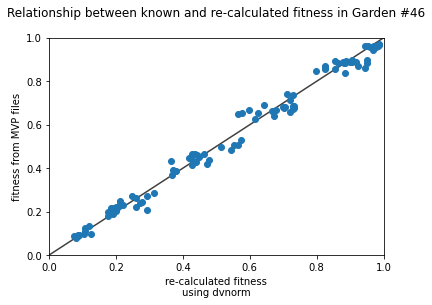


 row = 47


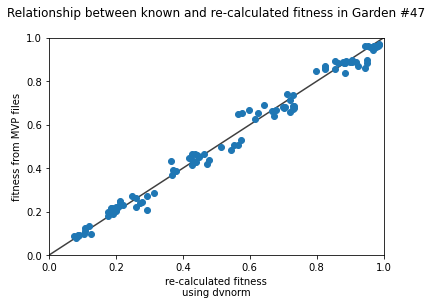


 row = 48


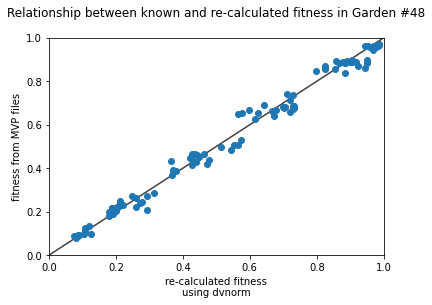


 row = 49


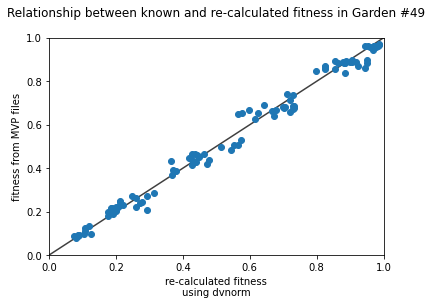


 row = 50


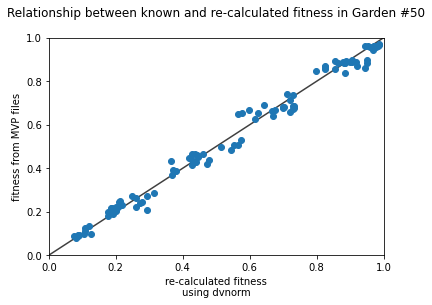


 row = 51


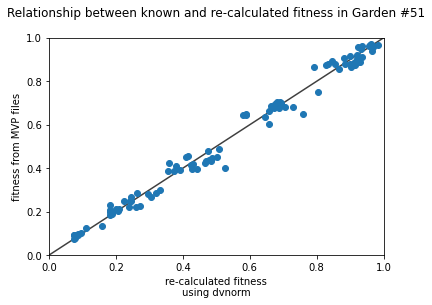


 row = 52


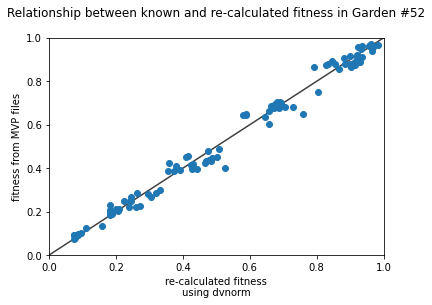


 row = 53


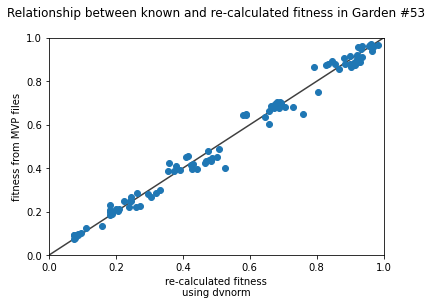


 row = 54


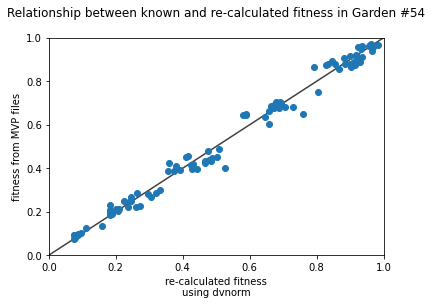


 row = 55


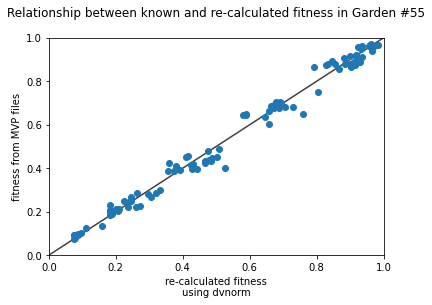


 row = 56


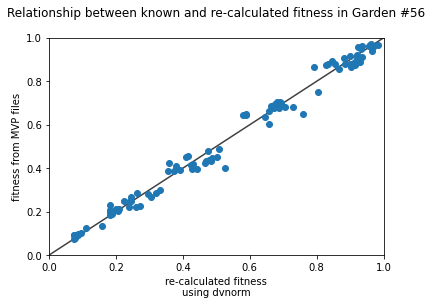


 row = 57


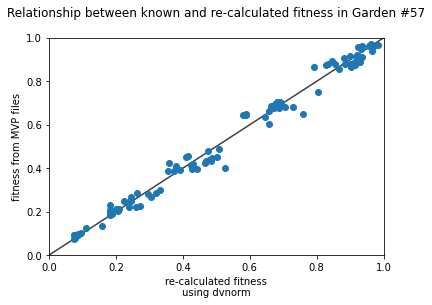


 row = 58


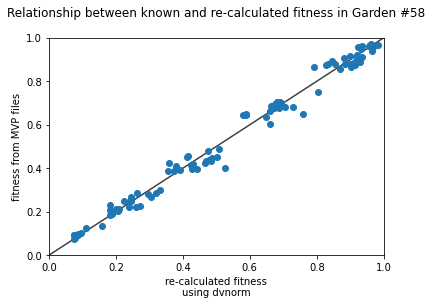


 row = 59


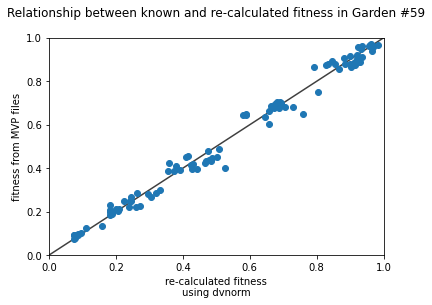


 row = 60


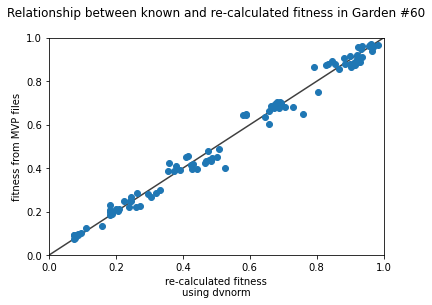


 row = 61


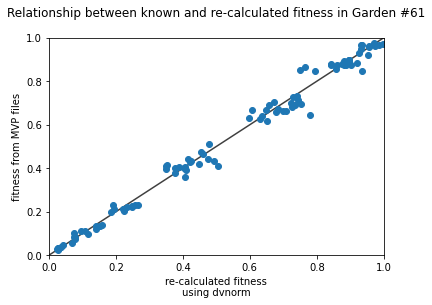


 row = 62


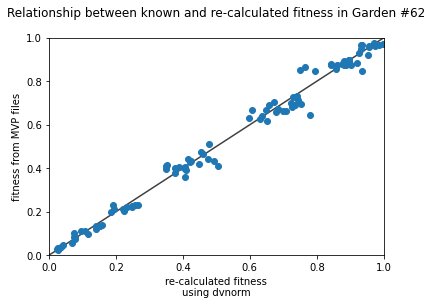


 row = 63


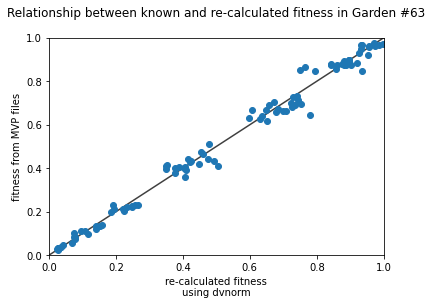


 row = 64


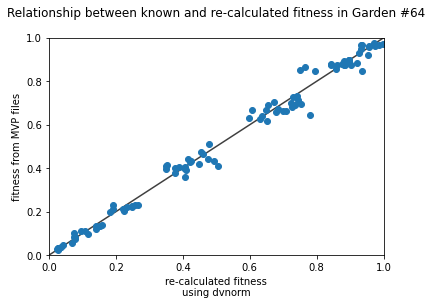


 row = 65


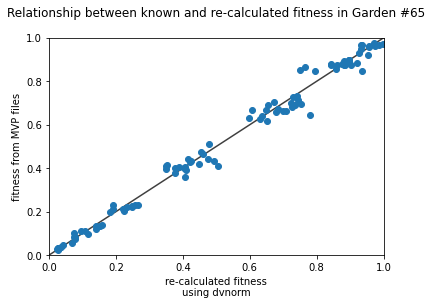


 row = 66


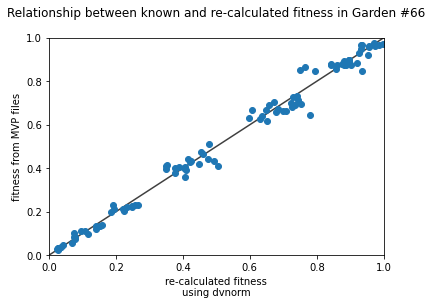


 row = 67


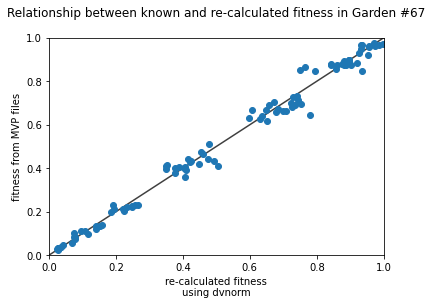


 row = 68


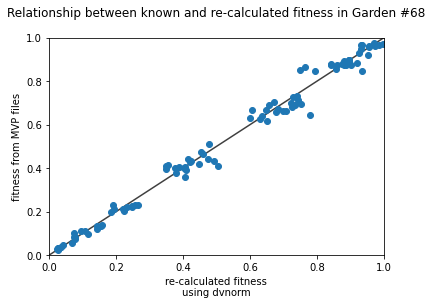


 row = 69


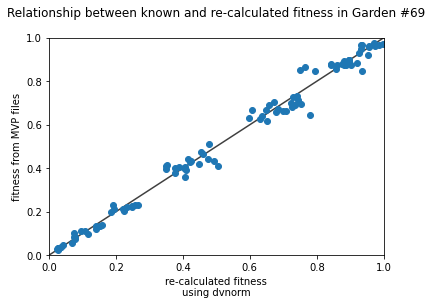


 row = 70


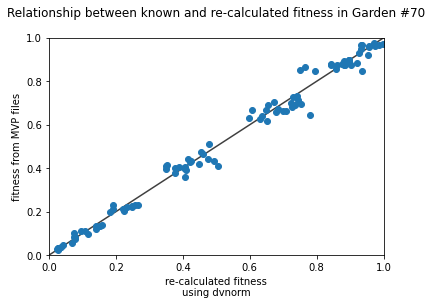


 row = 71


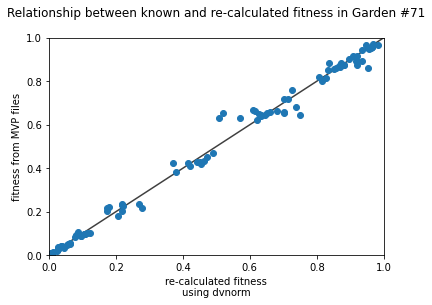


 row = 72


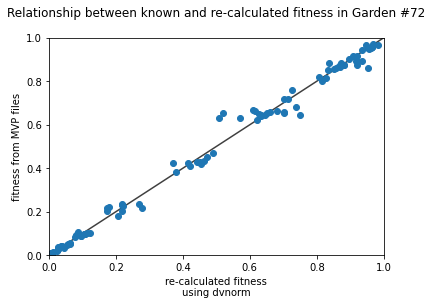


 row = 73


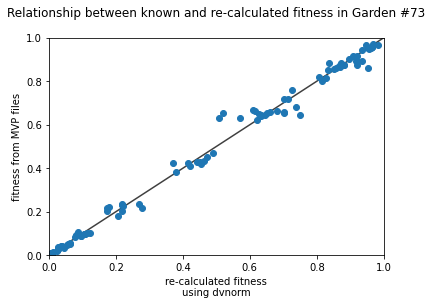


 row = 74


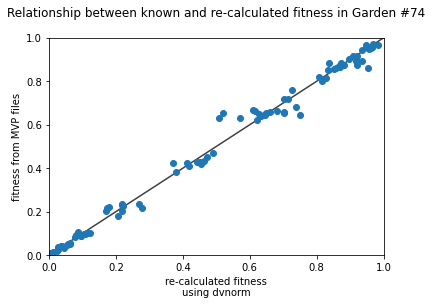


 row = 75


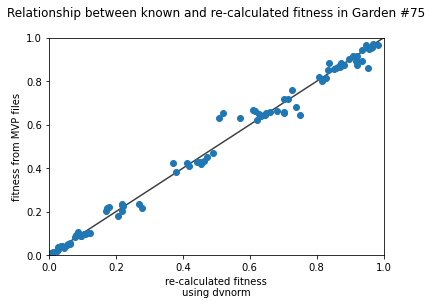


 row = 76


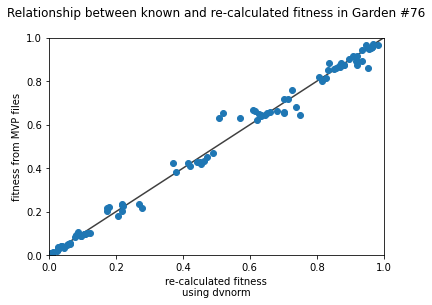


 row = 77


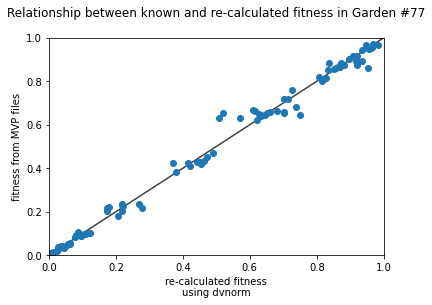


 row = 78


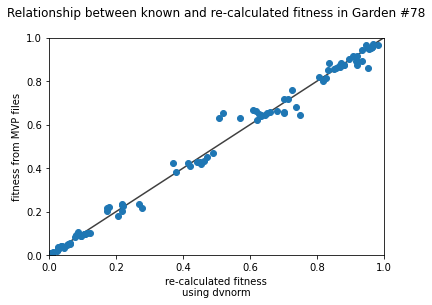


 row = 79


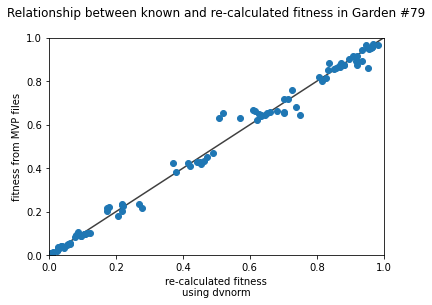


 row = 80


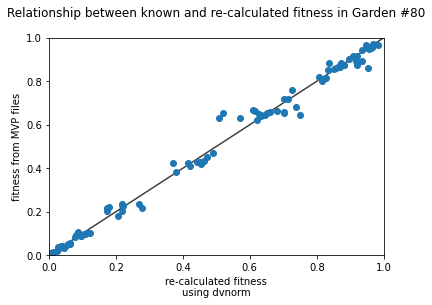


 row = 81


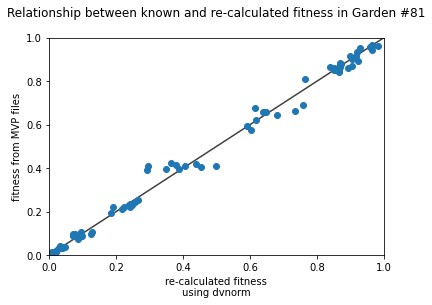


 row = 82


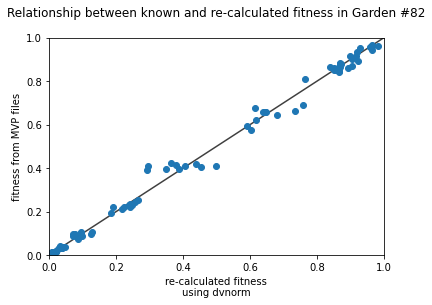


 row = 83


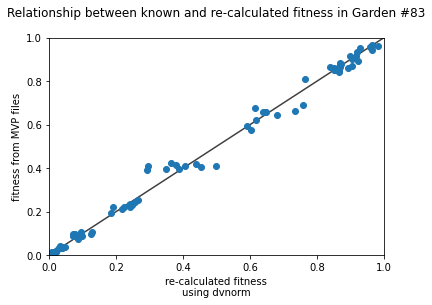


 row = 84


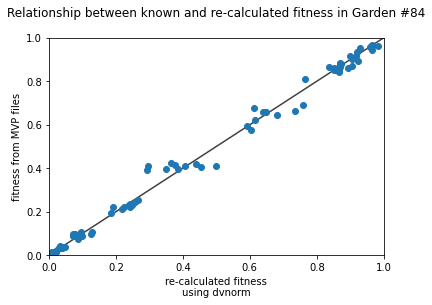


 row = 85


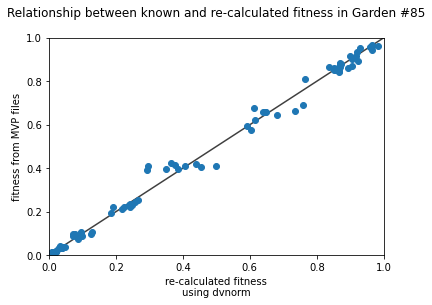


 row = 86


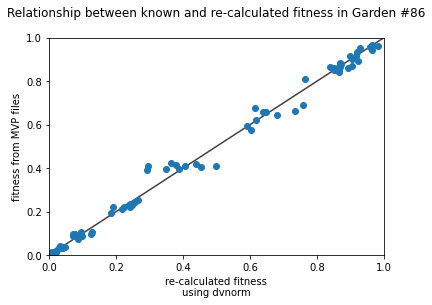


 row = 87


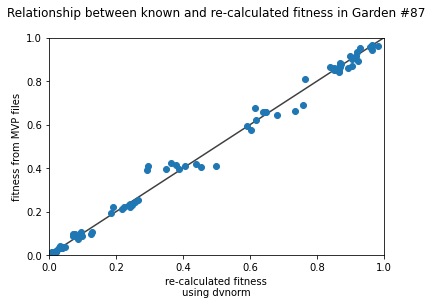


 row = 88


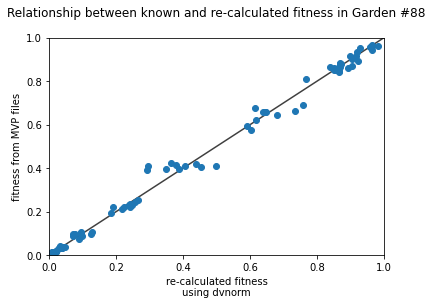


 row = 89


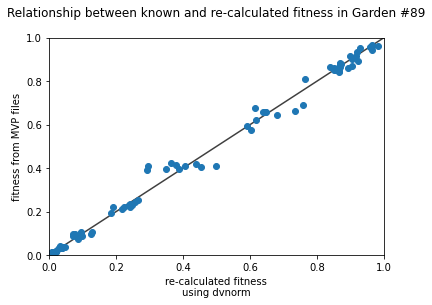


 row = 90


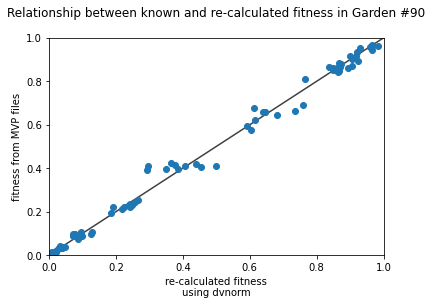


 row = 91


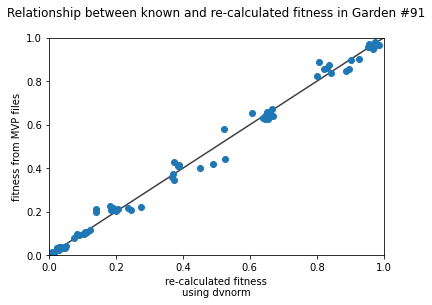


 row = 92


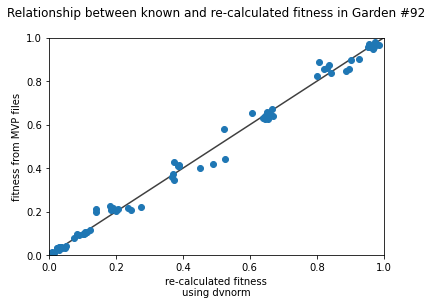


 row = 93


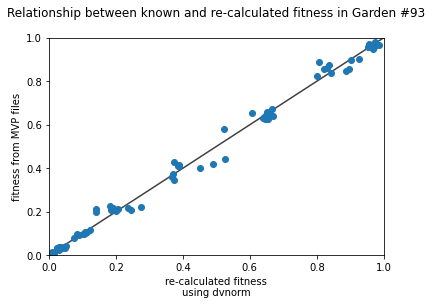


 row = 94


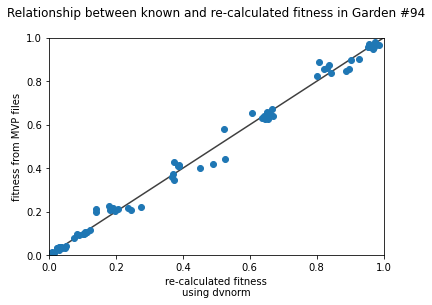


 row = 95


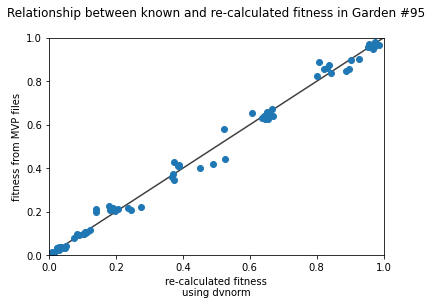


 row = 96


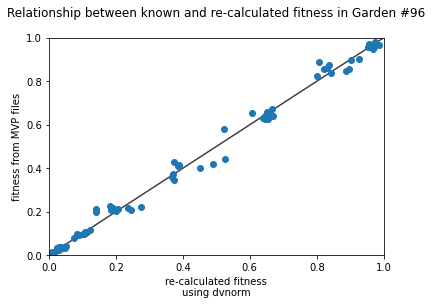


 row = 97


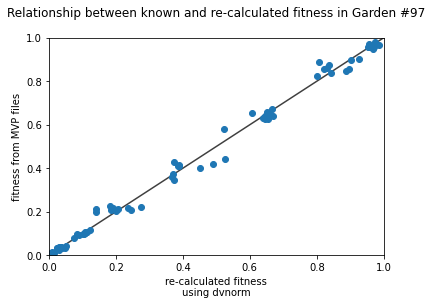


 row = 98


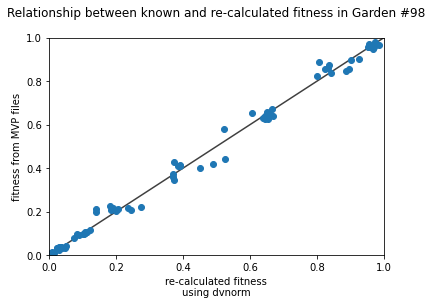


 row = 99


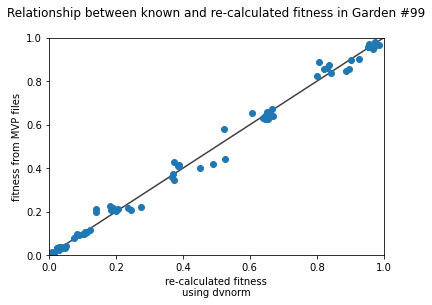


 row = 100


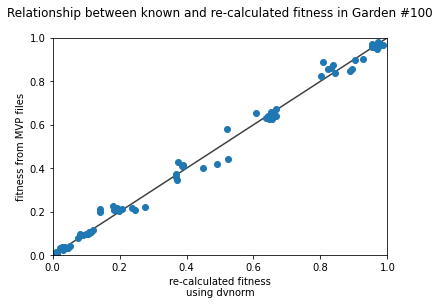

In [30]:
# plot known vs calculated fitness for each garden environment
for row in calcd_fit.index:
    print('\n', f'{row = }')
    plt.scatter(calcd_fit.loc[row], fitness_mat.loc[row])
    plt.xlabel('re-calculated fitness\nusing dvnorm')
    plt.ylabel('fitness from MVP files')
    plt.title(f'Relationship between known and re-calculated fitness in Garden #{row}\n')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot((0, 1), (0, 1), 'k-', alpha=0.75, zorder=0)
    plt.show()


 col = '1'


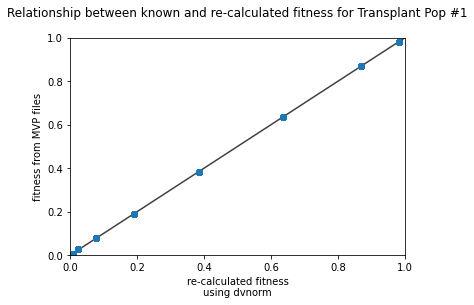


 col = '2'


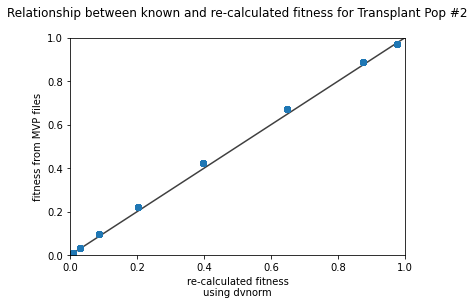


 col = '3'


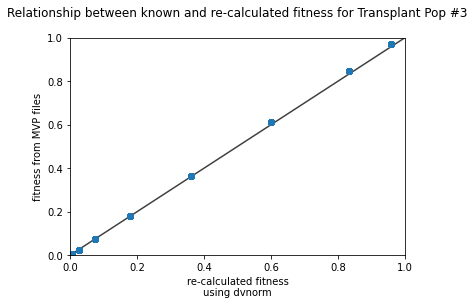


 col = '4'


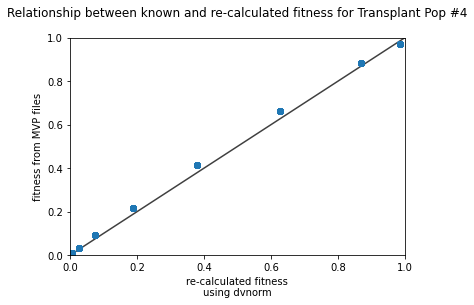


 col = '5'


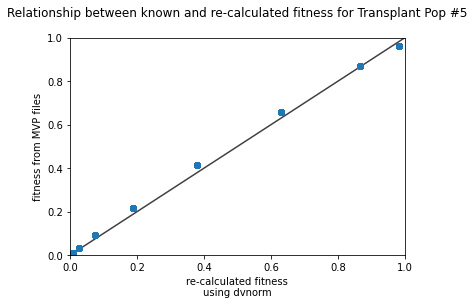


 col = '6'


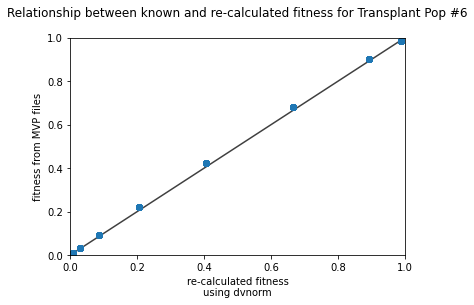


 col = '7'


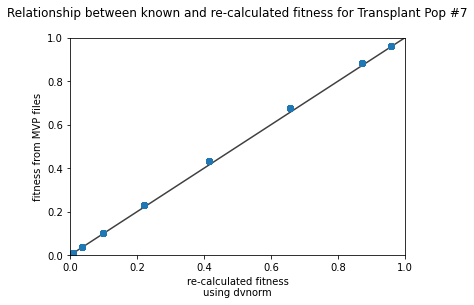


 col = '8'


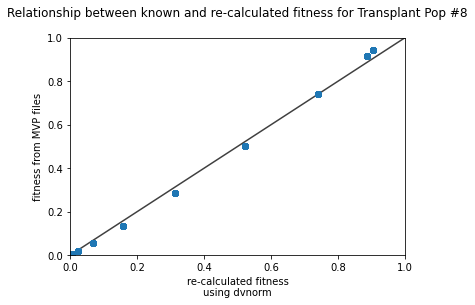


 col = '9'


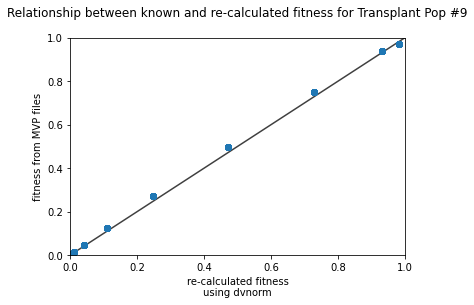


 col = '10'


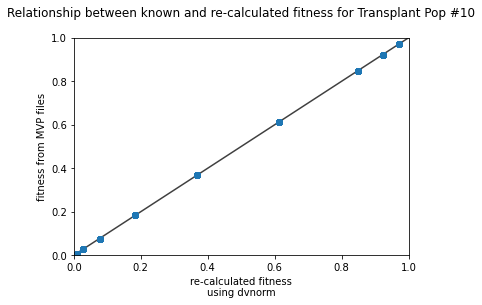


 col = '11'


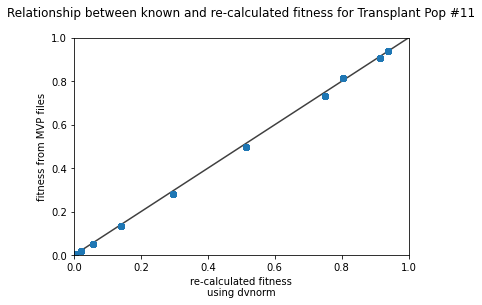


 col = '12'


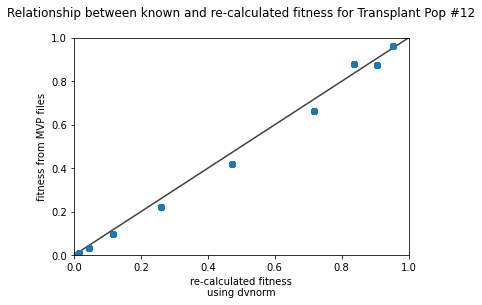


 col = '13'


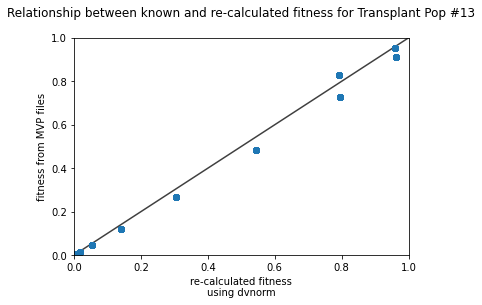


 col = '14'


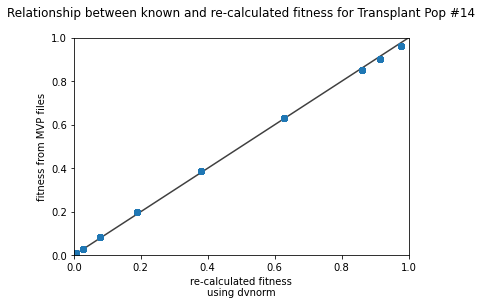


 col = '15'


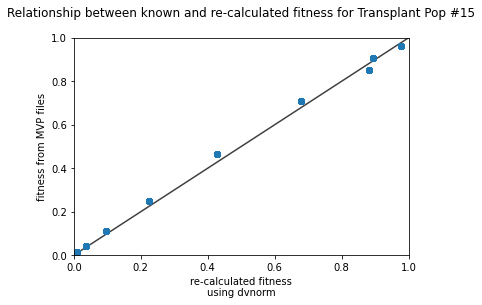


 col = '16'


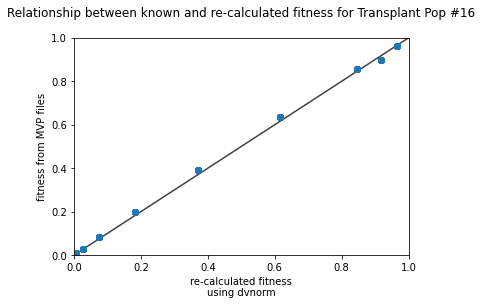


 col = '17'


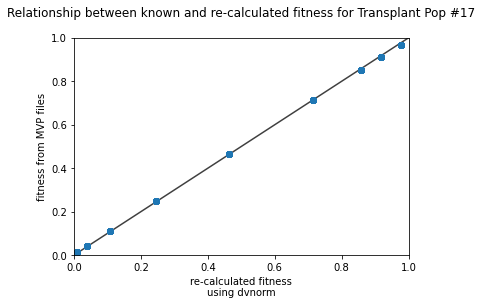


 col = '18'


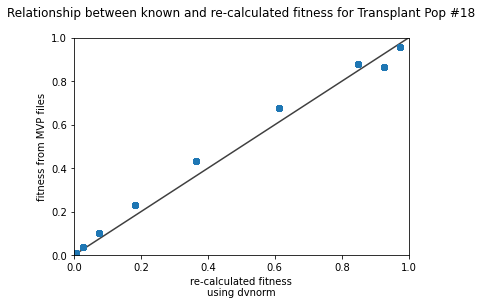


 col = '19'


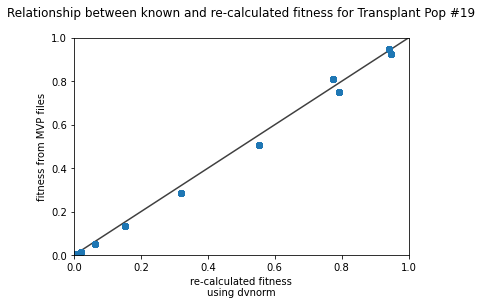


 col = '20'


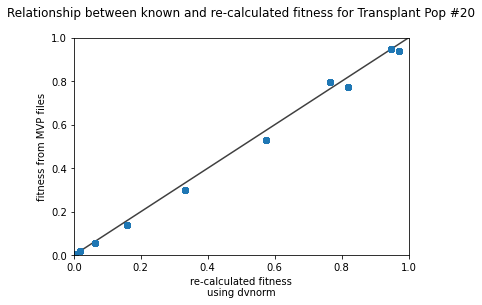


 col = '21'


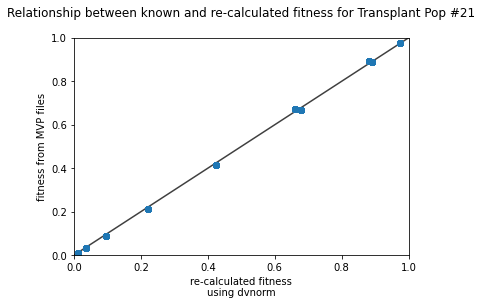


 col = '22'


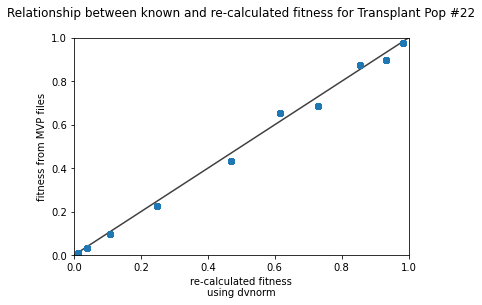


 col = '23'


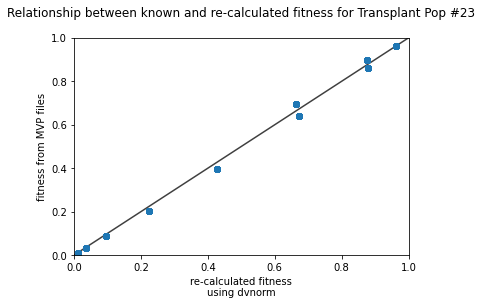


 col = '24'


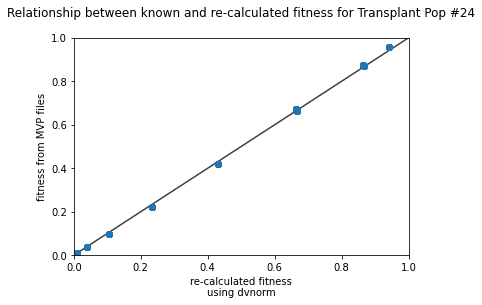


 col = '25'


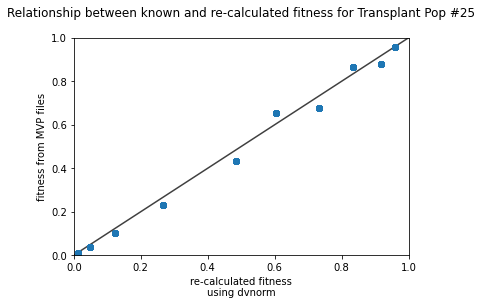


 col = '26'


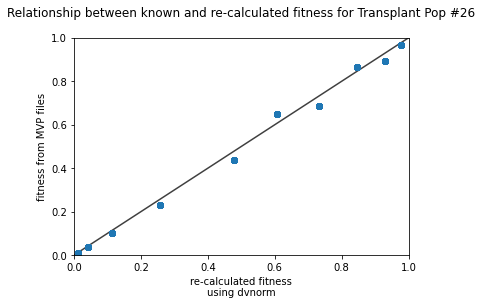


 col = '27'


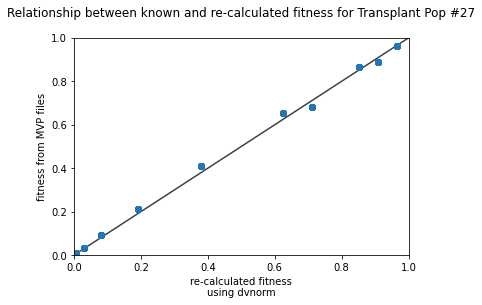


 col = '28'


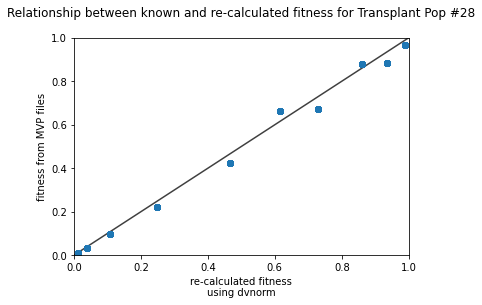


 col = '29'


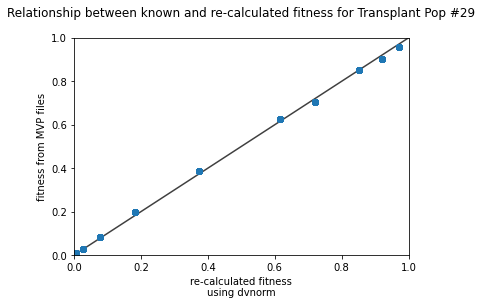


 col = '30'


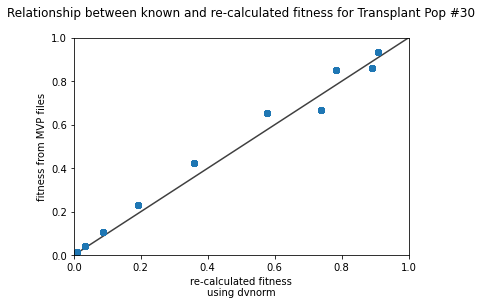


 col = '31'


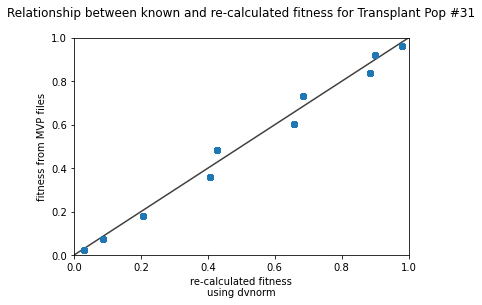


 col = '32'


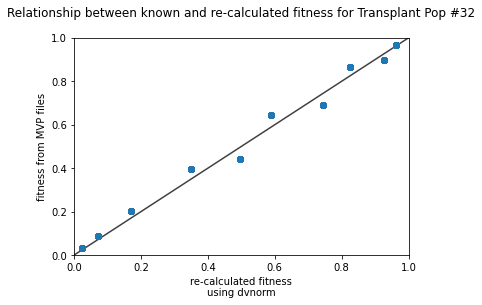


 col = '33'


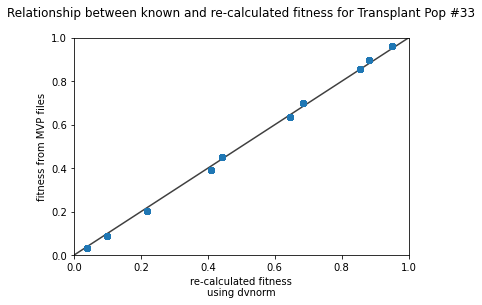


 col = '34'


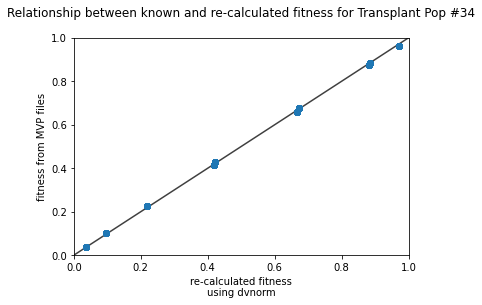


 col = '35'


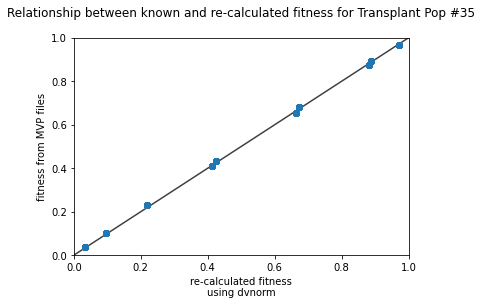


 col = '36'


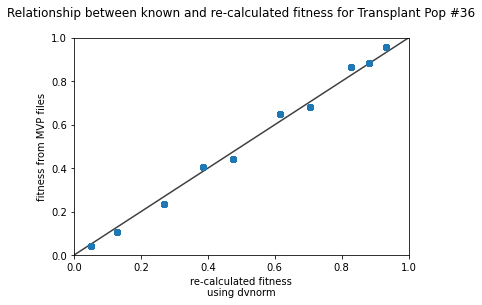


 col = '37'


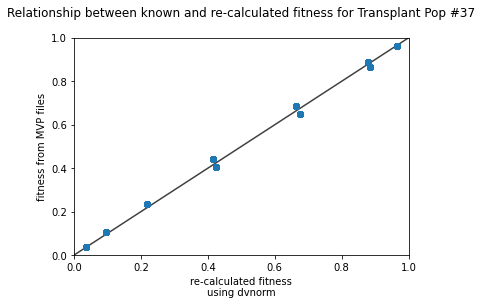


 col = '38'


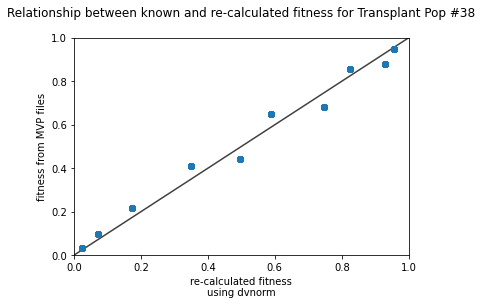


 col = '39'


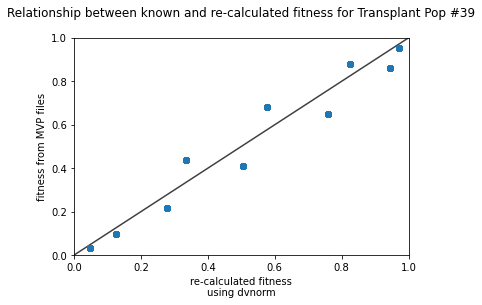


 col = '40'


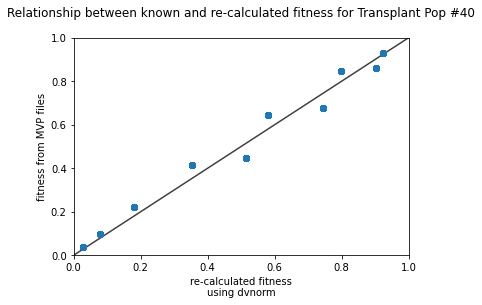


 col = '41'


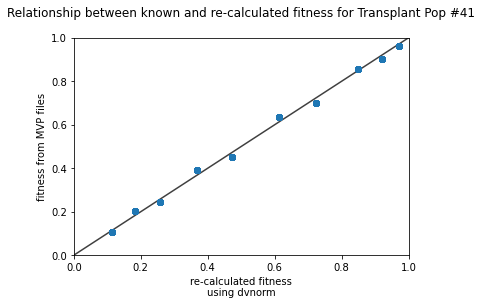


 col = '42'


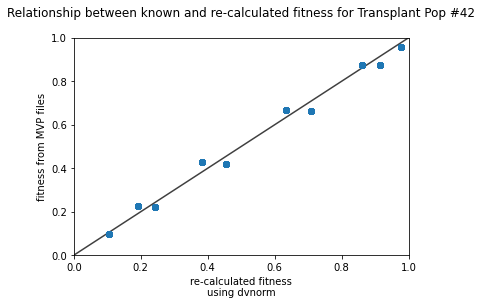


 col = '43'


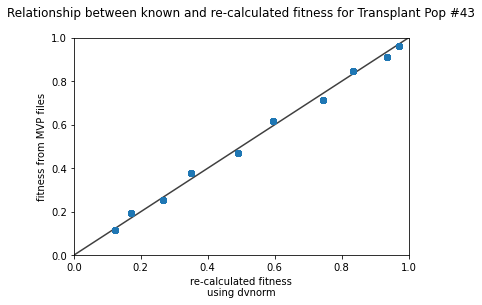


 col = '44'


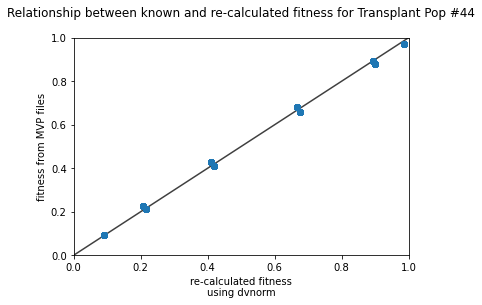


 col = '45'


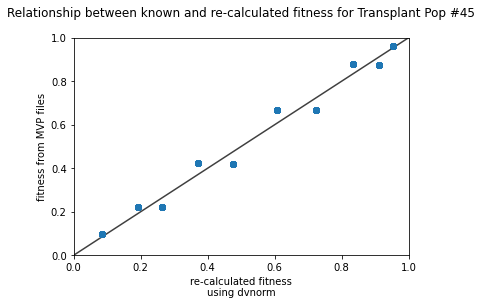


 col = '46'


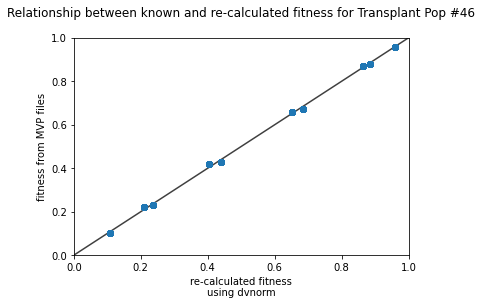


 col = '47'


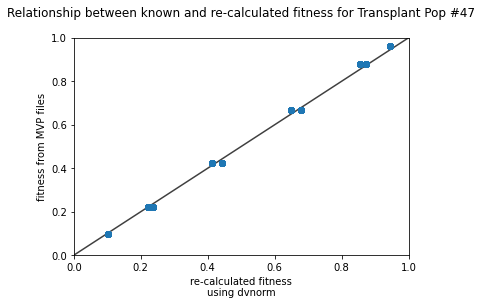


 col = '48'


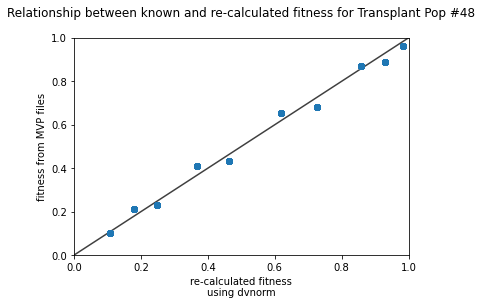


 col = '49'


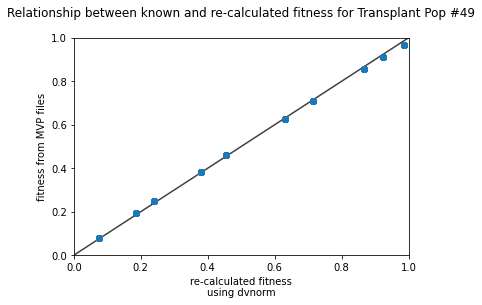


 col = '50'


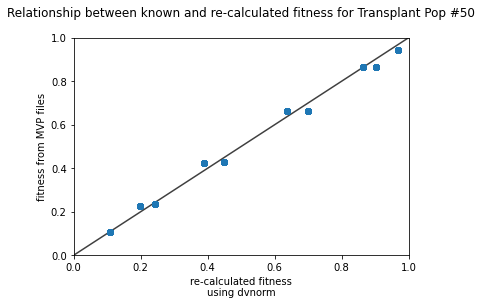


 col = '51'


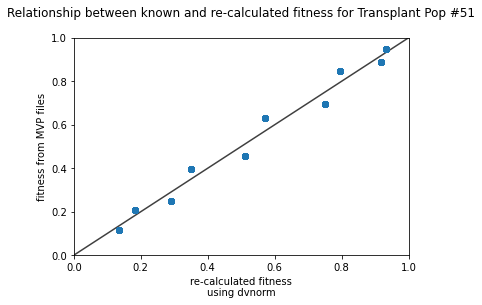


 col = '52'


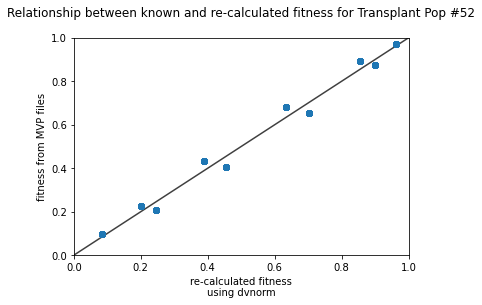


 col = '53'


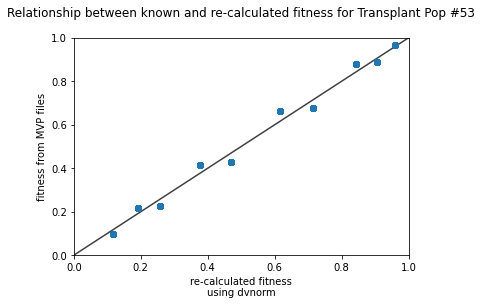


 col = '54'


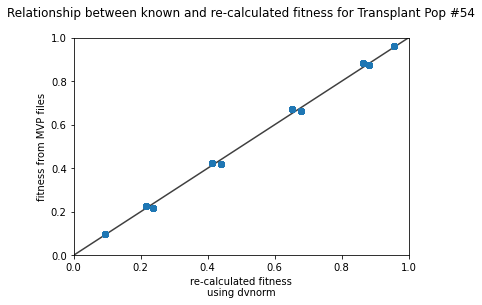


 col = '55'


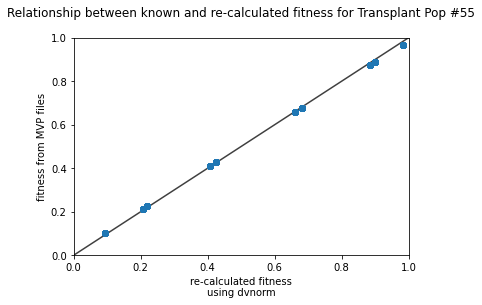


 col = '56'


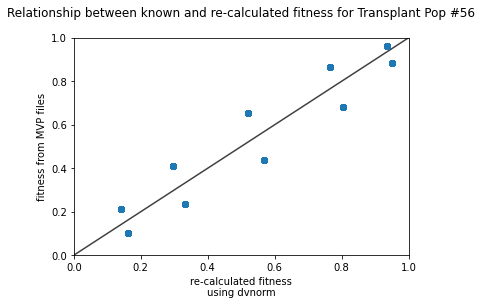


 col = '57'


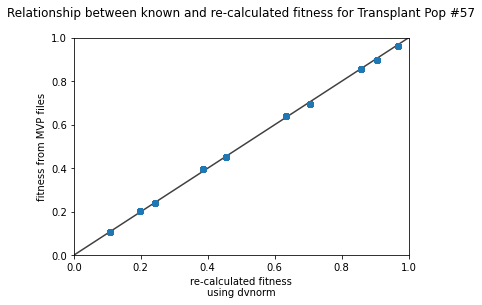


 col = '58'


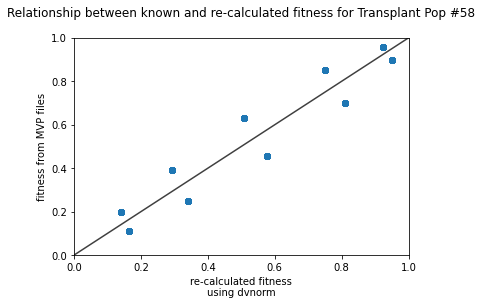


 col = '59'


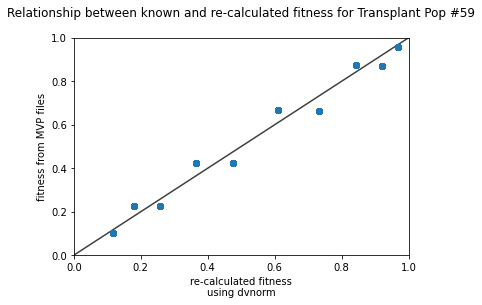


 col = '60'


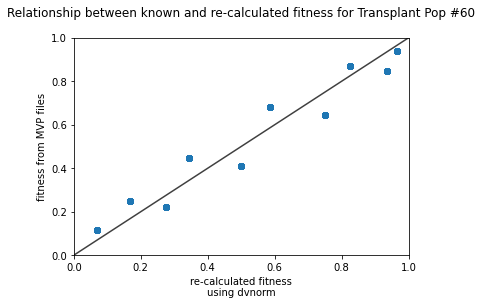


 col = '61'


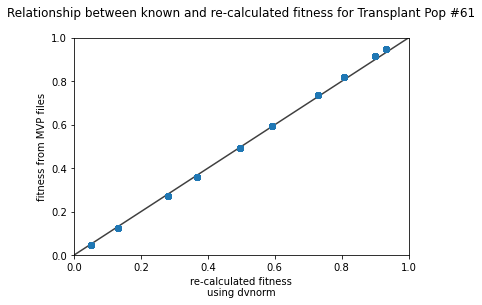


 col = '62'


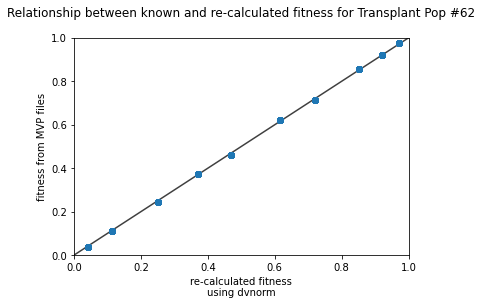


 col = '63'


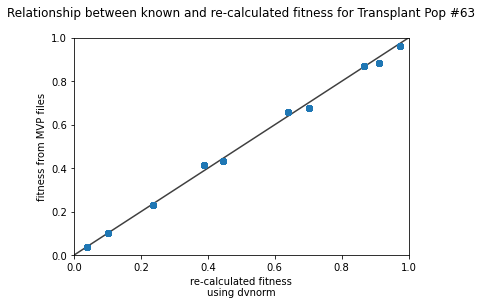


 col = '64'


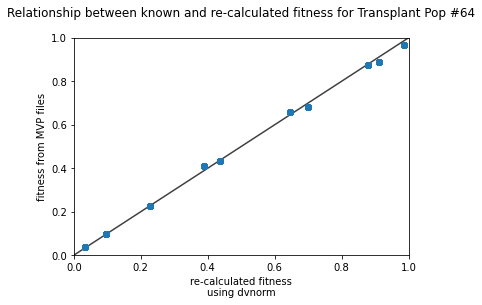


 col = '65'


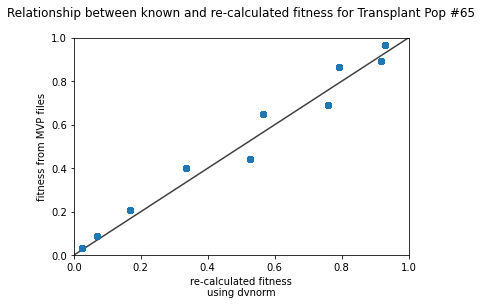


 col = '66'


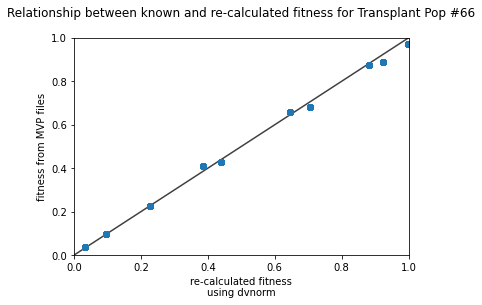


 col = '67'


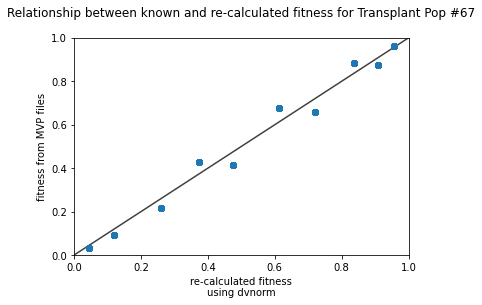


 col = '68'


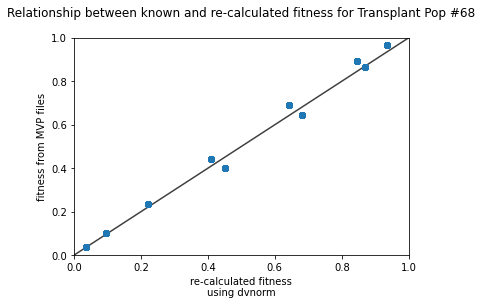


 col = '69'


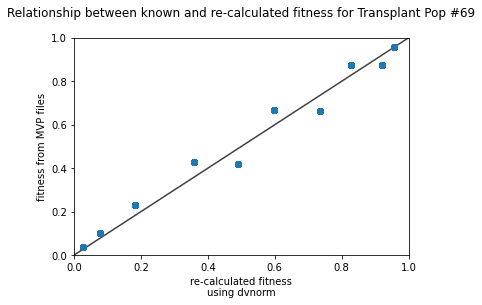


 col = '70'


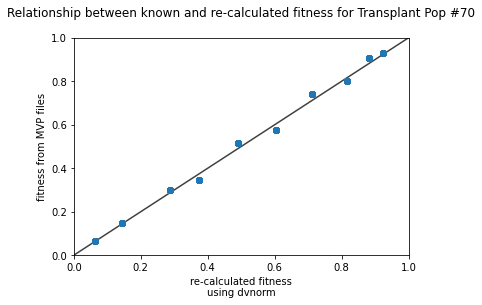


 col = '71'


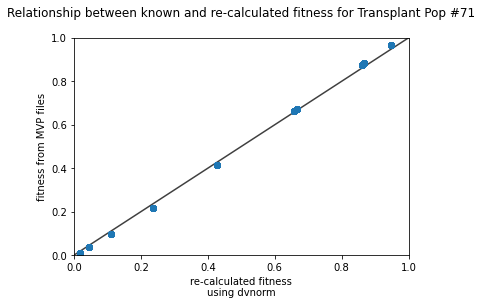


 col = '72'


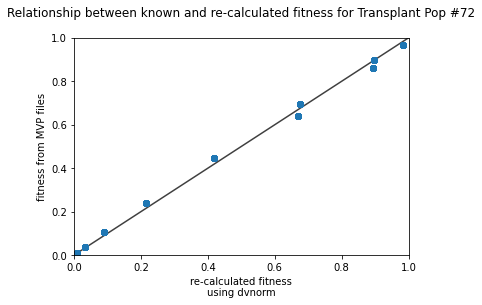


 col = '73'


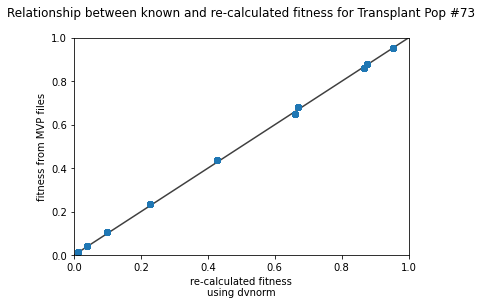


 col = '74'


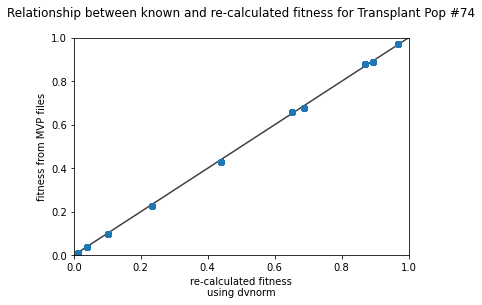


 col = '75'


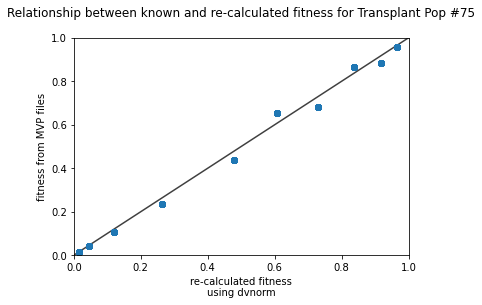


 col = '76'


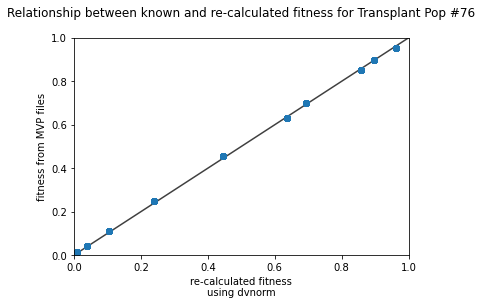


 col = '77'


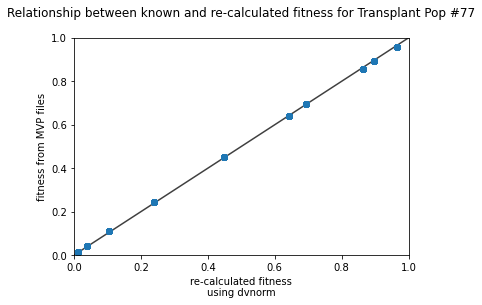


 col = '78'


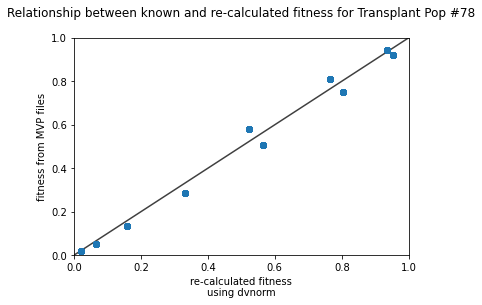


 col = '79'


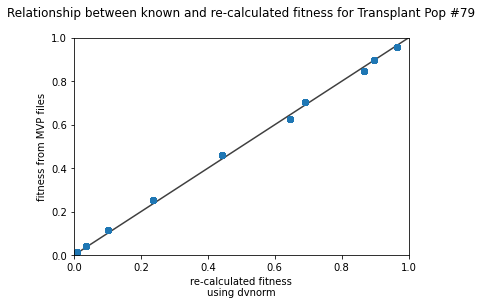


 col = '80'


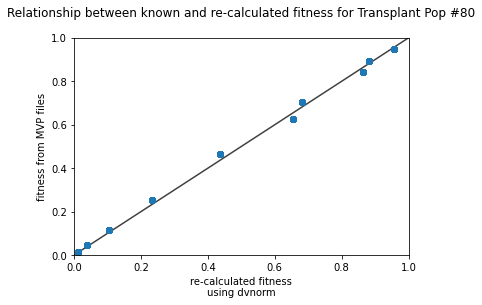


 col = '81'


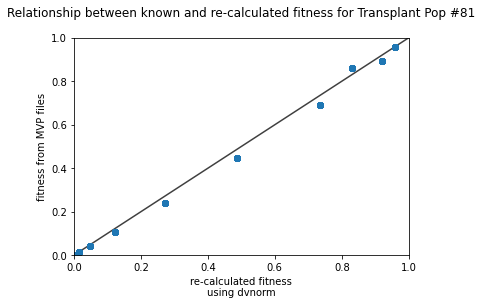


 col = '82'


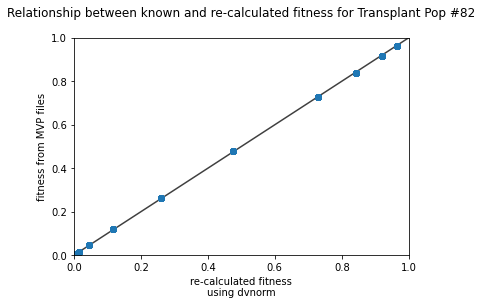


 col = '83'


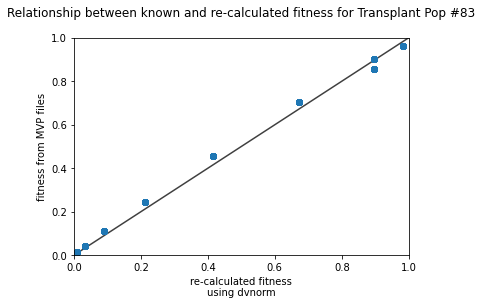


 col = '84'


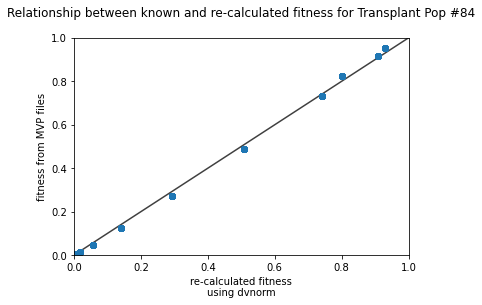


 col = '85'


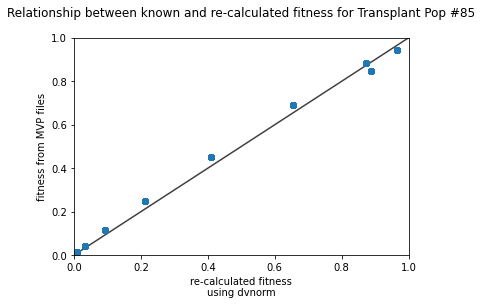


 col = '86'


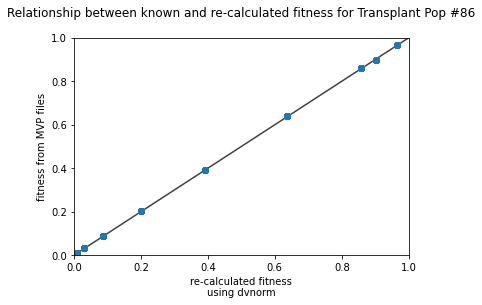


 col = '87'


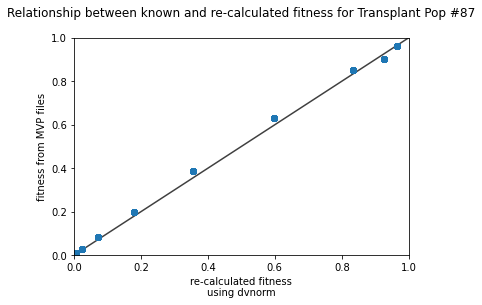


 col = '88'


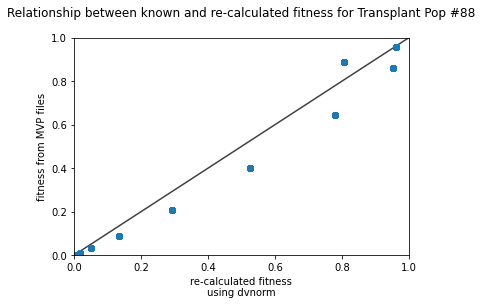


 col = '89'


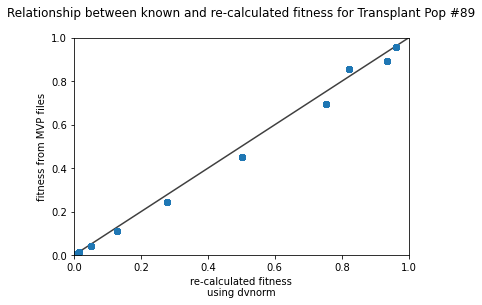


 col = '90'


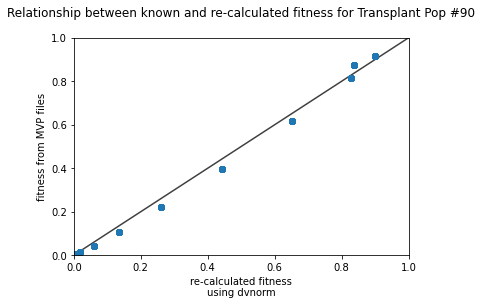


 col = '91'


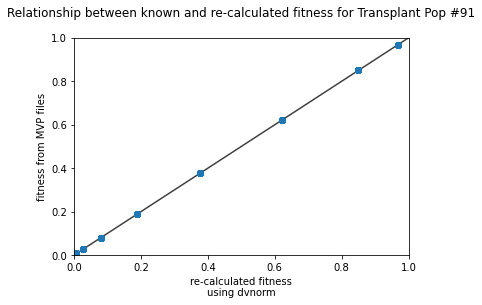


 col = '92'


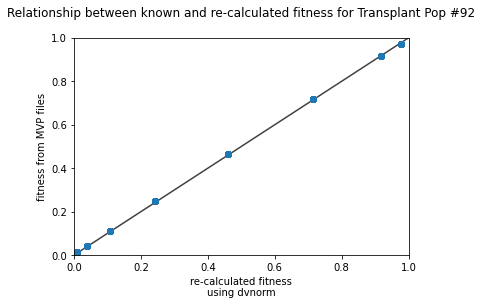


 col = '93'


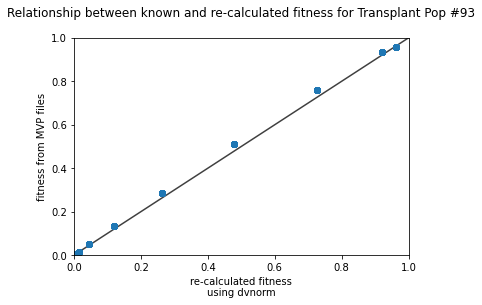


 col = '94'


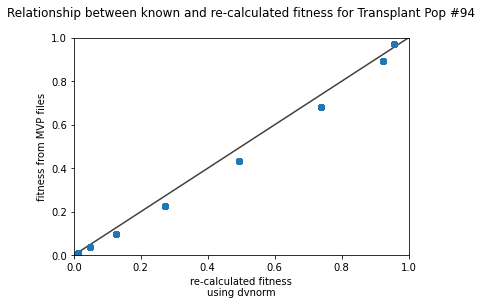


 col = '95'


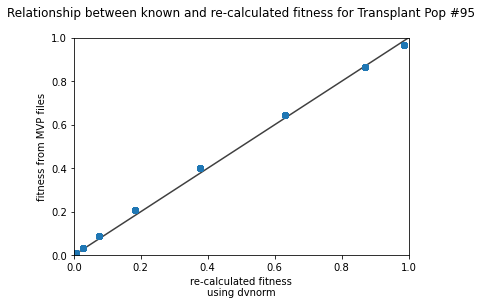


 col = '96'


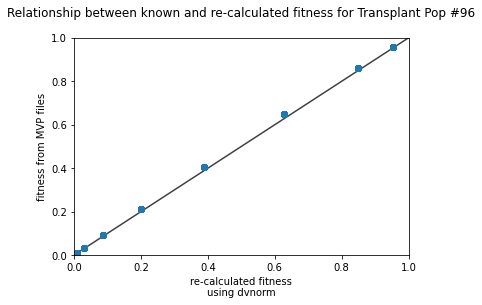


 col = '97'


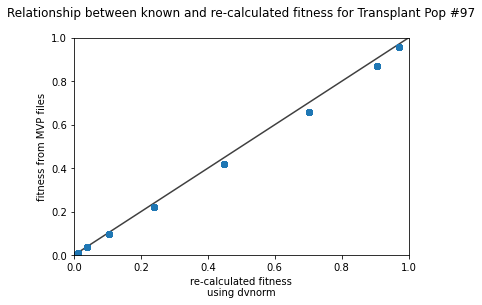


 col = '98'


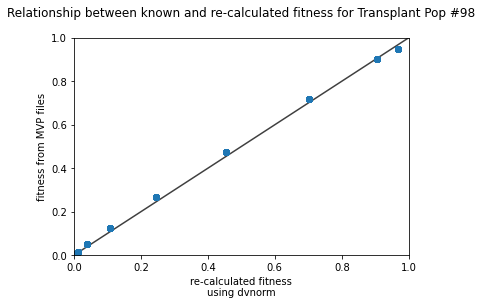


 col = '99'


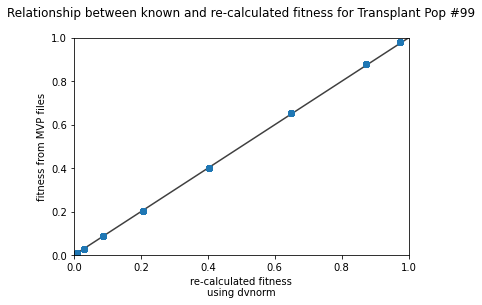


 col = '100'


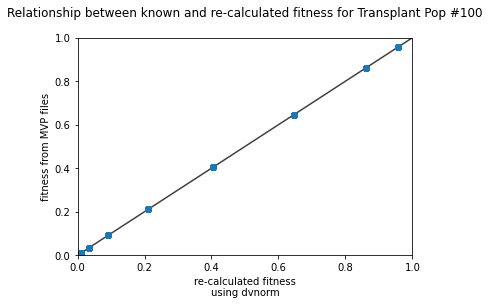

In [31]:
# show known vs calculated fitness across gardens for a specific transplant pop
for col in calcd_fit.columns:
    print('\n', f'{col = }')
    plt.scatter(calcd_fit[col], fitness_mat[col])
    plt.xlabel('re-calculated fitness\nusing dvnorm')
    plt.ylabel('fitness from MVP files')
    plt.title(f'Relationship between known and re-calculated fitness for Transplant Pop #{col}\n')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot((0, 1), (0, 1), 'k-', alpha=0.75, zorder=0)
    plt.show()   

In [32]:
# show population locations

import MVP_03_validate_gradient_forests as mvp03

subset, locations, envdata = mvp06.get_pop_data(slimdir, seed_1trait)

df = mvp03.blank_dataframe()

for pop, (long, lat) in locations.iterrows():
    df.loc[lat, long] = pop
    
df.astype(int)


Reading in info for subsampled individuals ...


1   2   3   4   5   6   7   8   9    10
10  91  92  93  94  95  96  97  98  99  100
9   81  82  83  84  85  86  87  88  89   90
8   71  72  73  74  75  76  77  78  79   80
7   61  62  63  64  65  66  67  68  69   70
6   51  52  53  54  55  56  57  58  59   60
5   41  42  43  44  45  46  47  48  49   50
4   31  32  33  34  35  36  37  38  39   40
3   21  22  23  24  25  26  27  28  29   30
2   11  12  13  14  15  16  17  18  19   20
1    1   2   3   4   5   6   7   8   9   10